# Visualizar resultados de las preferencias de TEs en genes codificantes vs zonas intergenicas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import multiprocessing as mp

In [2]:
# A partir del em_per_x hacer un grafico del tamaño de todos los tipos de TE
def process_tes(dataset):
    # Extract lengths and types
    lengths = [(row[2] - row[1], row[6].split("/")[0]) for _, row in dataset.iterrows()]

    # Initialize lists for each TE type
    sine_lengths = []
    line_lengths = []
    ltr_lengths = []
    dna_lengths = []

    # Classify lengths by TE type
    for length, te_type in lengths:
        if te_type == "SINE":
            sine_lengths.append(length)
        elif te_type == "LINE":
            line_lengths.append(length)
        elif te_type == "LTR":
            ltr_lengths.append(length)
        elif te_type == "DNA":
            dna_lengths.append(length)
        elif te_type == "RC":
            dna_lengths.append(length)
        elif te_type == "Retroposon":
            dna_lengths.append(length)
    
    return [sine_lengths, line_lengths, ltr_lengths, dna_lengths]

In [3]:
def feat_len(dataset):
    return [row[2] - row[1] for _, row in dataset.iterrows()]

In [4]:
def occ_report(dataset1, intr_len, length_intergenic, intergenic):
    # dataset1 tiene el arreglo con todos los arreglos de los largos de los elementos moviles
    # intr_len es el largo de todos los intrones codificantes a proteina
    # length_intergenic es el largo de las zonas intergenicas
    # intergenic es el arreglo con arreglo de los tamaños de los elementos moviles en zonas intergenicas

    all_lens = 0
    all_intergenics = 0
    titles = ["SINE", "LINE", "LTR", "DNA"]
    intergenics = []
    intronics = []

    
    for length1, title, length2 in zip(dataset1, titles, intergenic):
        all_lens += sum(length1)
        all_intergenics += sum(length2)

        occ_intr = sum(length1)/intr_len
        occ_intergenic = sum(length2)/length_intergenic

        print(f"Para {title}")
        print(f"Ocupancia en intrones : {occ_intr}")
        print(f"Ocupancia intergenica: {occ_intergenic}")

        intronics.append(occ_intr)
        intergenics.append(occ_intergenic)

    print(f"En total en intrones: {all_lens/intr_len}")
    print(f"En total en intergenica: {all_intergenics/length_intergenic}")

    return(intronics, intergenics)

In [5]:
def t_test(data1, data2, titles):
    # iterativamente ver si las lengths de line/sine etc son estadisticamente diferentes entre si
    for length1, length2, title in zip(data1, data2, titles):
        t_stat, p_value = stats.ttest_ind(length1, length2)

        print(f"\nPara {title}")
        print(f"Promedio 1: {np.mean(length1)}")
        print(f"Promedio 2: {np.mean(length2)}")
        print("Two-sample t-test")
        print(f"t-statistic: {t_stat}")
        print(f"p-value: {p_value}")

        if p_value < 0.05:
            print("Reject the null hypothesis: The means are significantly different.")
        else:
            print("Fail to reject the null hypothesis: The means are not significantly different.")

In [6]:
def graph_data(data, supertitle):
    
    class_lengths = []
    class_freqs = []

    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.flatten()

    # Data and titles for subplots
    titles = ["SINE", "LINE", "LTR", "DNA"]

    # Plot each histogram
    for ax, lengths, title in zip(axs, data, titles):
        ax.hist(lengths, bins=30, edgecolor='black')
        n_elements = len(lengths)
        mean_length = sum(lengths) / len(lengths) if lengths else 0

        ax.set_title(f'Lengths of {title} Elements')
        ax.set_xlabel('Length')
        ax.set_ylabel('Frequency')
        ax.legend([f'Mean: {mean_length:.2f} - N: {n_elements}'])

        class_lengths.append(mean_length)
        class_freqs.append(n_elements)

    plt.suptitle(supertitle, fontsize=16)

    plt.tight_layout()
    plt.show()

    return class_lengths, class_freqs

In [7]:
def graph_data_overlapping(data1, data2, supertitle):
    
    class_lengths1 = []
    class_lengths2 = []
    class_freqs1 = []
    class_freqs2 = []

    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.flatten()

    # Data and titles for subplots
    titles = ["SINE", "LINE", "LTR", "DNA"]

    # Plot each histogram
    for ax, lengths1, lengths2, title in zip(axs, data1, data2, titles):
        ax.hist(lengths1, bins=30, alpha=0.5, edgecolor='black', label='Data1')  # Histogram for data1
        ax.hist(lengths2, bins=30, alpha=0.5, edgecolor='black', label='Data2')  # Histogram for data2
        
        n_elements1 = len(lengths1)
        n_elements2 = len(lengths2)
        mean_length1 = sum(lengths1) / len(lengths1) if lengths1 else 0
        mean_length2 = sum(lengths2) / len(lengths2) if lengths2 else 0

        ax.set_title(f'Lengths of {title} Elements')
        ax.set_xlabel('Length')
        ax.set_ylabel('Frequency')
        ax.legend([f'Intronic - Mean: {mean_length1:.2f}, N: {n_elements1}', 
                            f'Intergenic - Mean: {mean_length2:.2f}, N: {n_elements2}'])

        class_lengths1.append(mean_length1)
        class_lengths2.append(mean_length2)
        class_freqs1.append(n_elements1)
        class_freqs2.append(n_elements2)

    plt.suptitle(supertitle, fontsize=16)

    plt.tight_layout()
    plt.show()

    return (class_lengths1, class_freqs1), (class_lengths2, class_freqs2)


In [8]:
# Tomar las ocupancias en intrones y zonas intergenicas, calcular la preferencia dividiendo
def pref_intron_inter(occs_intronic, occs_intergenic):
    prefs = []
    for intronic, intergenic in zip(occs_intronic, occs_intergenic):
        try:
            prefs.append(intronic/intergenic)
        except:
            prefs.append(None)
    print(prefs)
    return prefs


In [9]:
def df_per_chr(occs_per_chr):
    data = []
    for key in occs_per_chr.keys():
        data.append(occs_per_chr[key])
    intronic_chr = pd.DataFrame(data=data, columns=titles, index=occs_per_chr.keys())
    return intronic_chr

In [10]:
def df_pref_per_chr(occs_per_chr_intronic, occs_per_chr_intergenic):
    data = []
    for key1, key2 in zip(occs_per_chr_intronic, occs_per_chr_intergenic):
        data.append([val1/val2 if val2 != 0 else None for val1, val2 in zip(occs_per_chr_intronic[key1], occs_per_chr_intergenic[key2])])
    pref_chr = pd.DataFrame(data=data, columns=titles, index=occs_per_chr_intergenic.keys())
    return pref_chr

In [11]:
def count_genes_per_chr(chr_name, df, chr_col_index):
    return chr_name, df[df[chr_col_index] == chr_name].shape[0]

def parallel_gene_count(chr_lengths, df, chr_col_index=0):
    with mp.Pool(mp.cpu_count()) as pool:
        # Use pool.starmap to pass multiple arguments to the function
        results = pool.starmap(count_genes_per_chr, [(chr_name, df, chr_col_index) for chr_name in chr_lengths.keys()])
    
    # Convert the results into a dictionary
    return dict(results)

In [12]:
def min_max_normalize(data):
    min_val = min(data)
    max_val = max(data)
    
    # Handle the case where all values are the same (avoid division by zero)
    if min_val == max_val:
        return [0.0 for _ in data]
    
    return [(x - min_val) / (max_val - min_val) for x in data]

In [13]:
titles = ["SINE", "LINE", "LTR", "DNA"]

## En Mus Musculus

In [14]:
# Cargar datos para mus musculus
mm_pcgenes_df = pd.read_csv("results/mus_musculus/em_per_gene.bed", sep="\t", header=None)
m_musculus_pcgenes = process_tes(mm_pcgenes_df)

mm_introns_df = pd.read_csv("results/mus_musculus/em_per_intron.bed", sep="\t", header=None)
m_musculus_introns = process_tes(mm_introns_df)

mm_intergenic_df = pd.read_csv("results/mus_musculus/em_intergenic.bed", sep="\t", header=None)
m_musculus_intergenic = process_tes(mm_intergenic_df)

mm_fullintron_df = pd.read_csv("results/mus_musculus/introns.bed", sep="\t", header=None)
m_musculus_fullintron = sum(feat_len(mm_fullintron_df))

mm_fullgene_df = pd.read_csv("results/mus_musculus/genes.bed", sep="\t", header=None)
m_musculus_fullgene = sum(feat_len(mm_fullgene_df))

#mm_occs_intronic, mm_occs_intergenic = occ_report(m_musculus_introns, m_musculus_fullintron, m_musculus_intergenic_size, m_musculus_intergenic)


In [15]:
mm_chr_lengths = {"NC_000067.7": 195154279,
                    "NC_000068.8":181755017,
                    "NC_000069.7":159745316,
                    "NC_000070.7":156860686,
                    "NC_000071.7":151758149,
                    "NC_000072.7":149588044,
                    "NC_000073.7":144995196,
                    "NC_000074.7":130127694,
                    "NC_000075.7":124359700,
                    "NC_000076.7":130530862,
                    "NC_000077.7":121973369,
                    "NC_000078.7":120092757,
                    "NC_000079.7":120883175,
                    "NC_000080.7":125139656,
                    "NC_000081.7":104073951,
                    "NC_000082.7":98008968,
                    "NC_000083.7":95294699,
                    "NC_000084.7":90720763,
                    "NC_000085.7":61420004,
                    "NC_000086.8":169476592,
                    "NC_000087.8":91455967,
                    "NC_005089.1":16299,}

In [16]:
mm_genes_per_chr = parallel_gene_count(mm_chr_lengths, mm_fullgene_df, chr_col_index=0)

In [17]:
mm_genes_per_chr

{'NC_000067.7': 2366,
 'NC_000068.8': 3094,
 'NC_000069.7': 1977,
 'NC_000070.7': 2361,
 'NC_000071.7': 2292,
 'NC_000072.7': 2125,
 'NC_000073.7': 3226,
 'NC_000074.7': 2054,
 'NC_000075.7': 2120,
 'NC_000076.7': 1914,
 'NC_000077.7': 2697,
 'NC_000078.7': 1522,
 'NC_000079.7': 1820,
 'NC_000080.7': 1639,
 'NC_000081.7': 1516,
 'NC_000082.7': 1268,
 'NC_000083.7': 1726,
 'NC_000084.7': 1079,
 'NC_000085.7': 1153,
 'NC_000086.8': 1544,
 'NC_000087.8': 300,
 'NC_005089.1': 37}

In [18]:
mm_introns_per_chr = parallel_gene_count(mm_chr_lengths, mm_fullintron_df, chr_col_index=0)

In [19]:
mm_introns_per_chr

{'NC_000067.7': 17819,
 'NC_000068.8': 21734,
 'NC_000069.7': 12457,
 'NC_000070.7': 16336,
 'NC_000071.7': 17164,
 'NC_000072.7': 13594,
 'NC_000073.7': 19113,
 'NC_000074.7': 13500,
 'NC_000075.7': 15430,
 'NC_000076.7': 12830,
 'NC_000077.7': 19574,
 'NC_000078.7': 9643,
 'NC_000079.7': 9749,
 'NC_000080.7': 11234,
 'NC_000081.7': 10924,
 'NC_000082.7': 8078,
 'NC_000083.7': 11795,
 'NC_000084.7': 7642,
 'NC_000085.7': 8272,
 'NC_000086.8': 9155,
 'NC_000087.8': 763,
 'NC_005089.1': 0}

In [20]:
m_musculus_size = sum([len for len in mm_chr_lengths.values()])
m_musculus_intergenic_size = m_musculus_size-m_musculus_fullintron

In [21]:
#graph_data(m_musculus_pcgenes, "Mus musculus, pc_genes")

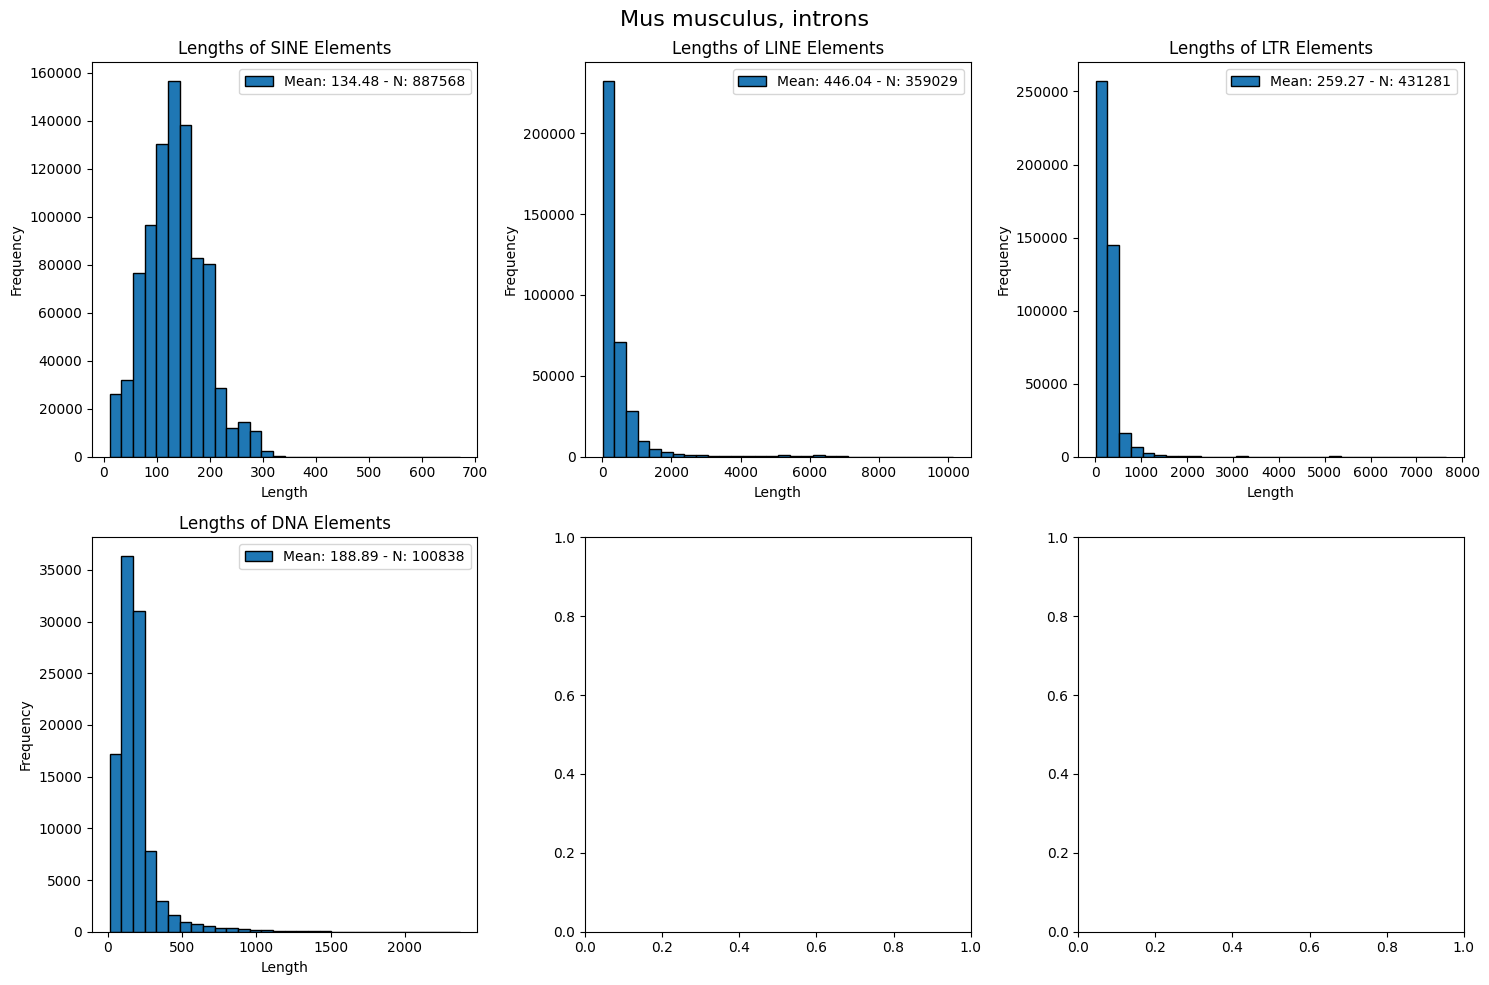

In [22]:
mm_intronic_lengths, mm_intronic_freqs = graph_data(m_musculus_introns, "Mus musculus, introns")

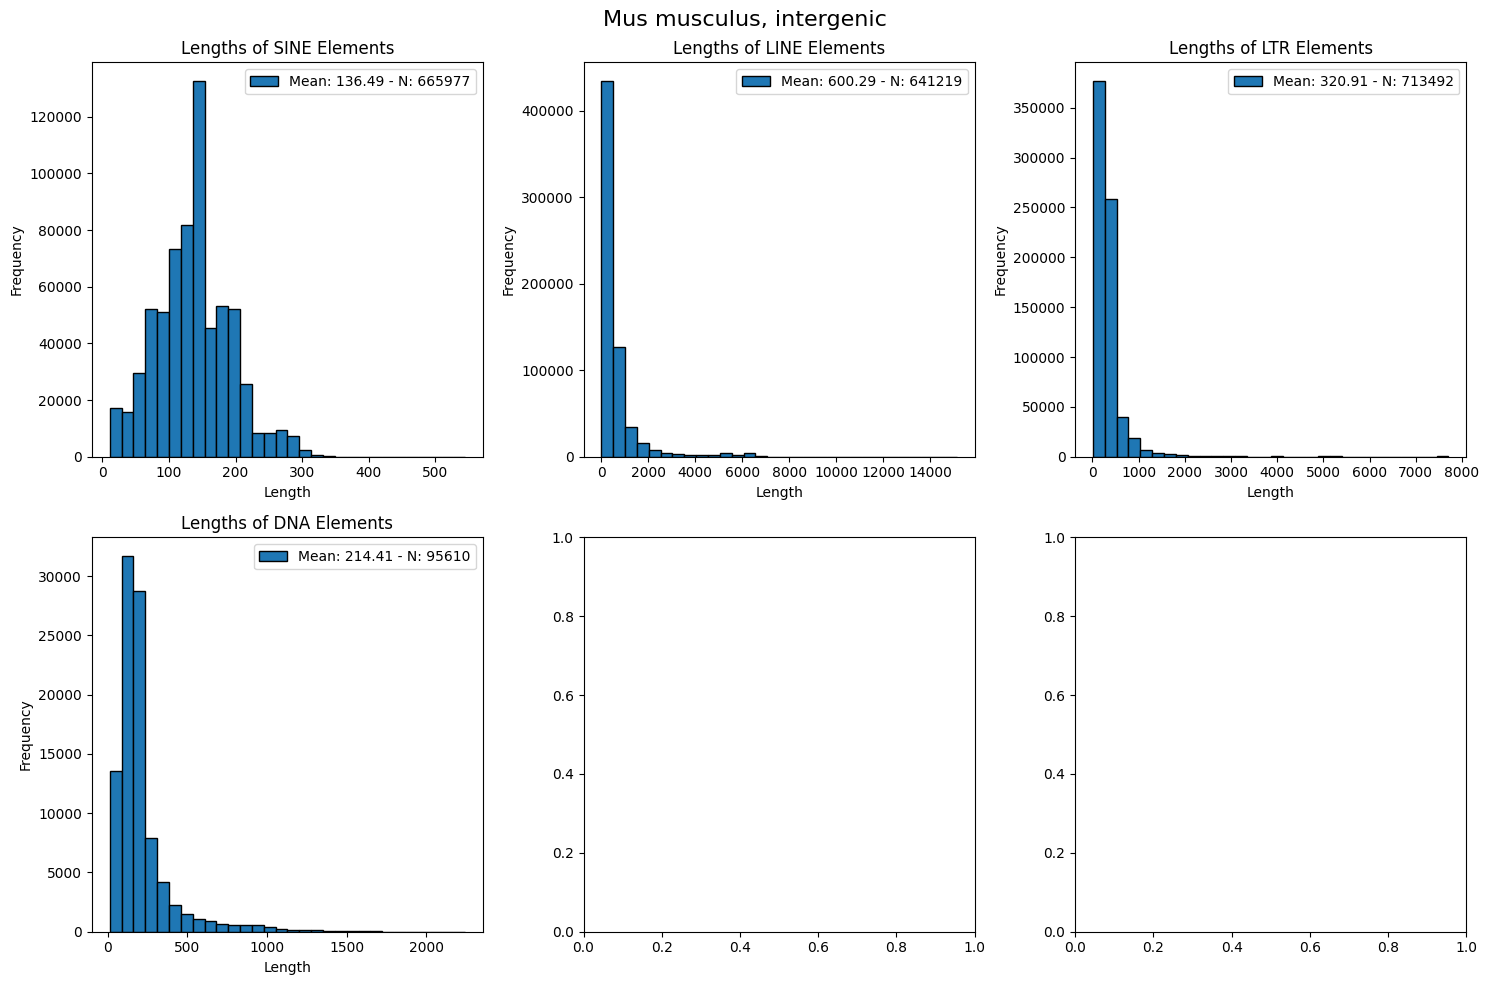

In [23]:
mm_intergenic_lengths, mm_intergenic_freqs = graph_data(m_musculus_intergenic, "Mus musculus, intergenic")

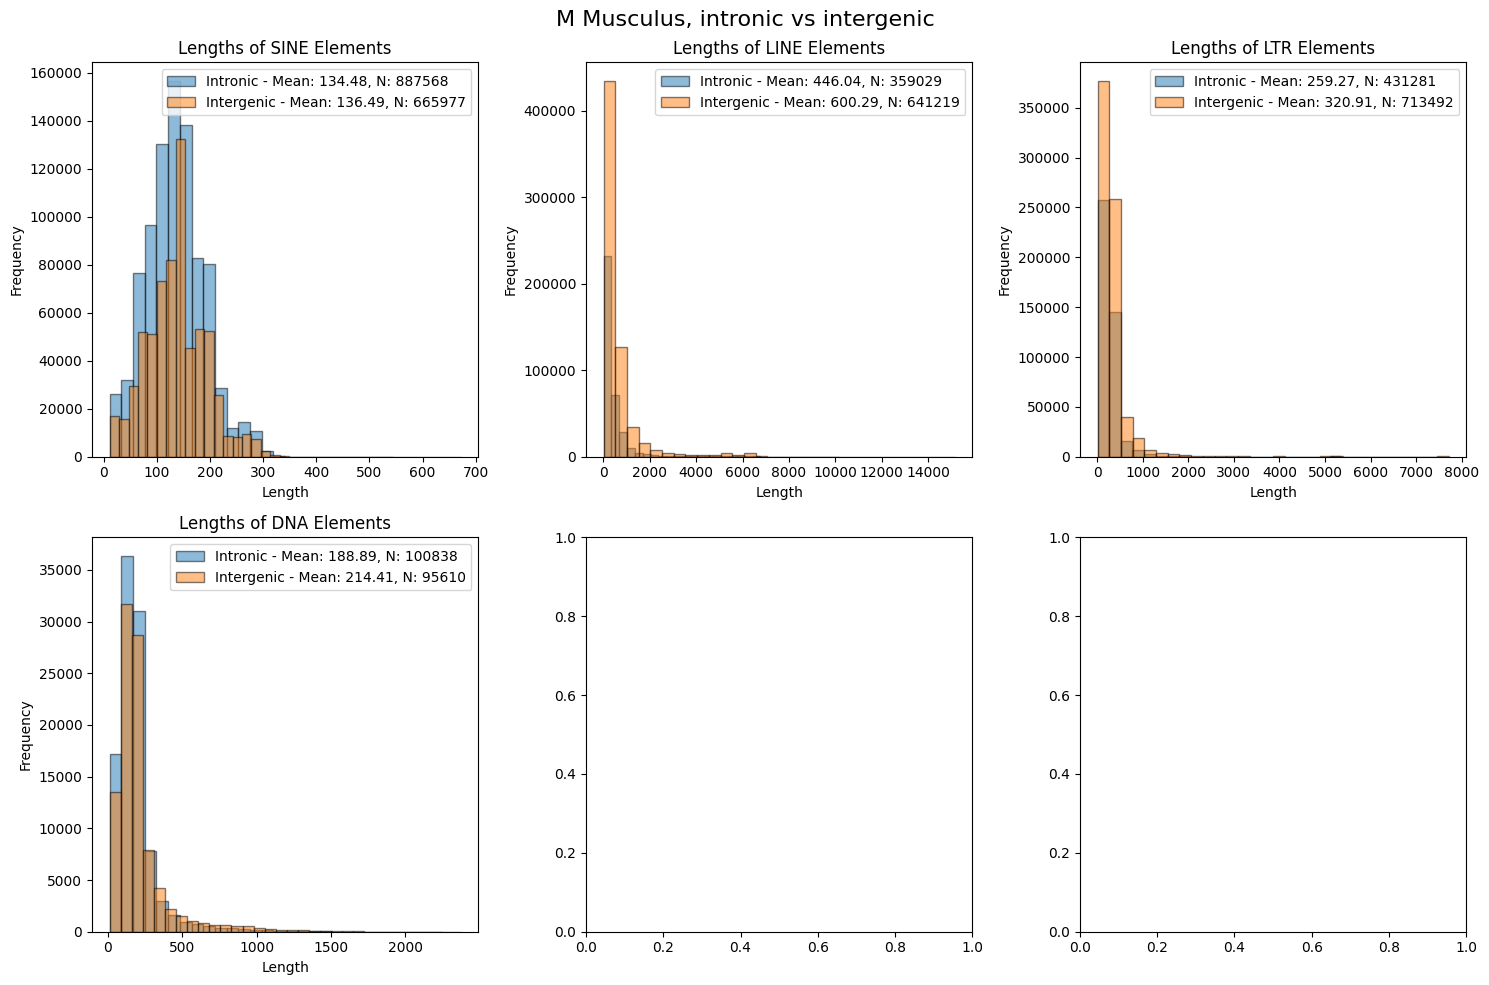

(([134.47878021740306,
   446.04446994532475,
   259.27060315664266,
   188.8914099843313],
  [887568, 359029, 431281, 100838]),
 ([136.49021062288938,
   600.2885301277722,
   320.9135267108811,
   214.4097688526305],
  [665977, 641219, 713492, 95610]))

In [24]:
graph_data_overlapping(m_musculus_introns, m_musculus_intergenic, "M Musculus, intronic vs intergenic")

In [25]:
t_test(m_musculus_introns, m_musculus_intergenic, titles)


Para SINE
Promedio 1: 134.47878021740306
Promedio 2: 136.49021062288938
Two-sample t-test
t-statistic: -22.530827034875387
p-value: 2.1585445843408716e-112
Reject the null hypothesis: The means are significantly different.

Para LINE
Promedio 1: 446.04446994532475
Promedio 2: 600.2885301277722
Two-sample t-test
t-statistic: -85.79499018131895
p-value: 0.0
Reject the null hypothesis: The means are significantly different.

Para LTR
Promedio 1: 259.27060315664266
Promedio 2: 320.9135267108811
Two-sample t-test
t-statistic: -82.47831760468519
p-value: 0.0
Reject the null hypothesis: The means are significantly different.

Para DNA
Promedio 1: 188.8914099843313
Promedio 2: 214.4097688526305
Two-sample t-test
t-statistic: -32.79191348681644
p-value: 3.335735238083727e-235
Reject the null hypothesis: The means are significantly different.


In [26]:
mm_occs_intronic, mm_occs_intergenic = occ_report(m_musculus_introns, m_musculus_fullintron, m_musculus_intergenic_size, m_musculus_intergenic)

Para SINE
Ocupancia en intrones : 0.10338282495548416
Ocupancia intergenica: 0.05793839561665082
Para LINE
Ocupancia en intrones : 0.1387077371516509
Ocupancia intergenica: 0.24534214499816193
Para LTR
Ocupancia en intrones : 0.09685155586714005
Ocupancia intergenica: 0.1459428629249743
Para DNA
Ocupancia en intrones : 0.016497928982614554
Ocupancia intergenica: 0.013066329837460295
En total en intrones: 0.3554400469568897
En total en intergenica: 0.4622897333772473


Cromosoma a cromosoma

In [27]:
mm_occs_per_chr_intronic = {}
mm_occs_per_chr_intergenic = {}
mm_freqs_per_chr_intronic = {}
mm_freqs_per_chr_intergenic = {}

for chr in mm_chr_lengths.keys():
    print(f"Para {chr}")
    df_chr_intron = process_tes(mm_introns_df[mm_introns_df[0]==chr])
    df_chr_intergenic = process_tes(mm_intergenic_df[mm_intergenic_df[0]==chr])
    df_chr_fullintron = sum(feat_len(mm_fullintron_df[mm_fullintron_df[0]==chr]))
    if df_chr_fullintron == 0:
        continue

    mini_intergenic_size = mm_chr_lengths[chr] - df_chr_fullintron

    mm_occs_per_chr_intronic[chr], mm_occs_per_chr_intergenic[chr] = occ_report(df_chr_intron, df_chr_fullintron, mini_intergenic_size, df_chr_intergenic)
    
    mm_freqs_per_chr_intronic[chr] = [len(el) for el in df_chr_intron]
    mm_freqs_per_chr_intergenic[chr] = [len(el) for el in df_chr_intergenic]

    print("\n")

Para NC_000067.7
Para SINE
Ocupancia en intrones : 0.09319924256076167
Ocupancia intergenica: 0.05894492722618648
Para LINE
Ocupancia en intrones : 0.14739772877951096
Ocupancia intergenica: 0.25510872168176346
Para LTR
Ocupancia en intrones : 0.10118404858516435
Ocupancia intergenica: 0.147292582353596
Para DNA
Ocupancia en intrones : 0.016331882577484143
Ocupancia intergenica: 0.013254917261205729
En total en intrones: 0.3581129025029211
En total en intergenica: 0.47460114852275165


Para NC_000068.8
Para SINE
Ocupancia en intrones : 0.10591273952130699
Ocupancia intergenica: 0.06365843063747569
Para LINE
Ocupancia en intrones : 0.12782584832697047
Ocupancia intergenica: 0.22260525268487977
Para LTR
Ocupancia en intrones : 0.09142153664190472
Ocupancia intergenica: 0.12909025185952114
Para DNA
Ocupancia en intrones : 0.01669350976395275
Ocupancia intergenica: 0.013724184049773259
En total en intrones: 0.34185363425413495
En total en intergenica: 0.42907811923164985


Para NC_000069.7

Preferencias en intrones vs intergenica, nivel genoma completo

In [28]:
mm_prefs = pref_intron_inter(mm_occs_intronic, mm_occs_intergenic)

[1.784357745069716, 0.565364491912672, 0.6636265311372512, 1.2626291535451748]


## En Homo Sapiens

In [29]:
# Cargar datos para homo sapiens
hs_pcgenes_df = pd.read_csv("results/homo_sapiens/em_per_gene.bed", sep="\t", header=None)
homo_sapiens_pcgenes = process_tes(hs_pcgenes_df)

hs_introns_df = pd.read_csv("results/homo_sapiens/em_per_intron.bed", sep="\t", header=None)
homo_sapiens_introns = process_tes(hs_introns_df)

hs_intergenic_df = pd.read_csv("results/homo_sapiens/em_intergenic.bed", sep="\t", header=None)
homo_sapiens_intergenic = process_tes(hs_intergenic_df)

hs_fullintron_df = pd.read_csv("results/homo_sapiens/introns.bed", sep="\t", header=None)
homo_sapiens_fullintron = sum(feat_len(hs_fullintron_df))

hs_fullgene_df = pd.read_csv("results/homo_sapiens/genes.bed", sep="\t", header=None)
h_sapiens_fullgene = sum(feat_len(hs_fullgene_df))

In [30]:
hs_chr_lengths = {"NC_000001.11":248956422,
                    "NC_000002.12":242193529,
                    "NC_000003.12":198295559,
                    "NC_000004.12":190214555,
                    "NC_000005.10":181538259,
                    "NC_000006.12":170805979,
                    "NC_000007.14":159345973,
                    "NC_000008.11":145138636,
                    "NC_000009.12":138394717,
                    "NC_000010.11":133797422,
                    "NC_000011.10":135086622,
                    "NC_000012.12":133275309,
                    "NC_000013.11":114364328,
                    "NC_000014.9":107043718,
                    "NC_000015.10":101991189,
                    "NC_000016.10":90338345,
                    "NC_000017.11":83257441,
                    "NC_000018.10":80373285,
                    "NC_000019.10":58617616,
                    "NC_000020.11":64444167,
                    "NC_000021.9":46709983,
                    "NC_000022.11":50818468,
                    "NC_000023.11":156040895,
                    "NC_000024.10":57227415,
                    "NC_012920.1":16569,
                    }
homo_sapiens_size = sum([len for len in hs_chr_lengths.values()])

In [31]:
#graph_data(homo_sapiens_pcgenes, "Human, pc_genes")

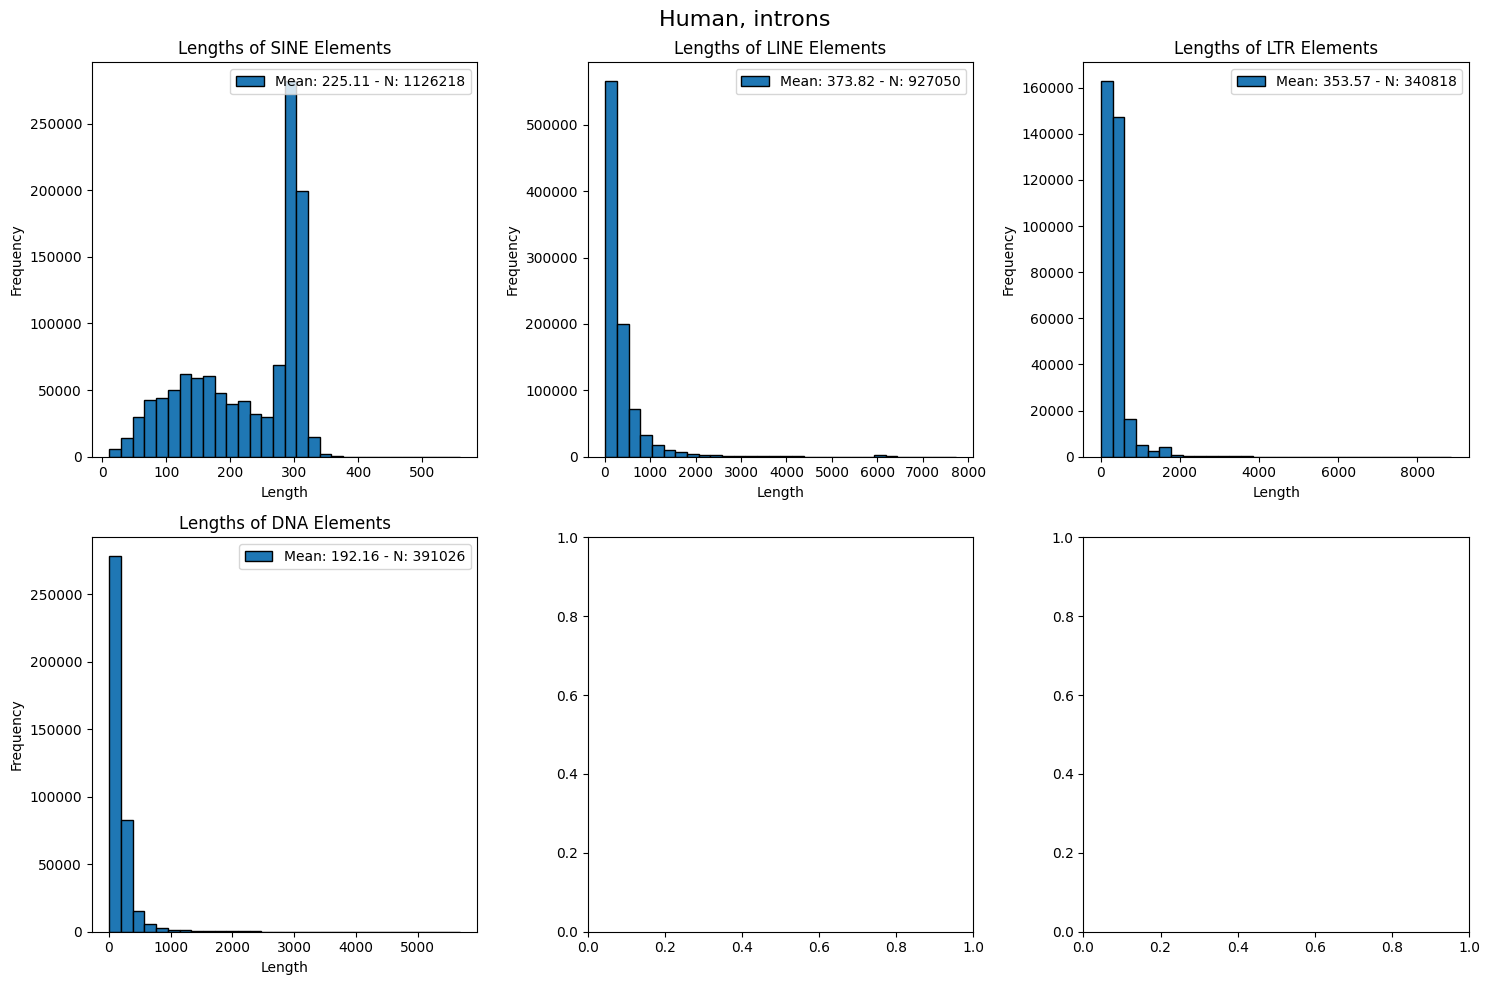

In [32]:
hs_intronic_lengths, hs_intronic_freqs = graph_data(homo_sapiens_introns, "Human, introns")

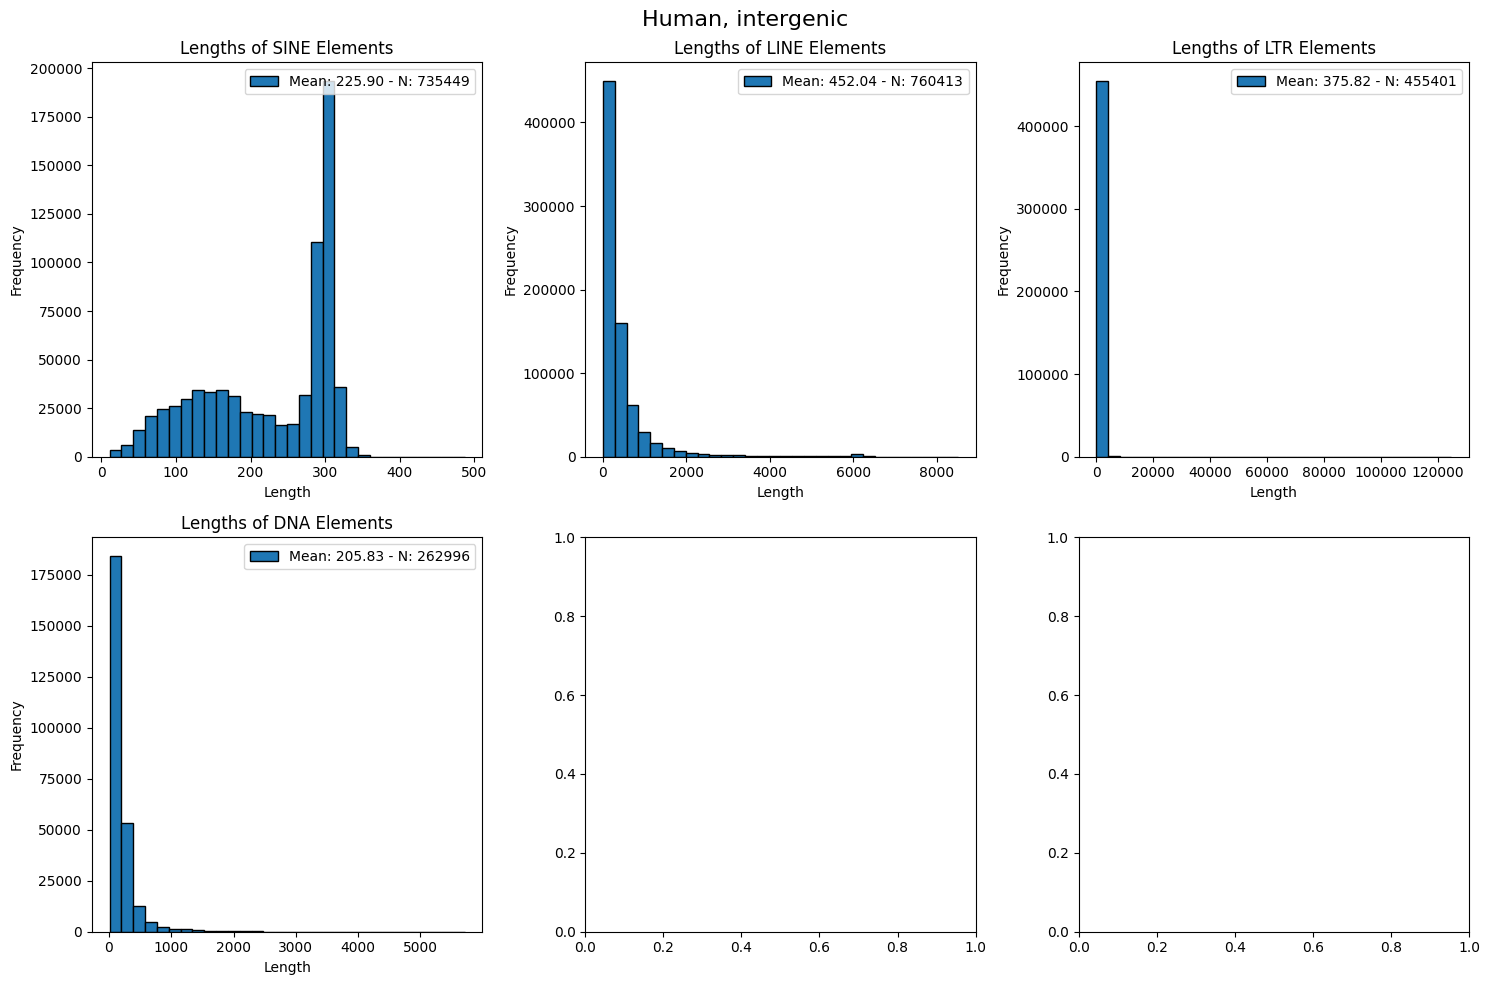

In [33]:
hs_intergenic_lengths, hs_intergenic_freqs = graph_data(homo_sapiens_intergenic, "Human, intergenic")

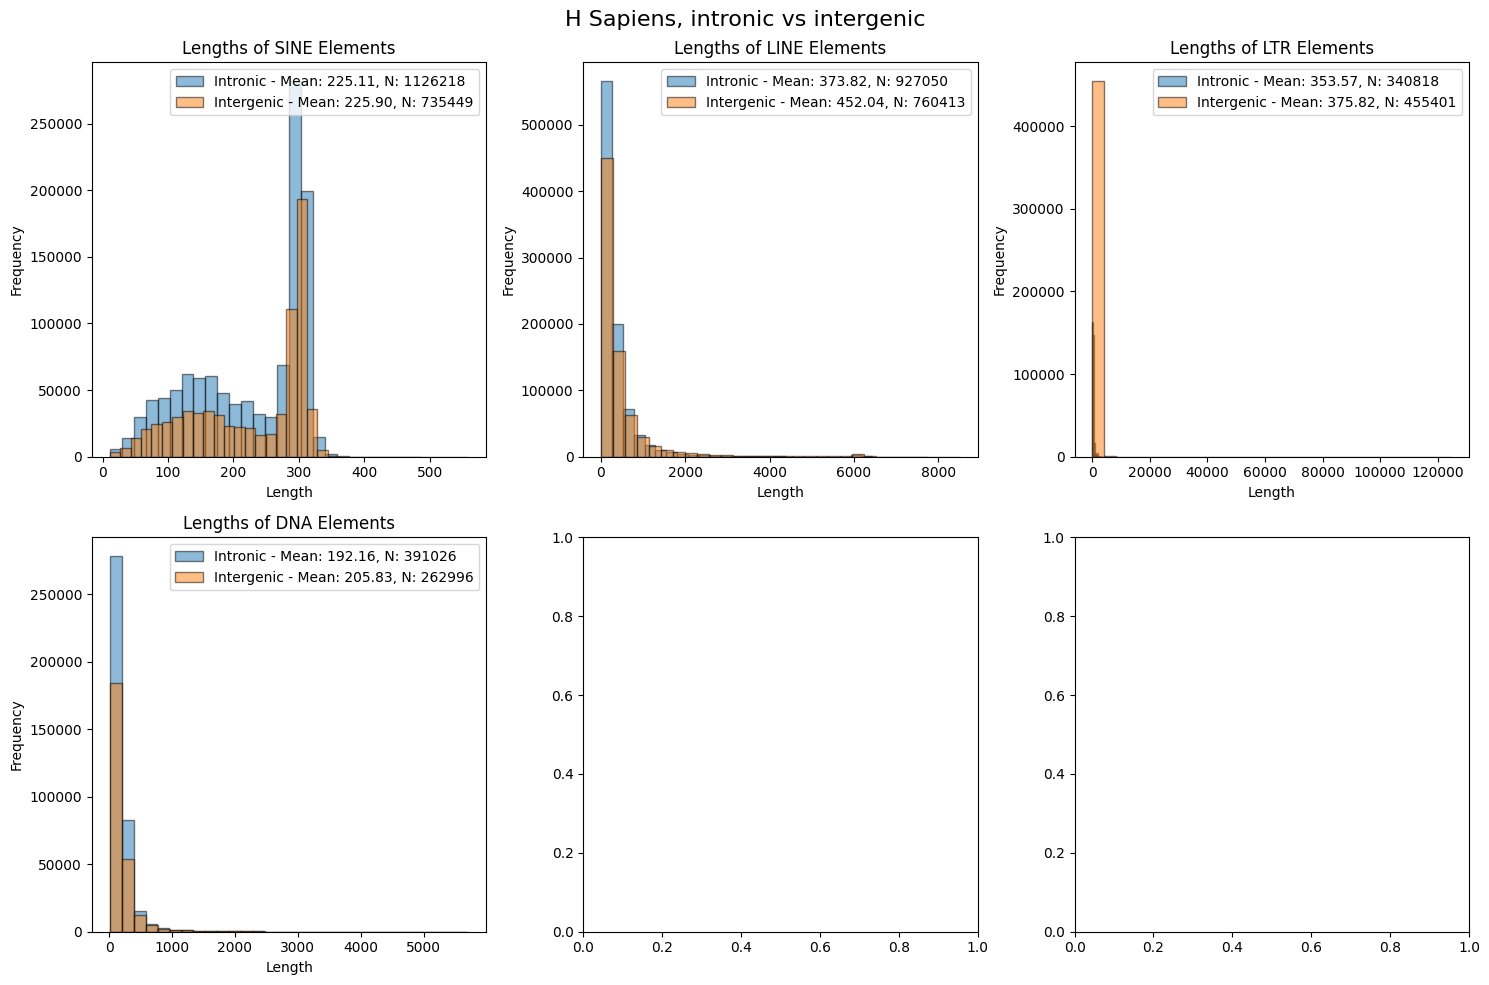

(([225.10726164916562,
   373.8198888948816,
   353.5716892887113,
   192.15895873931657],
  [1126218, 927050, 340818, 391026]),
 ([225.89699081785412,
   452.041436692955,
   375.8182283306361,
   205.82803540738263],
  [735449, 760413, 455401, 262996]))

In [34]:
graph_data_overlapping(homo_sapiens_introns, homo_sapiens_intergenic, "H Sapiens, intronic vs intergenic")

In [35]:
hs_occs_intronic, hs_occs_intergenic = occ_report(homo_sapiens_introns, homo_sapiens_fullintron, homo_sapiens_size, homo_sapiens_intergenic)

Para SINE
Ocupancia en intrones : 0.15068768575996522
Ocupancia intergenica: 0.053795436830665885
Para LINE
Ocupancia en intrones : 0.20598298915475619
Ocupancia intergenica: 0.11130385604414673
Para LTR
Ocupancia en intrones : 0.07162519229556896
Ocupancia intergenica: 0.055418434295660395
Para DNA
Ocupancia en intrones : 0.04466137256227946
Ocupancia intergenica: 0.017528150880848307
En total en intrones: 0.4729572397725698
En total en intergenica: 0.23804587805132132


In [36]:
t_test(homo_sapiens_introns, homo_sapiens_intergenic, titles)


Para SINE
Promedio 1: 225.10726164916562
Promedio 2: 225.89699081785412
Two-sample t-test
t-statistic: -6.0899720835671145
p-value: 1.1295235238904782e-09
Reject the null hypothesis: The means are significantly different.

Para LINE
Promedio 1: 373.8198888948816
Promedio 2: 452.041436692955
Two-sample t-test
t-statistic: -76.4703109853707
p-value: 0.0
Reject the null hypothesis: The means are significantly different.

Para LTR
Promedio 1: 353.5716892887113
Promedio 2: 375.8182283306361
Two-sample t-test
t-statistic: -22.436850059703172
p-value: 1.8630328548755574e-111
Reject the null hypothesis: The means are significantly different.

Para DNA
Promedio 1: 192.15895873931657
Promedio 2: 205.82803540738263
Two-sample t-test
t-statistic: -23.865232507790573
p-value: 7.968197164694681e-126
Reject the null hypothesis: The means are significantly different.


Cromosoma a cromosoma

In [37]:
hs_occs_per_chr_intronic = {}
hs_occs_per_chr_intergenic = {}
hs_freqs_per_chr_intronic = {}
hs_freqs_per_chr_intergenic = {}

for chr in hs_chr_lengths.keys():
    print(f"Para {chr}")
    df_chr_intron = process_tes(hs_introns_df[hs_introns_df[0]==chr])
    df_chr_intergenic = process_tes(hs_intergenic_df[hs_intergenic_df[0]==chr])
    df_chr_fullintron = sum(feat_len(hs_fullintron_df[hs_fullintron_df[0]==chr]))
    if df_chr_fullintron == 0:
        continue

    mini_intergenic_size = hs_chr_lengths[chr] - df_chr_fullintron

    hs_occs_per_chr_intronic[chr], hs_occs_per_chr_intergenic[chr] = occ_report(df_chr_intron, df_chr_fullintron, mini_intergenic_size, df_chr_intergenic)

    hs_freqs_per_chr_intronic[chr] = [len(el) for el in df_chr_intron]
    hs_freqs_per_chr_intergenic[chr] = [len(el) for el in df_chr_intergenic]

    print("\n")

Para NC_000001.11
Para SINE
Ocupancia en intrones : 0.1656710137881916
Ocupancia intergenica: 0.11146044237706385
Para LINE
Ocupancia en intrones : 0.20798103839470294
Ocupancia intergenica: 0.18949026281469786
Para LTR
Ocupancia en intrones : 0.06715023409836945
Ocupancia intergenica: 0.09639939549013804
Para DNA
Ocupancia en intrones : 0.043819326180443464
Ocupancia intergenica: 0.032626516178659505
En total en intrones: 0.48462161246170743
En total en intergenica: 0.4299766168605592


Para NC_000002.12
Para SINE
Ocupancia en intrones : 0.12904064053239384
Ocupancia intergenica: 0.10186006821275463
Para LINE
Ocupancia en intrones : 0.21141453832520496
Ocupancia intergenica: 0.23784176115000272
Para LTR
Ocupancia en intrones : 0.07093124221606487
Ocupancia intergenica: 0.11544085147455639
Para DNA
Ocupancia en intrones : 0.04685016570018853
Ocupancia intergenica: 0.041294254776073146
En total en intrones: 0.4582365867738522
En total en intergenica: 0.49643693561338686


Para NC_000003

In [38]:
hs_prefs = pref_intron_inter(hs_occs_intronic, hs_occs_intergenic)

[2.801123936111739, 1.8506365949536971, 1.2924434478506668, 2.54797969653933]


## En A. Thaliana

In [39]:
# Cargar datos para a thaliana

at_pcgenes_df = pd.read_csv("results/a_thaliana/em_per_gene.bed", sep="\t", header=None)
a_thaliana_pcgenes = process_tes(at_pcgenes_df)

at_introns_df = pd.read_csv("results/a_thaliana/em_per_intron.bed", sep="\t", header=None)
a_thaliana_introns = process_tes(at_introns_df)

at_intergenic_df = pd.read_csv("results/a_thaliana/em_intergenic.bed", sep="\t", header=None)
a_thaliana_intergenic = process_tes(at_intergenic_df)

at_fullintron_df = pd.read_csv("results/a_thaliana/introns.bed", sep="\t", header=None)
a_thaliana_fullintron = sum(feat_len(at_fullintron_df))

at_fullgene_df = pd.read_csv("results/a_thaliana/genes.bed", sep="\t", header=None)
a_thaliana_fullgene = sum(feat_len(at_fullgene_df))

In [40]:
at_chr_lengths = {"NC_003070.9":30427671,
                    "NC_003071.7":19698289,
                    "NC_003074.8":23459830,
                    "NC_003075.7":18585056,
                    "NC_003076.8":26975502,
                    "NC_037304.1":367808,
                    "NC_000932.1":154478,}
a_thaliana_size = sum([len for len in at_chr_lengths.values()])

In [41]:
#graph_data(a_thaliana_pcgenes, "A thaliana, pcgenes")

In [42]:
at_intronic_lengths, at_intronic_freqs = graph_data(a_thaliana_introns, "A thaliana, introns")

In [43]:
at_intergenic_lengths, at_intergenic_freqs = graph_data(a_thaliana_intergenic, "A thaliana, intergenic")

In [44]:
graph_data_overlapping(a_thaliana_introns, a_thaliana_intergenic, "A thaliana, intronic vs intergenic")

(([0, 127.23287671232876, 167.60162601626016, 267.36538461538464],
  [0, 73, 123, 52]),
 ([0, 611.8808882907133, 1018.7462008237467, 662.1926298157454],
  [0, 1486, 7041, 3582]))

In [45]:
at_occs_intronic, at_occs_intergenic = occ_report(a_thaliana_introns, a_thaliana_fullintron, a_thaliana_size, a_thaliana_intergenic)

Para SINE
Ocupancia en intrones : 0.0
Ocupancia intergenica: 0.0
Para LINE
Ocupancia en intrones : 0.0005061344277345972
Ocupancia intergenica: 0.007598106284057693
Para LTR
Ocupancia en intrones : 0.001123380838474238
Ocupancia intergenica: 0.05994045189819749
Para DNA
Ocupancia en intrones : 0.0007576213338494946
Ocupancia intergenica: 0.019821183886832034
En total en intrones: 0.0023871366000583296
En total en intergenica: 0.08735974206908721


In [46]:
t_test(a_thaliana_introns, a_thaliana_intergenic, titles)


Para SINE
Promedio 1: nan
Promedio 2: nan
Two-sample t-test
t-statistic: nan
p-value: nan
Fail to reject the null hypothesis: The means are not significantly different.

Para LINE
Promedio 1: 127.23287671232876
Promedio 2: 611.8808882907133
Two-sample t-test
t-statistic: -5.472793832291473
p-value: 5.1552224040146585e-08
Reject the null hypothesis: The means are significantly different.

Para LTR
Promedio 1: 167.60162601626016
Promedio 2: 1018.7462008237467
Two-sample t-test
t-statistic: -6.9426597816481825
p-value: 4.185286100303396e-12
Reject the null hypothesis: The means are significantly different.

Para DNA
Promedio 1: 267.36538461538464
Promedio 2: 662.1926298157454
Two-sample t-test
t-statistic: -3.3018692459999572
p-value: 0.0009697172569304798
Reject the null hypothesis: The means are significantly different.


/home/seba/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/seba/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Cromosoma a cromosoma

In [47]:
at_occs_per_chr_intronic = {}
at_occs_per_chr_intergenic = {}
at_freqs_per_chr_intronic = {}
at_freqs_per_chr_intergenic = {}

for chr in at_chr_lengths.keys():
    print(f"Para {chr}")
    df_chr_intron = process_tes(at_introns_df[at_introns_df[0]==chr])
    df_chr_intergenic = process_tes(at_intergenic_df[at_intergenic_df[0]==chr])
    df_chr_fullintron = sum(feat_len(at_fullintron_df[at_fullintron_df[0]==chr]))
    if df_chr_fullintron == 0:
        continue

    mini_intergenic_size = at_chr_lengths[chr] - df_chr_fullintron

    at_occs_per_chr_intronic[chr], at_occs_per_chr_intergenic[chr] = occ_report(df_chr_intron, df_chr_fullintron, mini_intergenic_size, df_chr_intergenic)

    at_freqs_per_chr_intronic[chr] = [len(el) for el in df_chr_intron]
    at_freqs_per_chr_intergenic[chr] = [len(el) for el in df_chr_intergenic]

    print("\n")

Para NC_003070.9
Para SINE
Ocupancia en intrones : 0.0
Ocupancia intergenica: 0.0
Para LINE
Ocupancia en intrones : 0.0006094385544763088
Ocupancia intergenica: 0.006317001032624366
Para LTR
Ocupancia en intrones : 0.0014485147003811699
Ocupancia intergenica: 0.05236160636340372
Para DNA
Ocupancia en intrones : 0.0010525737286831856
Ocupancia intergenica: 0.01741475600871374
En total en intrones: 0.0031105269835406645
En total en intergenica: 0.07609336340474183


Para NC_003071.7
Para SINE
Ocupancia en intrones : 0.0
Ocupancia intergenica: 0.0
Para LINE
Ocupancia en intrones : 0.0006723641241896088
Ocupancia intergenica: 0.014678268842573906
Para LTR
Ocupancia en intrones : 0.0016141014746046253
Ocupancia intergenica: 0.07664132849515984
Para DNA
Ocupancia en intrones : 0.001039011015440858
Ocupancia intergenica: 0.032311940711496616
En total en intrones: 0.0033254766142350924
En total en intergenica: 0.12363153804923036


Para NC_003074.8
Para SINE
Ocupancia en intrones : 0.0
Ocupanc

In [48]:
at_prefs = pref_intron_inter(at_occs_intronic, at_occs_intergenic)

[None, 0.06661323345746897, 0.01874161443397493, 0.038222809403065536]


## En Drosophila melanogaster

In [49]:
# Cargar datos para drosphila

dm_pcgenes_df = pd.read_csv("results/dros_melanogaster/em_per_gene.bed", sep="\t", header=None)
dros_pcgenes = process_tes(dm_pcgenes_df)

dm_introns_df = pd.read_csv("results/dros_melanogaster/em_per_intron.bed", sep="\t", header=None)
dros_introns = process_tes(dm_introns_df)

dm_intergenic_df = pd.read_csv("results/dros_melanogaster/em_intergenic.bed", sep="\t", header=None)
dros_intergenic = process_tes(dm_intergenic_df)

dm_fullintron_df = pd.read_csv("results/dros_melanogaster/introns.bed", sep="\t", header=None)
dros_fullintron = sum(feat_len(dm_fullintron_df))

dm_fullgene_df = pd.read_csv("results/dros_melanogaster/genes.bed", sep="\t", header=None)
dros_fullgene = sum(feat_len(dm_fullgene_df))

In [50]:
dm_chr_lengths = {"NC_004354.4": 23542271,
                    "NT_033779.5": 23513712,
                    "NT_033778.4": 25286936,
                    "NT_037436.4": 28110227,
                    "NT_033777.3": 32079331,
                    "NC_004353.4": 1348131,
                    "NC_024512.1": 3667352,
                    "NC_024511.2": 19524,}
dros_size = sum([len for len in dm_chr_lengths.values()])

In [51]:
#graph_data(dros_pcgenes, "Drosophila, pcgenes")

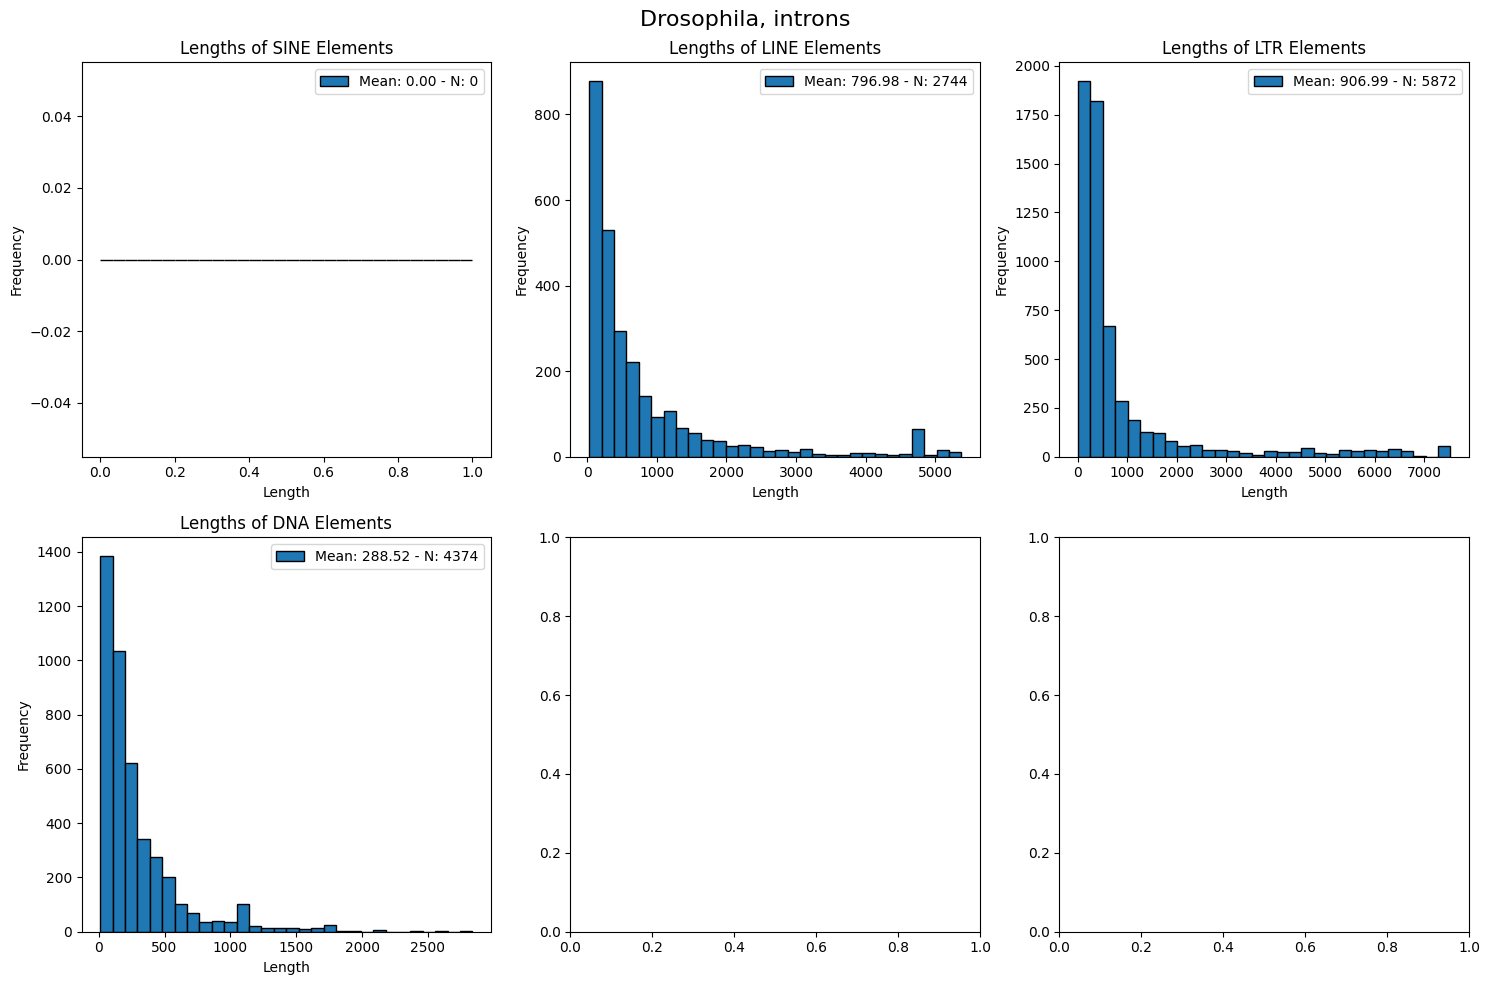

In [52]:
dm_intronic_lengths, dm_intronic_freqs = graph_data(dros_introns, "Drosophila, introns")

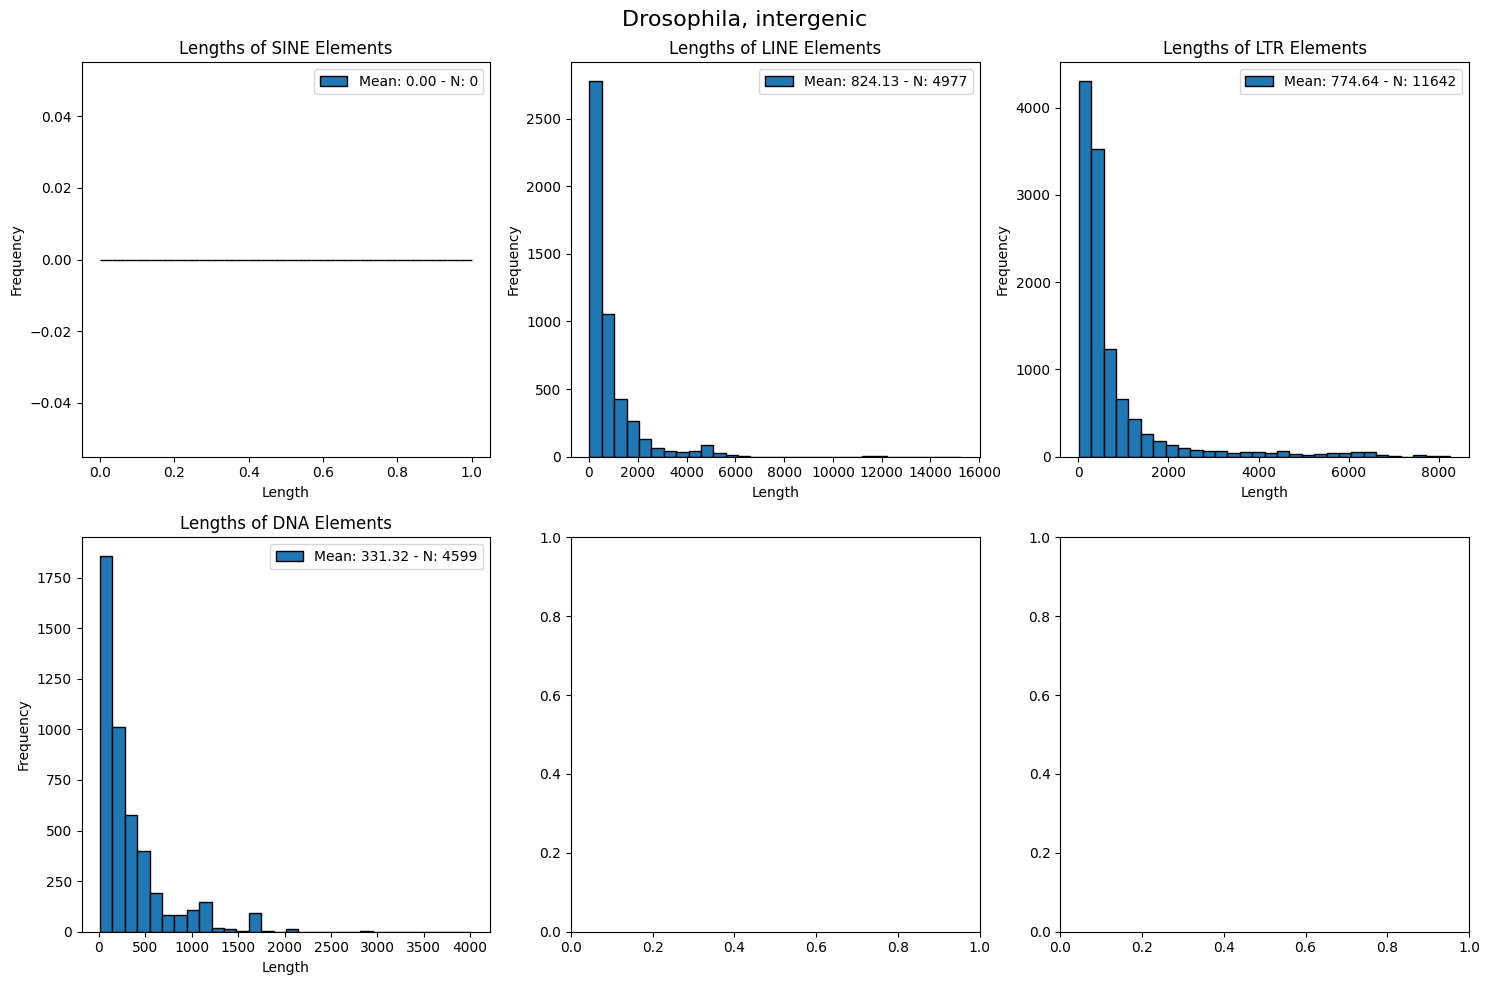

In [53]:
dm_intergenic_lengths, dm_intergenic_freqs = graph_data(dros_intergenic, "Drosophila, intergenic")

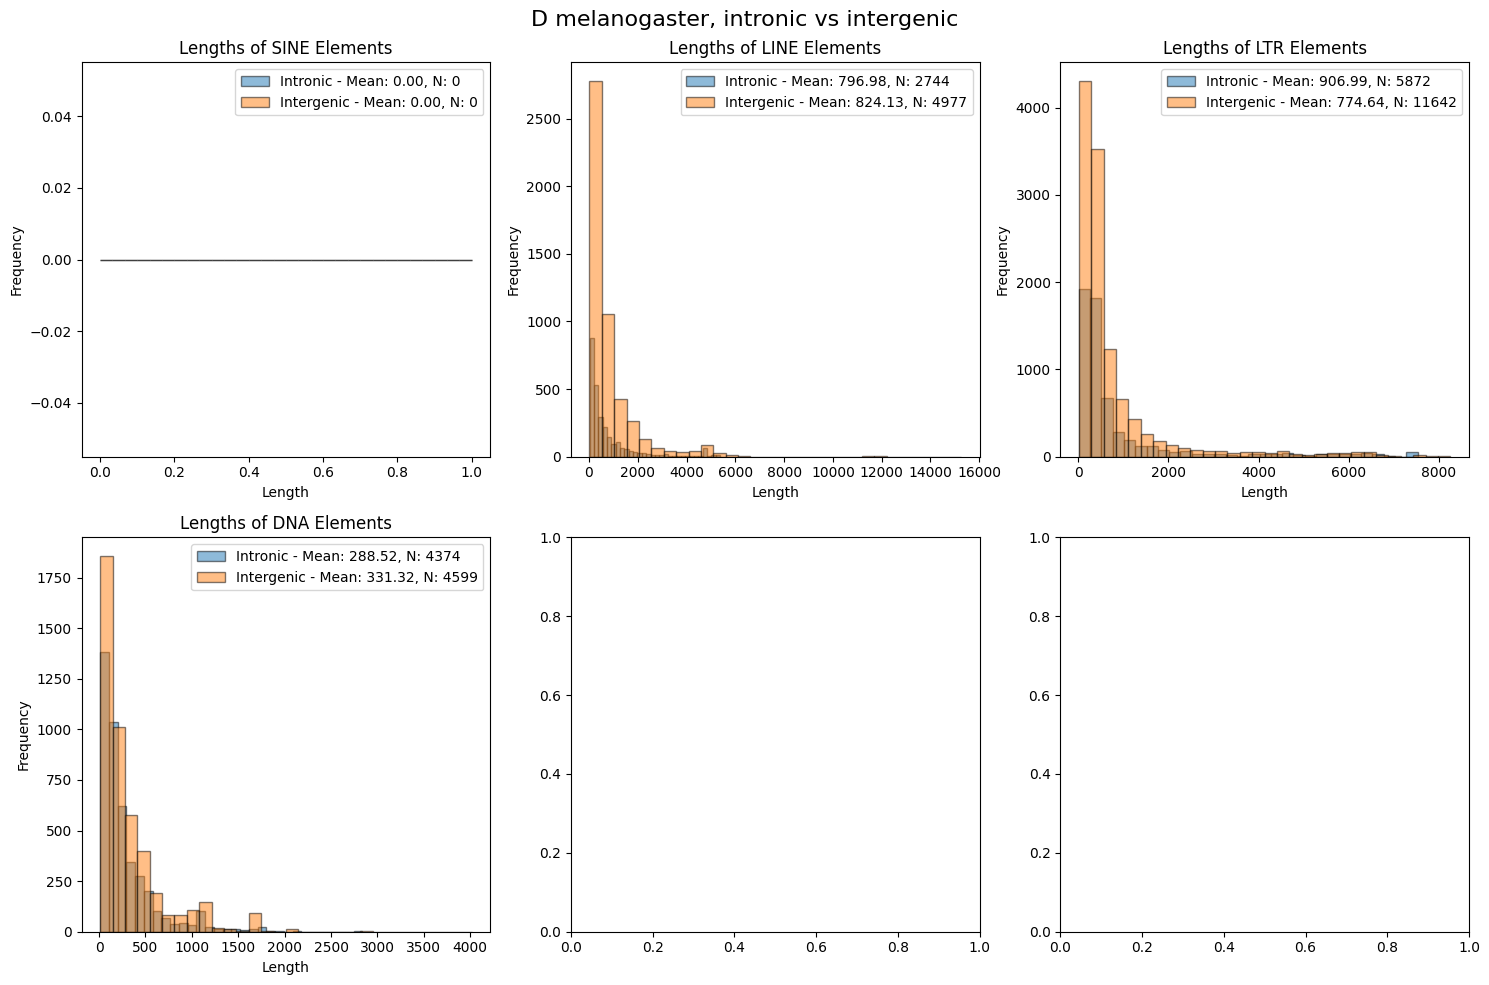

(([0, 796.9795918367347, 906.9919959128065, 288.52217649748513],
  [0, 2744, 5872, 4374]),
 ([0, 824.1269841269841, 774.6364885758461, 331.31963470319636],
  [0, 4977, 11642, 4599]))

In [54]:
graph_data_overlapping(dros_introns, dros_intergenic, "D melanogaster, intronic vs intergenic")

In [55]:
dm_occs_intronic, dm_occs_intergenic = occ_report(dros_introns, dros_fullintron, dros_size, dros_intergenic)

Para SINE
Ocupancia en intrones : 0.0
Ocupancia intergenica: 0.0
Para LINE
Ocupancia en intrones : 0.03558128343323122
Ocupancia intergenica: 0.029815766638575728
Para LTR
Ocupancia en intrones : 0.08665224181030537
Ocupancia intergenica: 0.0655555930644192
Para DNA
Ocupancia en intrones : 0.02053280487171138
Ocupancia intergenica: 0.011076302013344955
En total en intrones: 0.14276633011524797
En total en intergenica: 0.10644766171633989


In [56]:
t_test(dros_introns, dros_intergenic, titles)


Para SINE
Promedio 1: nan
Promedio 2: nan
Two-sample t-test
t-statistic: nan
p-value: nan
Fail to reject the null hypothesis: The means are not significantly different.

Para LINE
Promedio 1: 796.9795918367347
Promedio 2: 824.1269841269841
Two-sample t-test
t-statistic: -1.0387907528540752
p-value: 0.2989346004548029
Fail to reject the null hypothesis: The means are not significantly different.

Para LTR
Promedio 1: 906.9919959128065
Promedio 2: 774.6364885758461
Two-sample t-test
t-statistic: 6.4559088652715735
p-value: 1.1039783454859969e-10
Reject the null hypothesis: The means are significantly different.

Para DNA
Promedio 1: 288.52217649748513
Promedio 2: 331.31963470319636
Two-sample t-test
t-statistic: -5.7735928054246095
p-value: 8.017997797231342e-09
Reject the null hypothesis: The means are significantly different.


/home/seba/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/seba/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Cromosoma a cromosoma

In [57]:
dm_occs_per_chr_intronic = {}
dm_occs_per_chr_intergenic = {}
dm_freqs_per_chr_intronic = {}
dm_freqs_per_chr_intergenic = {}

for chr in dm_chr_lengths.keys():
    print(f"Para {chr}")
    df_chr_intron = process_tes(dm_introns_df[dm_introns_df[0]==chr])
    df_chr_intergenic = process_tes(dm_intergenic_df[dm_intergenic_df[0]==chr])
    df_chr_fullintron = sum(feat_len(dm_fullintron_df[dm_fullintron_df[0]==chr]))
    if df_chr_fullintron == 0:
        continue

    mini_intergenic_size = dm_chr_lengths[chr] - df_chr_fullintron

    dm_occs_per_chr_intronic[chr], dm_occs_per_chr_intergenic[chr] = occ_report(df_chr_intron, df_chr_fullintron, mini_intergenic_size, df_chr_intergenic)

    dm_freqs_per_chr_intronic[chr] = [len(el) for el in df_chr_intron]
    dm_freqs_per_chr_intergenic[chr] = [len(el) for el in df_chr_intergenic]

    print("\n")

Para NC_004354.4
Para SINE
Ocupancia en intrones : 0.0
Ocupancia intergenica: 0.0
Para LINE
Ocupancia en intrones : 0.007228879327017953
Ocupancia intergenica: 0.045231335200394567
Para LTR
Ocupancia en intrones : 0.05004184502295002
Ocupancia intergenica: 0.06130914331201401
Para DNA
Ocupancia en intrones : 0.010472811061116352
Ocupancia intergenica: 0.011329173994275007
En total en intrones: 0.06774353541108433
En total en intergenica: 0.11786965250668358


Para NT_033779.5
Para SINE
Ocupancia en intrones : 0.0
Ocupancia intergenica: 0.0
Para LINE
Ocupancia en intrones : 0.01705981131822247
Ocupancia intergenica: 0.016976651219346005
Para LTR
Ocupancia en intrones : 0.04423624630874039
Ocupancia intergenica: 0.05486048136334912
Para DNA
Ocupancia en intrones : 0.013141921281054672
Ocupancia intergenica: 0.013630625290423177
En total en intrones: 0.07443797890801754
En total en intergenica: 0.0854677578731183


Para NT_033778.4
Para SINE
Ocupancia en intrones : 0.0
Ocupancia intergeni

In [58]:
dm_prefs = pref_intron_inter(dm_occs_intronic, dm_occs_intergenic)

[None, 1.1933714086424345, 1.3218131018226809, 1.8537599324190543]


## En C elegans

In [59]:
# Cargar datos para c_elegans

ce_pcgenes_df = pd.read_csv("results/c_elegans/em_per_gene.bed", sep="\t", header=None)
elegans_pcgenes = process_tes(ce_pcgenes_df)

ce_introns_df = pd.read_csv("results/c_elegans/em_per_intron.bed", sep="\t", header=None)
elegans_introns = process_tes(ce_introns_df)

ce_intergenic_df = pd.read_csv("results/c_elegans/em_intergenic.bed", sep="\t", header=None)
elegans_intergenic = process_tes(ce_intergenic_df)

ce_fullintron_df = pd.read_csv("results/c_elegans/introns.bed", sep="\t", header=None)
elegans_fullintron = sum(feat_len(ce_fullintron_df))

ce_fullgene_df = pd.read_csv("results/c_elegans/genes.bed", sep="\t", header=None)
elegans_fullgene = sum(feat_len(ce_fullgene_df))

In [60]:
ce_chr_lengths = {"NC_003279.8": 15072434,
                    "NC_003280.10": 15279421,
                    "NC_003281.10": 13783801,
                    "NC_003282.8": 17493829,
                    "NC_003283.11": 20924180,
                    "NC_003284.9": 17718942,
                    "NC_001328.1": 13794,}
elegans_size = sum([len for len in ce_chr_lengths.values()])

In [61]:
#graph_data(elegans_pcgenes, "C elegans, pcgenes")

In [62]:
ce_intronic_lengths, ce_intronic_freqs = graph_data(elegans_introns, "C elegans, introns")

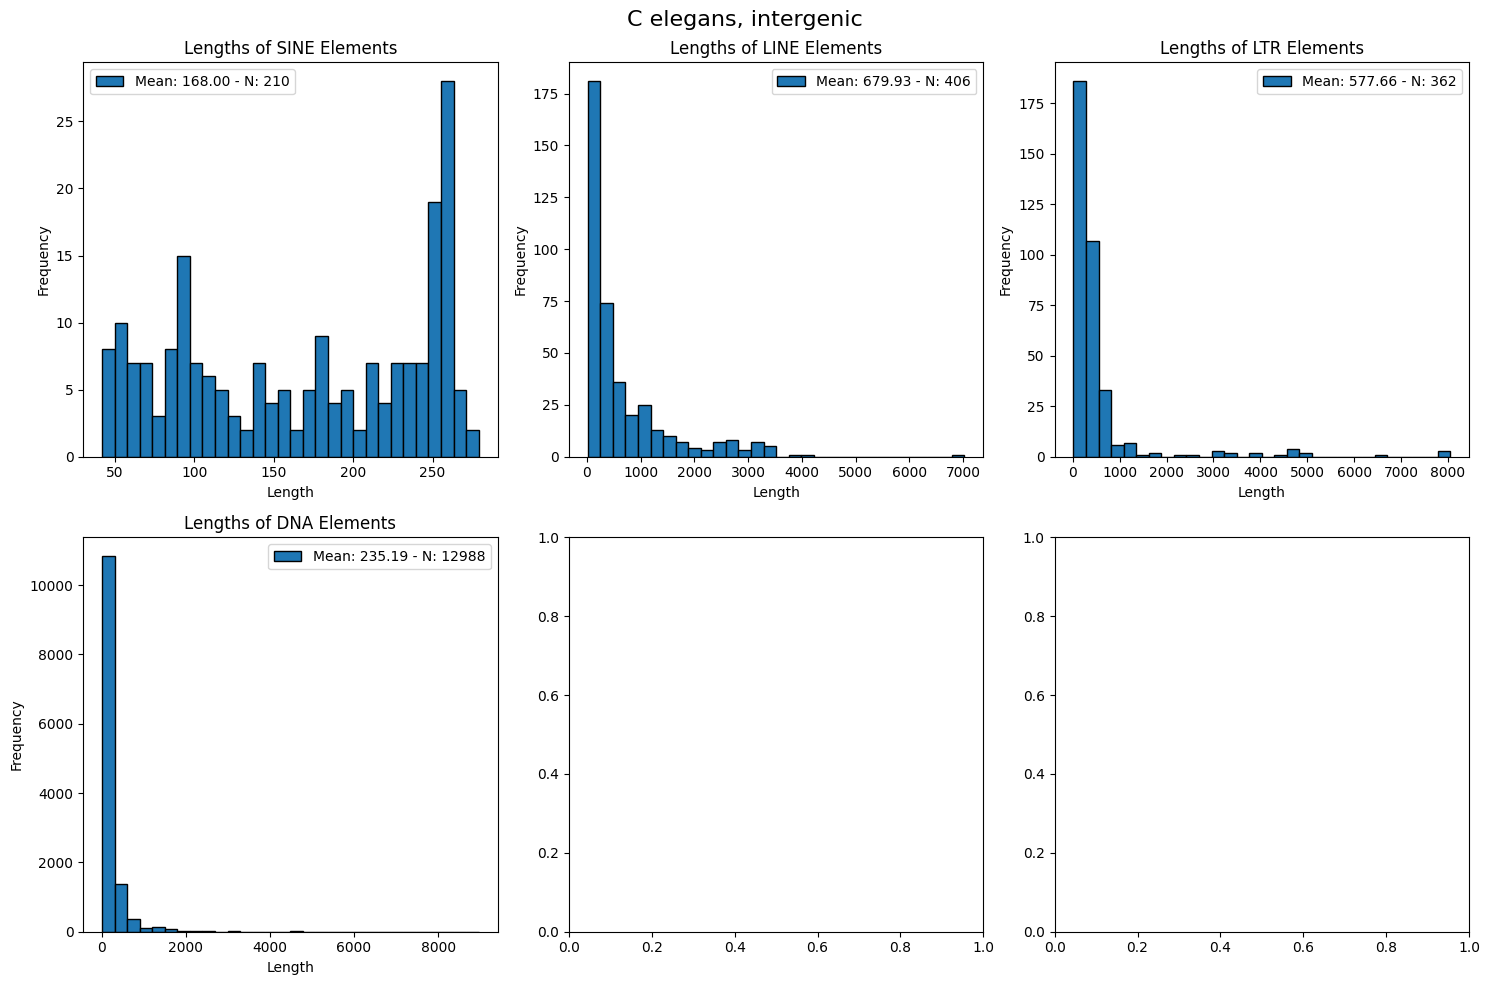

In [63]:
ce_intergenic_lengths, ce_intergenic_freqs = graph_data(elegans_intergenic, "C elegans, intergenic")

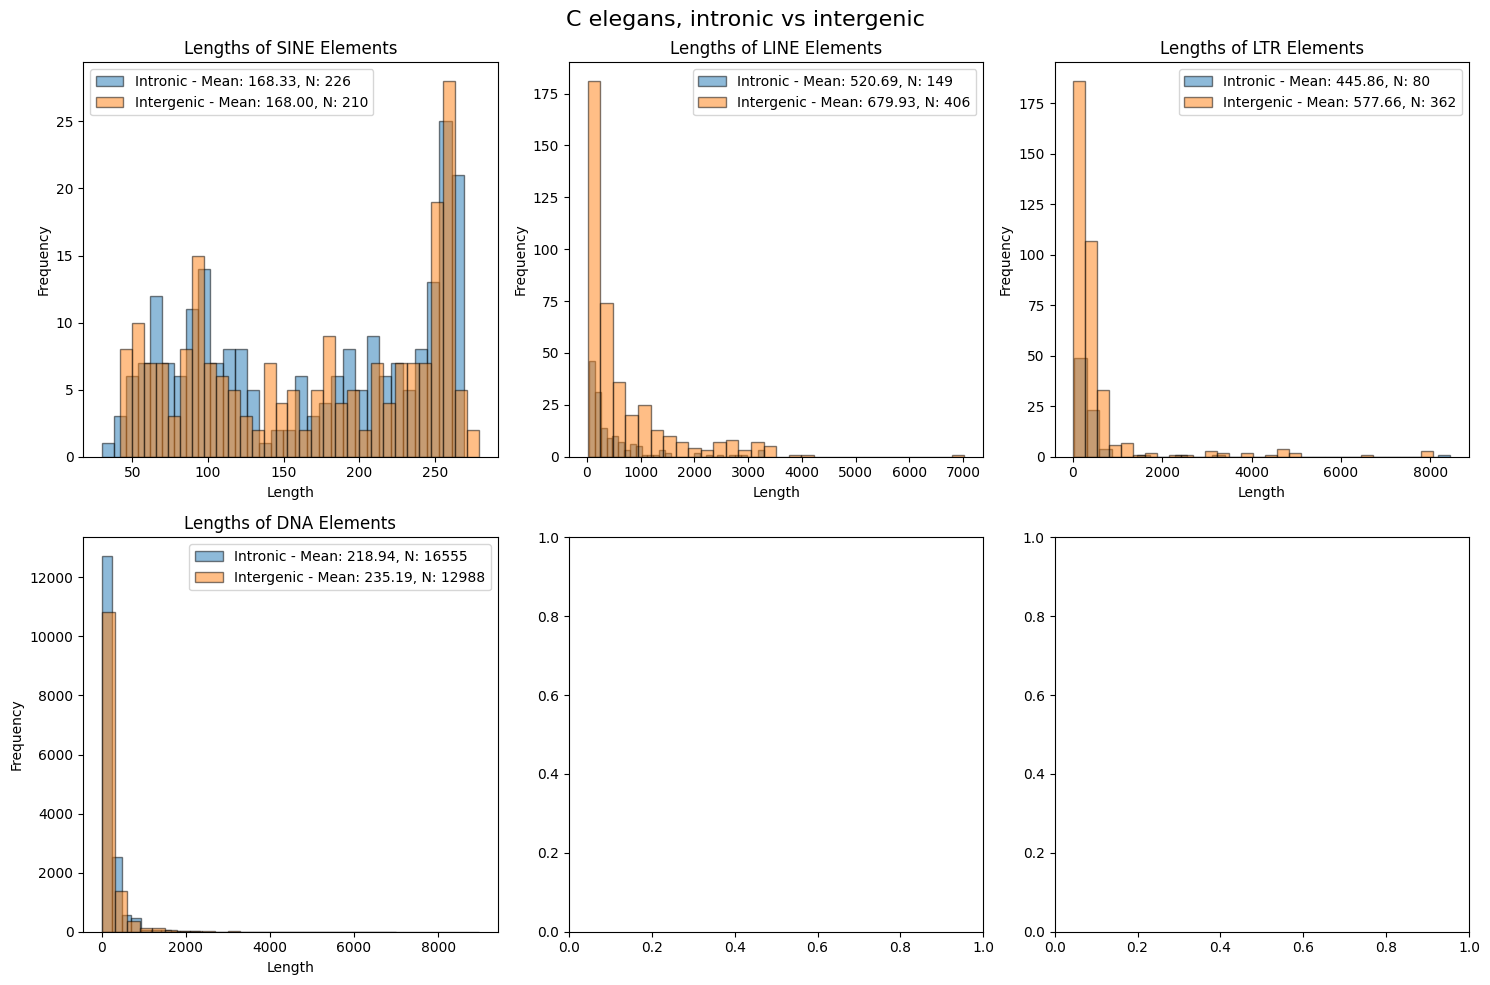

(([168.32743362831857, 520.6912751677852, 445.8625, 218.93506493506493],
  [226, 149, 80, 16555]),
 ([168.0, 679.9261083743843, 577.6602209944751, 235.19464120726823],
  [210, 406, 362, 12988]))

In [64]:
graph_data_overlapping(elegans_introns, elegans_intergenic, "C elegans, intronic vs intergenic")

In [65]:
t_test(elegans_introns, elegans_intergenic, titles)


Para SINE
Promedio 1: 168.32743362831857
Promedio 2: 168.0
Two-sample t-test
t-statistic: 0.044830298283929454
p-value: 0.9642631940282647
Fail to reject the null hypothesis: The means are not significantly different.

Para LINE
Promedio 1: 520.6912751677852
Promedio 2: 679.9261083743843
Two-sample t-test
t-statistic: -1.9879845439952528
p-value: 0.04730602877165789
Reject the null hypothesis: The means are significantly different.

Para LTR
Promedio 1: 445.8625
Promedio 2: 577.6602209944751
Two-sample t-test
t-statistic: -0.994043851083664
p-value: 0.32074785806283135
Fail to reject the null hypothesis: The means are not significantly different.

Para DNA
Promedio 1: 218.93506493506493
Promedio 2: 235.19464120726823
Two-sample t-test
t-statistic: -4.403286237883417
p-value: 1.0699740443978155e-05
Reject the null hypothesis: The means are significantly different.


In [66]:
ce_occs_intronic, ce_occs_intergenic = occ_report(elegans_introns, elegans_fullintron, elegans_size, elegans_intergenic)

Para SINE
Ocupancia en intrones : 0.0011566810569198242
Ocupancia intergenica: 0.0003517924628684202
Para LINE
Ocupancia en intrones : 0.0023589397623419044
Ocupancia intergenica: 0.002752616478878328
Para LTR
Ocupancia en intrones : 0.0010845291156951057
Ocupancia intergenica: 0.002085158086389001
Para DNA
Ocupancia en intrones : 0.11020334867709887
Ocupancia intergenica: 0.030459842705891898
En total en intrones: 0.1148034986120557
En total en intergenica: 0.035649409734027644


Cromosoma a cromosoma

In [67]:
ce_occs_per_chr_intronic = {}
ce_occs_per_chr_intergenic = {}
ce_freqs_per_chr_intronic = {}
ce_freqs_per_chr_intergenic = {}

for chr in ce_chr_lengths.keys():
    print(f"Para {chr}")
    df_chr_intron = process_tes(ce_introns_df[ce_introns_df[0]==chr])
    df_chr_intergenic = process_tes(ce_intergenic_df[ce_intergenic_df[0]==chr])
    df_chr_fullintron = sum(feat_len(ce_fullintron_df[ce_fullintron_df[0]==chr]))
    if df_chr_fullintron == 0:
        continue

    mini_intergenic_size = ce_chr_lengths[chr] - df_chr_fullintron

    ce_occs_per_chr_intronic[chr], ce_occs_per_chr_intergenic[chr] = occ_report(df_chr_intron, df_chr_fullintron, mini_intergenic_size, df_chr_intergenic)

    ce_freqs_per_chr_intronic[chr] = [len(el) for el in df_chr_intron]
    ce_freqs_per_chr_intergenic[chr] = [len(el) for el in df_chr_intergenic]

    print("\n")

Para NC_003279.8
Para SINE
Ocupancia en intrones : 0.000805952025822516
Ocupancia intergenica: 0.0003470600042743875
Para LINE
Ocupancia en intrones : 0.004071827219109944
Ocupancia intergenica: 0.003079386782849554
Para LTR
Ocupancia en intrones : 0.0006897667296393197
Ocupancia intergenica: 0.0017912348190151446
Para DNA
Ocupancia en intrones : 0.12706598239759376
Ocupancia intergenica: 0.04593997601630389
En total en intrones: 0.13263352837216555
En total en intergenica: 0.05115765762244298


Para NC_003280.10
Para SINE
Ocupancia en intrones : 0.0006287797148866359
Ocupancia intergenica: 0.0002549213054619373
Para LINE
Ocupancia en intrones : 0.0009442317002267218
Ocupancia intergenica: 0.0035935863880536024
Para LTR
Ocupancia en intrones : 0.00031757624113362183
Ocupancia intergenica: 0.0022154033006397153
Para DNA
Ocupancia en intrones : 0.10253336621681301
Ocupancia intergenica: 0.049070223015941335
En total en intrones: 0.10442395387306
En total en intergenica: 0.055134134010096

In [68]:
ce_prefs = pref_intron_inter(ce_occs_intronic, ce_occs_intergenic)

[3.287964294313076, 0.8569809054195432, 0.5201184134548056, 3.6179881078565796]


## Gráfico nuevo de tamaño vs proporcion

In [69]:
mm_intronic_lengths
mm_intronic_freqs
mm_occs_intronic

intronic_normalized = [el/sum(mm_intronic_freqs) for el in mm_intronic_freqs]

# Create the plot
plt.scatter(mm_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(mm_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic frequency normalized')
plt.title('MM intronic length vs normalized frequency')

# Show the plot
plt.show()

In [70]:
intronic_normalized = [el/sum(hs_intronic_freqs) for el in hs_intronic_freqs]

# Create the plot
plt.scatter(hs_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(hs_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic frequency normalized')
plt.title('HS intronic length vs normalized frequency')

# Show the plot
plt.show()

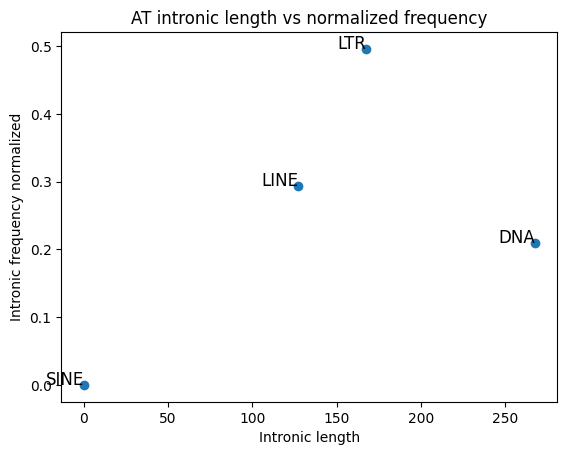

In [71]:
intronic_normalized = [el/sum(at_intronic_freqs) for el in at_intronic_freqs]

# Create the plot
plt.scatter(at_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(at_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic frequency normalized')
plt.title('AT intronic length vs normalized frequency')

# Show the plot
plt.show()

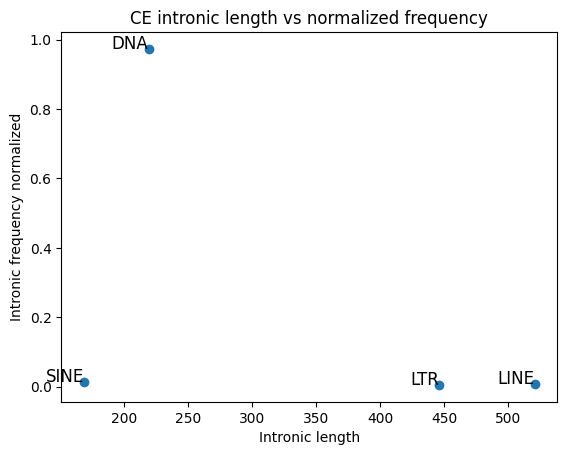

In [72]:
intronic_normalized = [el/sum(ce_intronic_freqs) for el in ce_intronic_freqs]

# Create the plot
plt.scatter(ce_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(ce_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic frequency normalized')
plt.title('CE intronic length vs normalized frequency')

# Show the plot
plt.show()

In [73]:
intronic_normalized = [el/sum(dm_intronic_freqs) for el in dm_intronic_freqs]

# Create the plot
plt.scatter(dm_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(dm_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic frequency normalized')
plt.title('DM intronic length vs normalized frequency')

# Show the plot
plt.show()

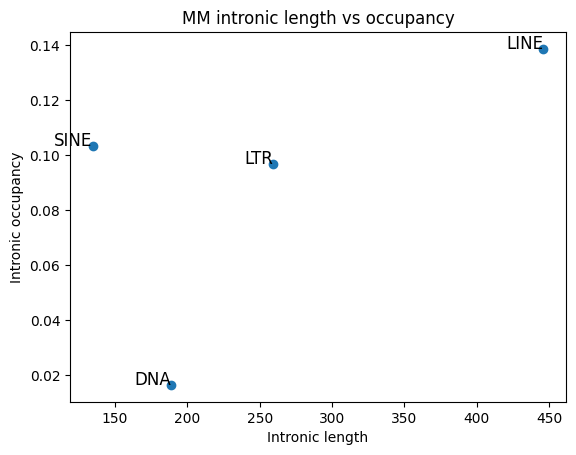

In [74]:
mm_intronic_lengths
mm_intronic_freqs
mm_occs_intronic

#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intronic_normalized = mm_occs_intronic

# Create the plot
plt.scatter(mm_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(mm_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic occupancy')
plt.title('MM intronic length vs occupancy')

# Show the plot
plt.show()

In [75]:
#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intronic_normalized = hs_occs_intronic

# Create the plot
plt.scatter(hs_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(hs_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic occupancy')
plt.title('HS intronic length vs occupancy')

# Show the plot
plt.show()

In [76]:
#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intronic_normalized = at_occs_intronic

# Create the plot
plt.scatter(at_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(at_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic occupancy')
plt.title('AT intronic length vs occupancy')

# Show the plot
plt.show()

In [77]:
#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intronic_normalized = ce_occs_intronic

# Create the plot
plt.scatter(ce_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(ce_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic occupancy')
plt.title('CE intronic length vs occupancy')

# Show the plot
plt.show()

In [78]:
#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intronic_normalized = dm_occs_intronic

# Create the plot
plt.scatter(dm_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(dm_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic occupancy')
plt.title('DM intronic length vs occupancy')

# Show the plot
plt.show()

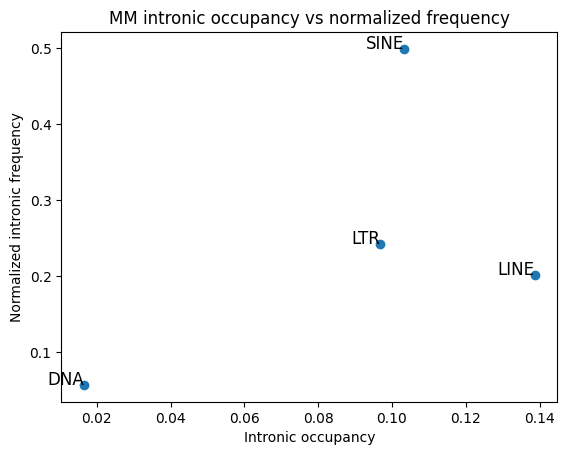

In [79]:

intronic_normalized = [el/sum(mm_intronic_freqs) for el in mm_intronic_freqs]

# Create the plot
plt.scatter(mm_occs_intronic, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(mm_occs_intronic[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic occupancy')
plt.ylabel('Normalized intronic frequency')
plt.title('MM intronic occupancy vs normalized frequency')

# Show the plot
plt.show()

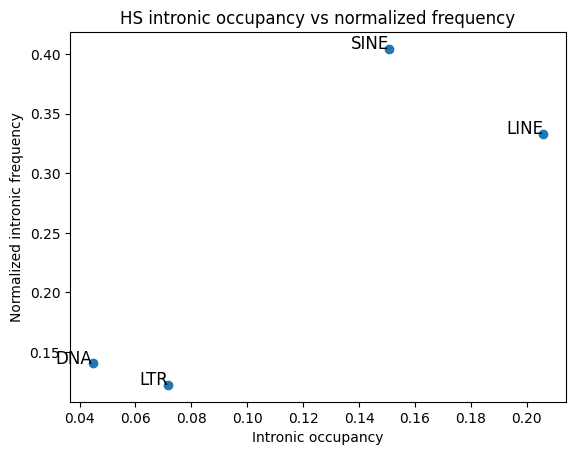

In [80]:
intronic_normalized = [el/sum(hs_intronic_freqs) for el in hs_intronic_freqs]

# Create the plot
plt.scatter(hs_occs_intronic, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(hs_occs_intronic[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic occupancy')
plt.ylabel('Normalized intronic frequency')
plt.title('HS intronic occupancy vs normalized frequency')

# Show the plot
plt.show()

In [81]:
intronic_normalized = [el/sum(at_intronic_freqs) for el in at_intronic_freqs]

# Create the plot
plt.scatter(at_occs_intronic, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(at_occs_intronic[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic occupancy')
plt.ylabel('Normalized intronic frequency')
plt.title('AT intronic occupancy vs normalized frequency')

# Show the plot
plt.show()

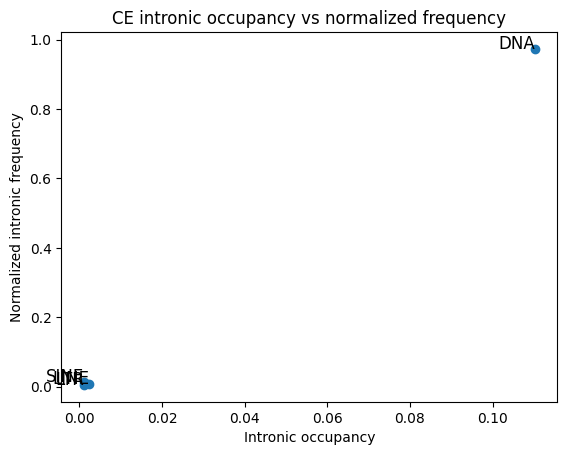

In [82]:
intronic_normalized = [el/sum(ce_intronic_freqs) for el in ce_intronic_freqs]

# Create the plot
plt.scatter(ce_occs_intronic, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(ce_occs_intronic[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic occupancy')
plt.ylabel('Normalized intronic frequency')
plt.title('CE intronic occupancy vs normalized frequency')

# Show the plot
plt.show()

In [83]:
intronic_normalized = [el/sum(dm_intronic_freqs) for el in dm_intronic_freqs]

# Create the plot
plt.scatter(dm_occs_intronic, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(dm_occs_intronic[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic occupancy')
plt.ylabel('Normalized intronic frequency')
plt.title('DM intronic occupancy vs normalized frequency')

# Show the plot
plt.show()

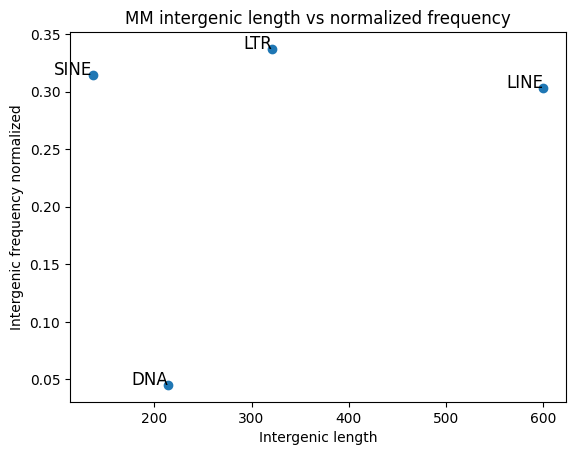

In [84]:
mm_intergenic_lengths
mm_intergenic_freqs
mm_occs_intergenic

intergenic_normalized = [el/sum(mm_intergenic_freqs) for el in mm_intergenic_freqs]

# Create the plot
plt.scatter(mm_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(mm_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic frequency normalized')
plt.title('MM intergenic length vs normalized frequency')

# Show the plot
plt.show()

In [85]:
intergenic_normalized = [el/sum(hs_intergenic_freqs) for el in hs_intergenic_freqs]

# Create the plot
plt.scatter(hs_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(hs_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic frequency normalized')
plt.title('HS intergenic length vs normalized frequency')

# Show the plot
plt.show()

In [86]:
intergenic_normalized = [el/sum(at_intergenic_freqs) for el in at_intergenic_freqs]

# Create the plot
plt.scatter(at_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(at_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic frequency normalized')
plt.title('AT intergenic length vs normalized frequency')

# Show the plot
plt.show()

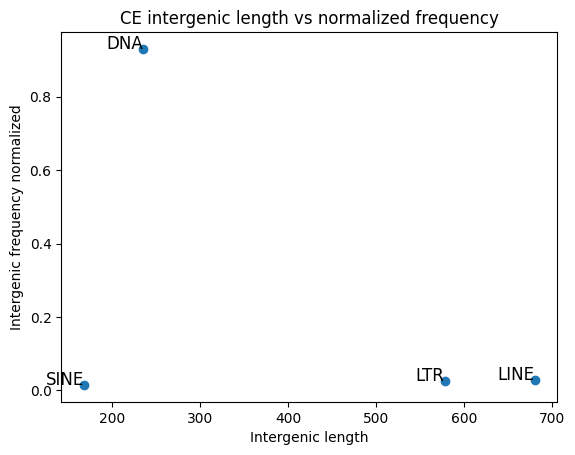

In [87]:
intergenic_normalized = [el/sum(ce_intergenic_freqs) for el in ce_intergenic_freqs]

# Create the plot
plt.scatter(ce_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(ce_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic frequency normalized')
plt.title('CE intergenic length vs normalized frequency')

# Show the plot
plt.show()

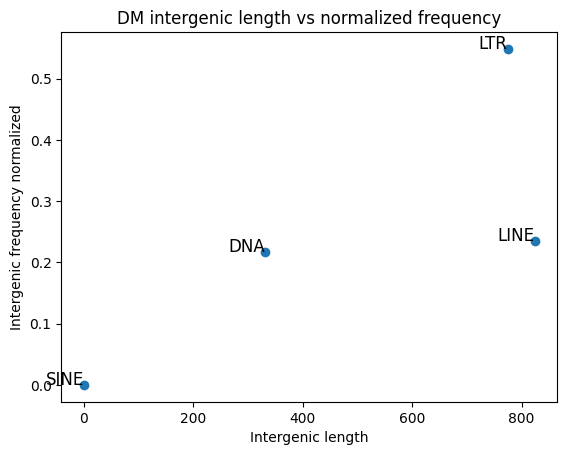

In [88]:
intergenic_normalized = [el/sum(dm_intergenic_freqs) for el in dm_intergenic_freqs]

# Create the plot
plt.scatter(dm_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(dm_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic frequency normalized')
plt.title('DM intergenic length vs normalized frequency')

# Show the plot
plt.show()

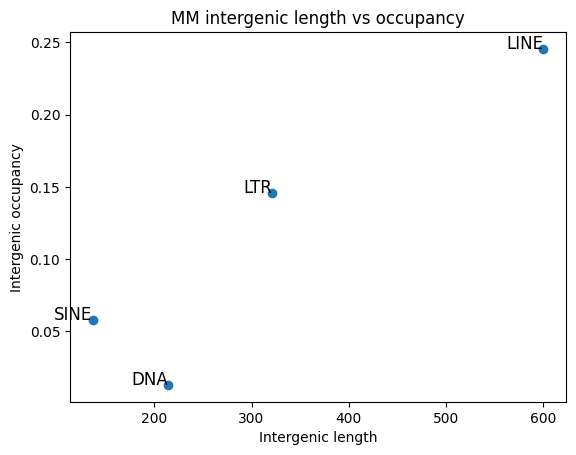

In [89]:
#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intergenic_normalized = mm_occs_intergenic

# Create the plot
plt.scatter(mm_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(mm_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic occupancy')
plt.title('MM intergenic length vs occupancy')

# Show the plot
plt.show()

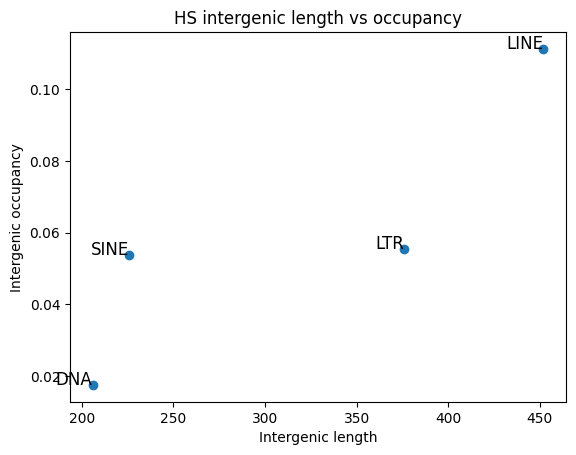

In [90]:
#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intergenic_normalized = hs_occs_intergenic

# Create the plot
plt.scatter(hs_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(hs_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic occupancy')
plt.title('HS intergenic length vs occupancy')

# Show the plot
plt.show()

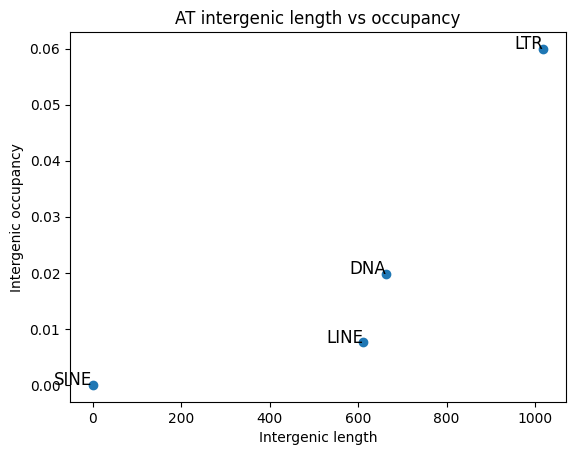

In [91]:
#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intergenic_normalized = at_occs_intergenic

# Create the plot
plt.scatter(at_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(at_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic occupancy')
plt.title('AT intergenic length vs occupancy')

# Show the plot
plt.show()

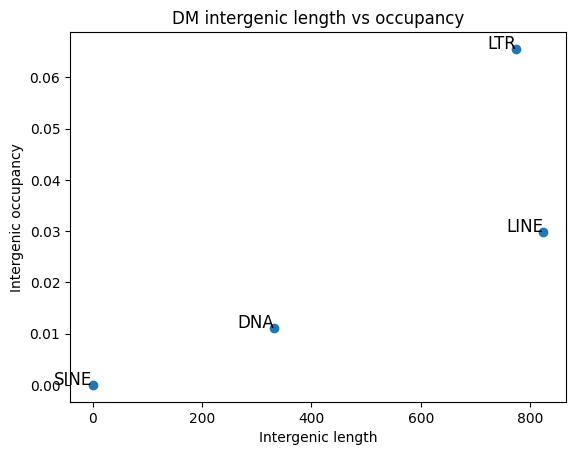

In [92]:
#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intergenic_normalized = dm_occs_intergenic

# Create the plot
plt.scatter(dm_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(dm_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic occupancy')
plt.title('DM intergenic length vs occupancy')

# Show the plot
plt.show()

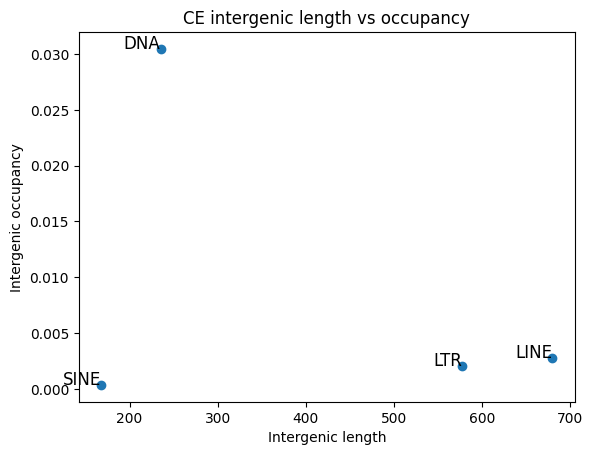

In [93]:
#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intergenic_normalized = ce_occs_intergenic

# Create the plot
plt.scatter(ce_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(ce_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic occupancy')
plt.title('CE intergenic length vs occupancy')

# Show the plot
plt.show()

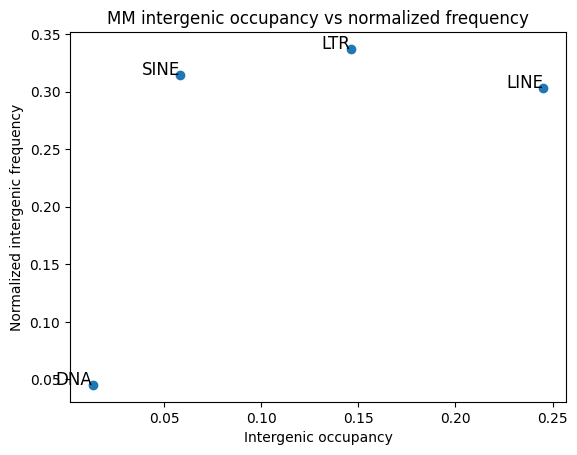

In [94]:
intergenic_normalized = [el/sum(mm_intergenic_freqs) for el in mm_intergenic_freqs]

# Create the plot
plt.scatter(mm_occs_intergenic, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(mm_occs_intergenic[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic occupancy')
plt.ylabel('Normalized intergenic frequency')
plt.title('MM intergenic occupancy vs normalized frequency')

# Show the plot
plt.show()

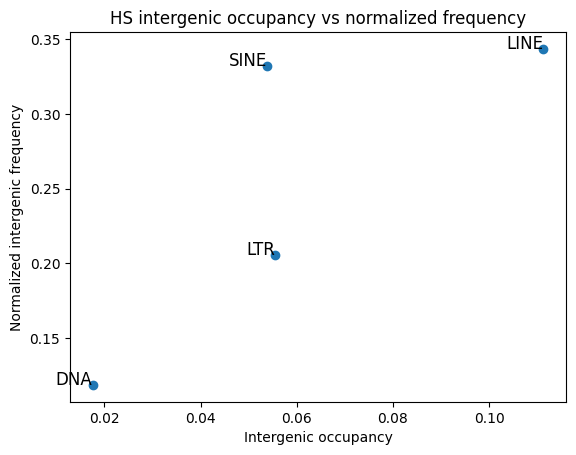

In [95]:
intergenic_normalized = [el/sum(hs_intergenic_freqs) for el in hs_intergenic_freqs]

# Create the plot
plt.scatter(hs_occs_intergenic, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(hs_occs_intergenic[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic occupancy')
plt.ylabel('Normalized intergenic frequency')
plt.title('HS intergenic occupancy vs normalized frequency')

# Show the plot
plt.show()

In [96]:
intergenic_normalized = [el/sum(at_intergenic_freqs) for el in at_intergenic_freqs]

# Create the plot
plt.scatter(at_occs_intergenic, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(at_occs_intergenic[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic occupancy')
plt.ylabel('Normalized intergenic frequency')
plt.title('AT intergenic occupancy vs normalized frequency')

# Show the plot
plt.show()

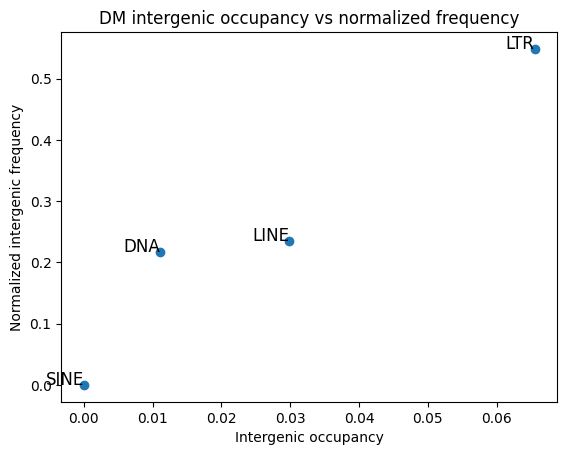

In [97]:
intergenic_normalized = [el/sum(dm_intergenic_freqs) for el in dm_intergenic_freqs]

# Create the plot
plt.scatter(dm_occs_intergenic, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(dm_occs_intergenic[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic occupancy')
plt.ylabel('Normalized intergenic frequency')
plt.title('DM intergenic occupancy vs normalized frequency')

# Show the plot
plt.show()

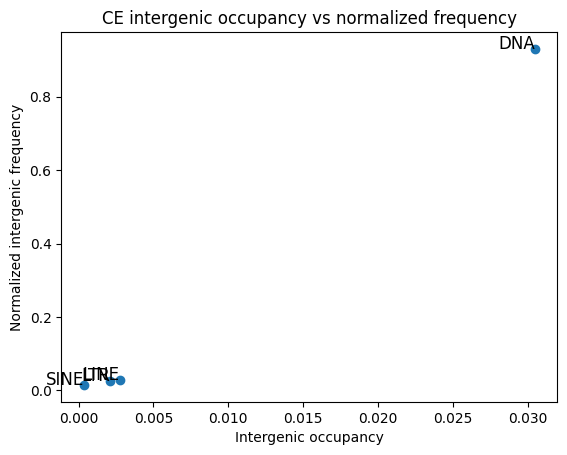

In [98]:
intergenic_normalized = [el/sum(ce_intergenic_freqs) for el in ce_intergenic_freqs]

# Create the plot
plt.scatter(ce_occs_intergenic, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(ce_occs_intergenic[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic occupancy')
plt.ylabel('Normalized intergenic frequency')
plt.title('CE intergenic occupancy vs normalized frequency')

# Show the plot
plt.show()

## Análisis de todo junto

### Preferencias intronicas nivel genoma completo

In [99]:
data = [mm_occs_intronic, hs_occs_intronic, at_occs_intronic, dm_occs_intronic, ce_occs_intronic]
intronic_occs = pd.DataFrame(data=data, columns=titles, index=["MM", "HS", "AT", "DM", "CE"])
print(intronic_occs)

        SINE      LINE       LTR       DNA
MM  0.103383  0.138708  0.096852  0.016498
HS  0.150688  0.205983  0.071625  0.044661
AT  0.000000  0.000506  0.001123  0.000758
DM  0.000000  0.035581  0.086652  0.020533
CE  0.001157  0.002359  0.001085  0.110203


In [100]:
data = [mm_occs_intergenic, hs_occs_intergenic, at_occs_intergenic, dm_occs_intergenic, ce_occs_intergenic]
intronic_occs = pd.DataFrame(data=data, columns=titles, index=["MM", "HS", "AT", "DM", "CE"])
print(intronic_occs)

        SINE      LINE       LTR       DNA
MM  0.057938  0.245342  0.145943  0.013066
HS  0.053795  0.111304  0.055418  0.017528
AT  0.000000  0.007598  0.059940  0.019821
DM  0.000000  0.029816  0.065556  0.011076
CE  0.000352  0.002753  0.002085  0.030460


In [101]:
data = [mm_prefs, hs_prefs, at_prefs, dm_prefs, ce_prefs]
all_prefs = pd.DataFrame(data=data, columns=titles, index=["MM", "HS", "AT", "DM", "CE"])
print(all_prefs)

        SINE      LINE       LTR       DNA
MM  1.784358  0.565364  0.663627  1.262629
HS  2.801124  1.850637  1.292443  2.547980
AT       NaN  0.066613  0.018742  0.038223
DM       NaN  1.193371  1.321813  1.853760
CE  3.287964  0.856981  0.520118  3.617988


In [104]:
row_order =["HS", "MM", "DM", "CE", "AT"]
col_order = ["SINE", "DNA", "LINE", "LTR"]
all_prefs = all_prefs.loc[row_order]
all_prefs = all_prefs[col_order]

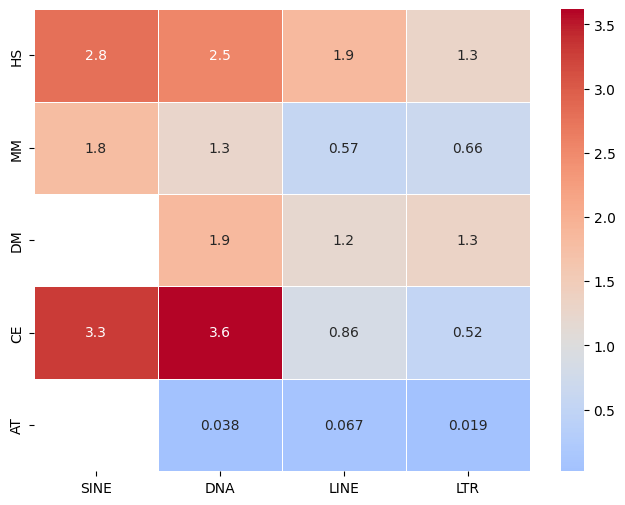

In [105]:
plt.figure(figsize=(8,6))
sns.heatmap(all_prefs, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
#plt.title("Intronic preference for each class of TE for all organisms, by relative occupancy")
plt.show()

In [106]:
data = [mm_intronic_freqs, hs_intronic_freqs, at_intronic_freqs, dm_intronic_freqs, ce_intronic_freqs]
intronic_freqs = pd.DataFrame(data=data, columns=titles, index=["MM", "HS", "AT", "DM", "CE"])
print(intronic_freqs)

       SINE    LINE     LTR     DNA
MM   887568  359029  431281  100838
HS  1126218  927050  340818  391026
AT        0      73     123      52
DM        0    2744    5872    4374
CE      226     149      80   16555


In [107]:
data = [mm_intergenic_freqs, hs_intergenic_freqs, at_intergenic_freqs, dm_intergenic_freqs, ce_intergenic_freqs]
intergenic_freqs = pd.DataFrame(data=data, columns=titles, index=["MM", "HS", "AT", "DM", "CE"])
print(intergenic_freqs)

      SINE    LINE     LTR     DNA
MM  665977  641219  713492   95610
HS  735449  760413  455401  262996
AT       0    1486    7041    3582
DM       0    4977   11642    4599
CE     210     406     362   12988


In [108]:
mm_freq_prefs = pref_intron_inter(mm_intronic_freqs, mm_intergenic_freqs)
hs_freq_prefs = pref_intron_inter(hs_intronic_freqs, hs_intergenic_freqs)
at_freq_prefs = pref_intron_inter(at_intronic_freqs, at_intergenic_freqs)
dm_freq_prefs = pref_intron_inter(dm_intronic_freqs, dm_intergenic_freqs)
ce_freq_prefs = pref_intron_inter(ce_intronic_freqs, ce_intergenic_freqs)

[1.3327307099194117, 0.5599163468331413, 0.6044650815986724, 1.054680472753896]
[1.5313339198231284, 1.2191401251688228, 0.7483909785002668, 1.486813487657607]
[None, 0.04912516823687752, 0.017469109501491265, 0.014517029592406477]
[None, 0.5513361462728551, 0.5043806906029892, 0.9510763209393346]
[1.0761904761904761, 0.3669950738916256, 0.22099447513812154, 1.2746381275023098]


In [109]:
data = [mm_freq_prefs, hs_freq_prefs, at_freq_prefs, dm_freq_prefs, ce_freq_prefs]

all_freq_prefs = pd.DataFrame(data=data, columns=titles, index=["MM", "HS", "AT", "DM", "CE"])
print(all_freq_prefs)


        SINE      LINE       LTR       DNA
MM  1.332731  0.559916  0.604465  1.054680
HS  1.531334  1.219140  0.748391  1.486813
AT       NaN  0.049125  0.017469  0.014517
DM       NaN  0.551336  0.504381  0.951076
CE  1.076190  0.366995  0.220994  1.274638


In [111]:
row_order =["HS", "MM", "DM", "CE", "AT"]
col_order = ["SINE", "DNA", "LINE", "LTR"]
all_freq_prefs = all_freq_prefs.loc[row_order]
all_freq_prefs = all_freq_prefs[col_order]

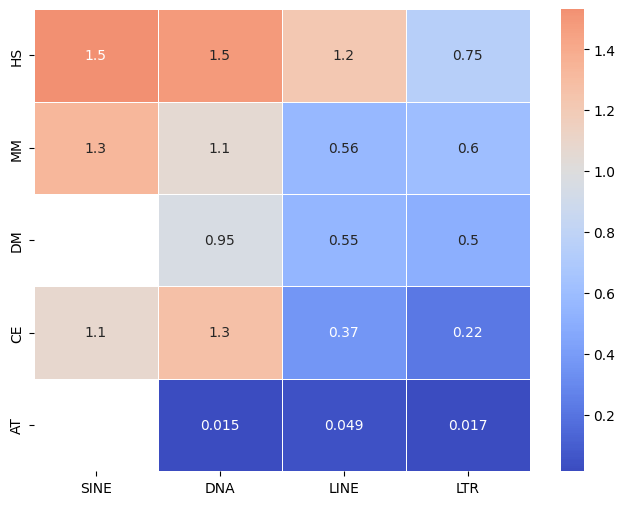

In [112]:
plt.figure(figsize=(8,6))
sns.heatmap(all_freq_prefs, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
#plt.title("Intronic preference for each class of TE for all organisms, by frequency")
plt.show()

In [113]:
organism_names = ["MM", "HS", "AT", "DM", "CE"]
data = [mm_intronic_lengths, hs_intronic_lengths, at_intronic_lengths, dm_intronic_lengths, ce_intronic_lengths,] 
df_lengths_intronic = pd.DataFrame(data=data, columns=titles, index=organism_names)
print(df_lengths_intronic)

          SINE        LINE         LTR         DNA
MM  134.478780  446.044470  259.270603  188.891410
HS  225.107262  373.819889  353.571689  192.158959
AT    0.000000  127.232877  167.601626  267.365385
DM    0.000000  796.979592  906.991996  288.522176
CE  168.327434  520.691275  445.862500  218.935065


In [114]:
data = [mm_intergenic_lengths, hs_intergenic_lengths, at_intergenic_lengths, dm_intergenic_lengths, ce_intergenic_lengths,]
df_lengths_intergenic = pd.DataFrame(data=data, columns=titles, index=organism_names)
print(df_lengths_intergenic)

          SINE        LINE          LTR         DNA
MM  136.490211  600.288530   320.913527  214.409769
HS  225.896991  452.041437   375.818228  205.828035
AT    0.000000  611.880888  1018.746201  662.192630
DM    0.000000  824.126984   774.636489  331.319635
CE  168.000000  679.926108   577.660221  235.194641


In [115]:
df_lengths_pref = df_lengths_intronic / df_lengths_intergenic
print(df_lengths_pref)

        SINE      LINE       LTR       DNA
MM  0.985263  0.743050  0.807914  0.880983
HS  0.996504  0.826959  0.940805  0.933590
AT       NaN  0.207937  0.164518  0.403758
DM       NaN  0.967059  1.170861  0.870827
CE  1.001949  0.765806  0.771842  0.930868


In [117]:
row_order =["HS", "MM", "DM", "CE", "AT"]
col_order = ["SINE", "DNA", "LINE", "LTR"]
df_lengths_pref = df_lengths_pref.loc[row_order]
df_lengths_pref = df_lengths_pref[col_order]

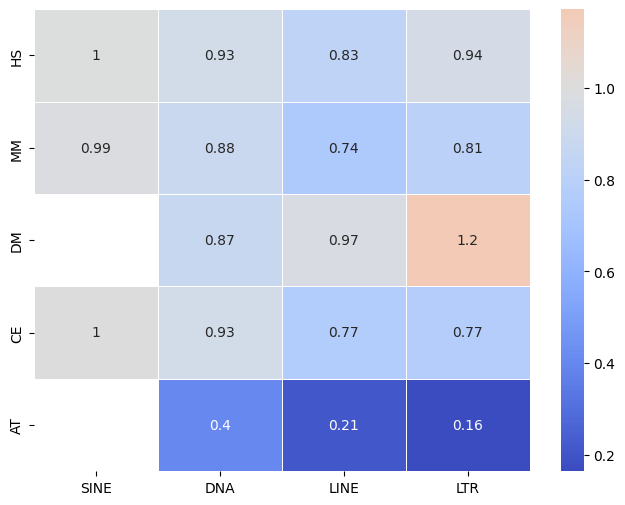

In [118]:
plt.figure(figsize=(8,6))
sns.heatmap(df_lengths_pref, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
#plt.title("Intronic preference for each class of TE for all organisms by mean size")
plt.show()

Matriz de correlaciones genoma completo

In [120]:
for_mm = mm_intronic_lengths + mm_intergenic_lengths + mm_intronic_freqs + mm_intergenic_freqs + mm_occs_intronic + mm_occs_intergenic
for_hs = hs_intronic_lengths + hs_intergenic_lengths + hs_intronic_freqs + hs_intergenic_freqs + hs_occs_intronic + hs_occs_intergenic
for_at = at_intronic_lengths + at_intergenic_lengths + at_intronic_freqs + at_intergenic_freqs + at_occs_intronic + at_occs_intergenic
for_dm = dm_intronic_lengths + dm_intergenic_lengths + dm_intronic_freqs + dm_intergenic_freqs + dm_occs_intronic + dm_occs_intergenic
for_ce = ce_intronic_lengths + ce_intergenic_lengths + ce_intronic_freqs + ce_intergenic_freqs + ce_occs_intronic + ce_occs_intergenic

columns = ['SINE_intronic_length', 'LINE_intronic_length', 'LTR_intronic_length', 'DNA_intronic_length',
            'SINE_intergenic_length', 'LINE_intergenic_length', 'LTR_intergenic_length', 'DNA_intergenic_length',
            'SINE_intronic_freq', 'LINE_intronic_freq', 'LTR_intronic_freq', 'DNA_intronic_freq',
            'SINE_intergenic_freq', 'LINE_intergenic_freq', 'LTR_intergenic_freq', 'DNA_intergenic_freq',
            'SINE_occ_intronic', 'LINE_occ_intronic', 'LTR_occ_intronic', 'DNA_occ_intronic',
            'SINE_occ_intergenic', 'LINE_occ_intergenic', 'LTR_occ_intergenic', 'DNA_occ_intergenic']

data = [for_mm, for_hs, for_at, for_dm, for_ce]
organism_names = ["MM", "HS", "AT", "DM", "CE"]
df = pd.DataFrame(data=data, columns=columns, index=organism_names)

all_df = df.copy()

print(df)

    SINE_intronic_length  LINE_intronic_length  LTR_intronic_length  \
MM            134.478780            446.044470           259.270603   
HS            225.107262            373.819889           353.571689   
AT              0.000000            127.232877           167.601626   
DM              0.000000            796.979592           906.991996   
CE            168.327434            520.691275           445.862500   

    DNA_intronic_length  SINE_intergenic_length  LINE_intergenic_length  \
MM           188.891410              136.490211              600.288530   
HS           192.158959              225.896991              452.041437   
AT           267.365385                0.000000              611.880888   
DM           288.522176                0.000000              824.126984   
CE           218.935065              168.000000              679.926108   

    LTR_intergenic_length  DNA_intergenic_length  SINE_intronic_freq  \
MM             320.913527             214.409769  

Frecuencias de TEs por organismo

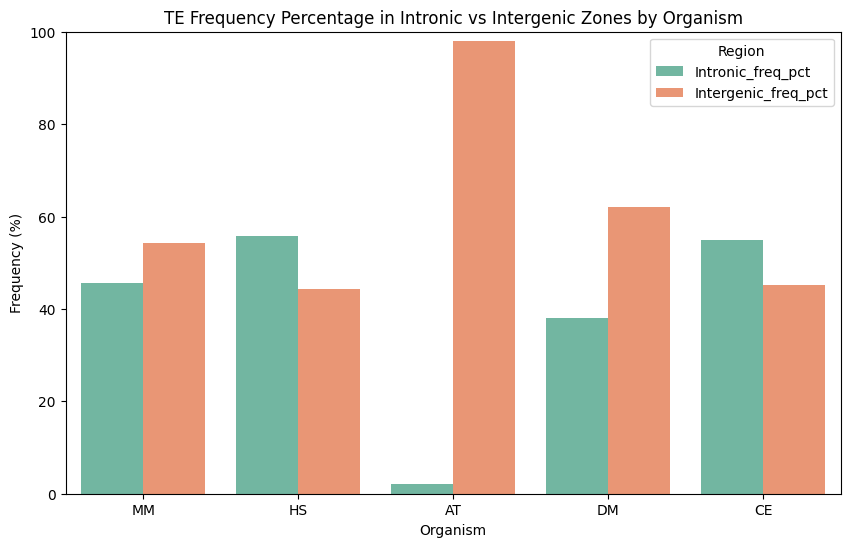

In [122]:
df['Intronic_freq'] = df[['SINE_intronic_freq', 'LINE_intronic_freq', 'LTR_intronic_freq', 'DNA_intronic_freq']].sum(axis=1)
df['Intergenic_freq'] = df[['SINE_intergenic_freq', 'LINE_intergenic_freq', 'LTR_intergenic_freq', 'DNA_intergenic_freq']].sum(axis=1)

df['Total_freq'] = df['Intronic_freq'] + df['Intergenic_freq']

df['Intronic_freq_pct'] = (df['Intronic_freq'] / df['Total_freq']) * 100
df['Intergenic_freq_pct'] = (df['Intergenic_freq'] / df['Total_freq']) * 100

df = df.reset_index()

df_long = df.melt(id_vars='index', value_vars=['Intronic_freq_pct', 'Intergenic_freq_pct'], 
                  var_name='Region', value_name='Frequency')

df_long.rename(columns={'index': 'Organism'}, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Organism', y='Frequency', hue='Region', data=df_long, palette='Set2')

plt.title('TE Frequency Percentage in Intronic vs Intergenic Zones by Organism')
plt.ylabel('Frequency (%)')
plt.xlabel('Organism')
plt.ylim(0, 100)
plt.legend(title='Region')
plt.show()

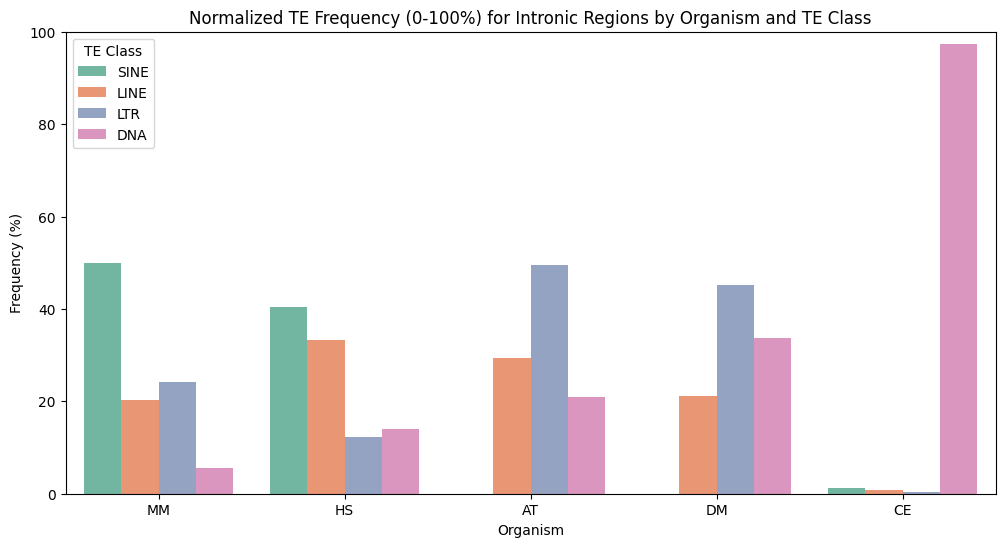

In [125]:
# Columns for intronic frequencies
freq_columns_intronic = ['SINE_intronic_freq', 'LINE_intronic_freq', 'LTR_intronic_freq', 'DNA_intronic_freq']

# Create a dataframe for intronic regions
df_intronic = df[freq_columns_intronic].copy()
df_intronic['Region'] = 'Intronic'
df_intronic['Organism'] = organism_names  # Assuming the organism names are the index of df

# Rename columns to represent TE classes
df_intronic.columns = ['SINE', 'LINE', 'LTR', 'DNA', 'Region', 'Organism']

# Melt the dataframe to long format
df_long_intronic = df_intronic.melt(id_vars=['Organism', 'Region'], var_name='TE_Class', value_name='Frequency')

# Normalize frequencies so that the total frequency for each organism sums to 100%
df_long_intronic['Total_Frequency'] = df_long_intronic.groupby('Organism')['Frequency'].transform('sum')
df_long_intronic['Frequency_pct'] = (df_long_intronic['Frequency'] / df_long_intronic['Total_Frequency']) * 100

# Plot the barplot for intronic regions
plt.figure(figsize=(12, 6))
sns.barplot(x='Organism', y='Frequency_pct', hue='TE_Class', data=df_long_intronic, palette='Set2', dodge=True)

# Customize the plot
plt.title('Normalized TE Frequency (0-100%) for Intronic Regions by Organism and TE Class')
plt.ylabel('Frequency (%)')
plt.xlabel('Organism')
plt.ylim(0, 100)  # Adjust y-axis to represent percentages
plt.legend(title='TE Class')
plt.xticks(rotation=0)
plt.show()


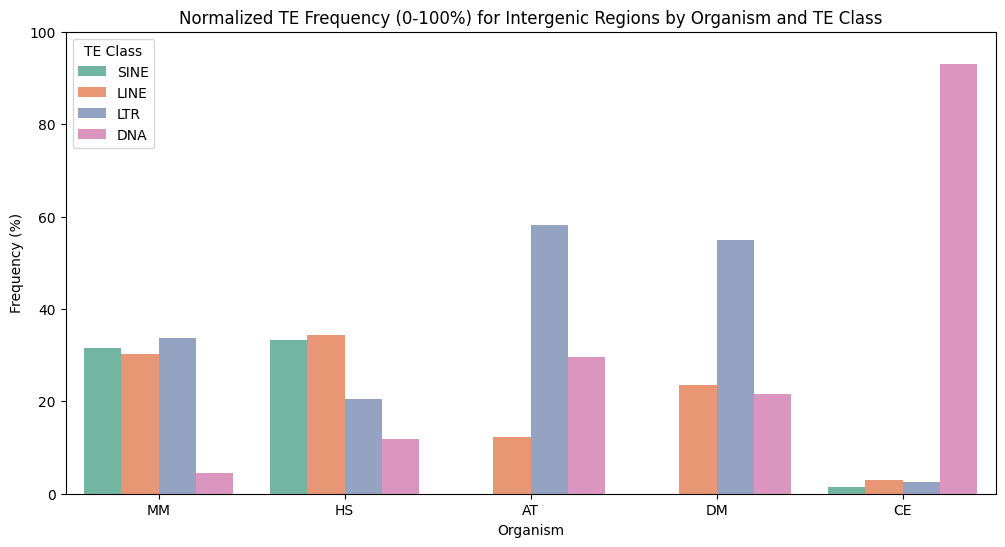

In [127]:
# Columns for intergenic frequencies
freq_columns_intergenic = ['SINE_intergenic_freq', 'LINE_intergenic_freq', 'LTR_intergenic_freq', 'DNA_intergenic_freq']

# Create a dataframe for intergenic regions
df_intergenic = df[freq_columns_intergenic].copy()
df_intergenic['Region'] = 'Intergenic'
df_intergenic['Organism'] = organism_names  # Assuming the organism names are the index of df

# Rename columns to represent TE classes
df_intergenic.columns = ['SINE', 'LINE', 'LTR', 'DNA', 'Region', 'Organism']

# Melt the dataframe to long format
df_long_intergenic = df_intergenic.melt(id_vars=['Organism', 'Region'], var_name='TE_Class', value_name='Frequency')

# Normalize frequencies so that the total frequency for each organism sums to 100%
df_long_intergenic['Total_Frequency'] = df_long_intergenic.groupby('Organism')['Frequency'].transform('sum')
df_long_intergenic['Frequency_pct'] = (df_long_intergenic['Frequency'] / df_long_intergenic['Total_Frequency']) * 100

# Plot the barplot for intergenic regions
plt.figure(figsize=(12, 6))
sns.barplot(x='Organism', y='Frequency_pct', hue='TE_Class', data=df_long_intergenic, palette='Set2', dodge=True)

# Customize the plot
plt.title('Normalized TE Frequency (0-100%) for Intergenic Regions by Organism and TE Class')
plt.ylabel('Frequency (%)')
plt.xlabel('Organism')
plt.ylim(0, 100)  # Adjust y-axis to represent percentages
plt.legend(title='TE Class')
plt.xticks(rotation=0)
plt.show()

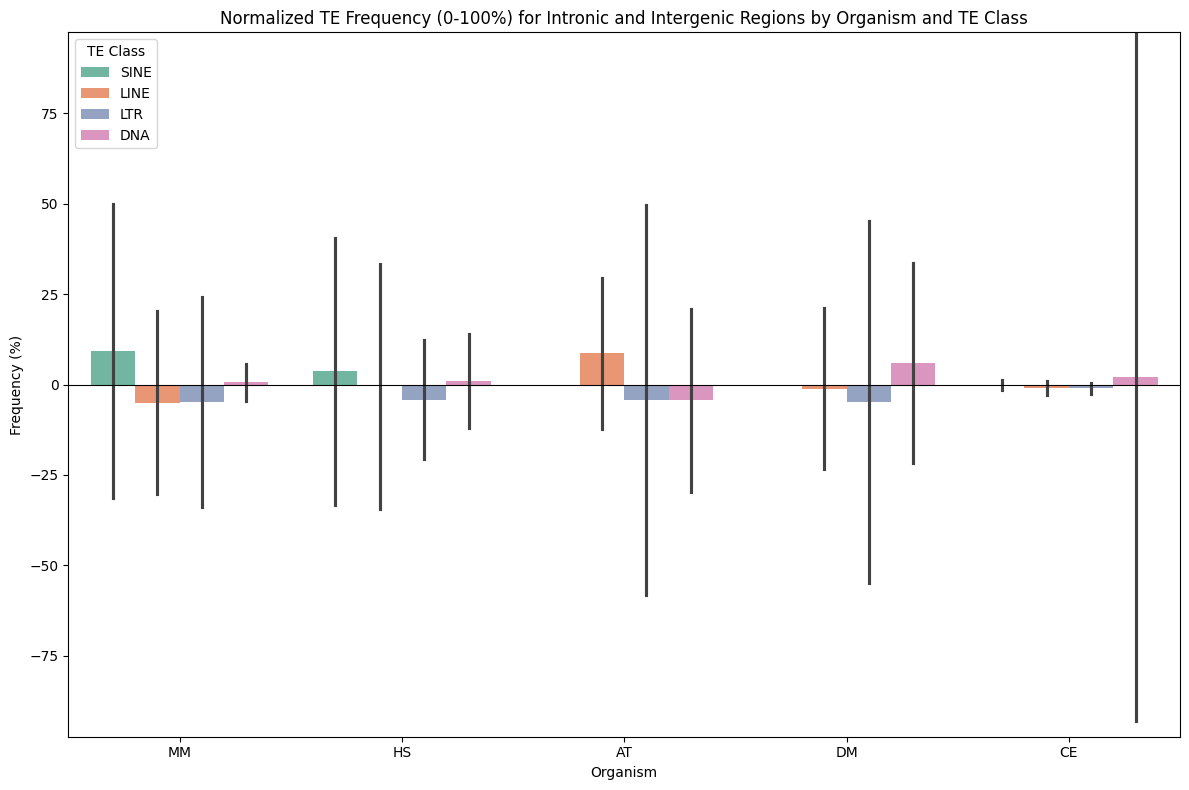

In [128]:
# Combine the intronic and intergenic data into one DataFrame

# Add a flag to differentiate between the two regions
df_long_intronic['Region_Type'] = 'Intronic'
df_long_intergenic['Region_Type'] = 'Intergenic'

# Combine both datasets into one
df_combined = pd.concat([df_long_intronic, df_long_intergenic])

# Make the 'Intergenic' frequencies negative to reflect them along the X-axis
df_combined.loc[df_combined['Region_Type'] == 'Intergenic', 'Frequency_pct'] *= -1

# Plot the combined data
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Organism', 
    y='Frequency_pct', 
    hue='TE_Class', 
    data=df_combined, 
    palette='Set2', 
    dodge=True
)

# Customize the plot
plt.title('Normalized TE Frequency (0-100%) for Intronic and Intergenic Regions by Organism and TE Class')
plt.ylabel('Frequency (%)')
plt.xlabel('Organism')

# Set the y-axis limits symmetrically around zero to give a mirror effect
max_y = df_combined['Frequency_pct'].abs().max()
plt.ylim(-max_y, max_y)

# Add horizontal lines at y=0 for the X-axis
plt.axhline(0, color='black', linewidth=0.8)

# Customize legend and ticks
plt.legend(title='TE Class')
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()


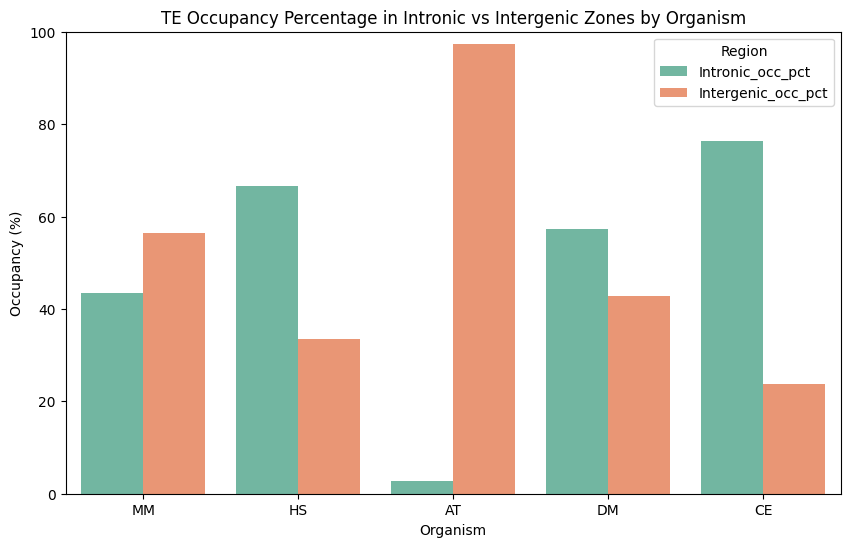

In [130]:
df['Intronic_occ'] = df[['SINE_occ_intronic', 'LINE_occ_intronic', 'LTR_occ_intronic', 'DNA_occ_intronic']].sum(axis=1)
df['Intergenic_occ'] = df[['SINE_occ_intergenic', 'LINE_occ_intergenic', 'LTR_occ_intergenic', 'DNA_occ_intergenic']].sum(axis=1)

df['Total_occ'] = df['Intronic_occ'] + df['Intergenic_occ']

df['Intronic_occ_pct'] = (df['Intronic_occ'] / df['Total_occ']) * 100
df['Intergenic_occ_pct'] = (df['Intergenic_occ'] / df['Total_occ']) * 100

df = df.reset_index()

df_long = df.melt(id_vars='index', value_vars=['Intronic_occ_pct', 'Intergenic_occ_pct'], 
                  var_name='Region', value_name='Occupancy')

df_long.rename(columns={'index': 'Organism'}, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Organism', y='Occupancy', hue='Region', data=df_long, palette='Set2')

plt.title('TE Occupancy Percentage in Intronic vs Intergenic Zones by Organism')
plt.ylabel('Occupancy (%)')
plt.xlabel('Organism')
plt.ylim(0, 100)
plt.legend(title='Region')
plt.show()

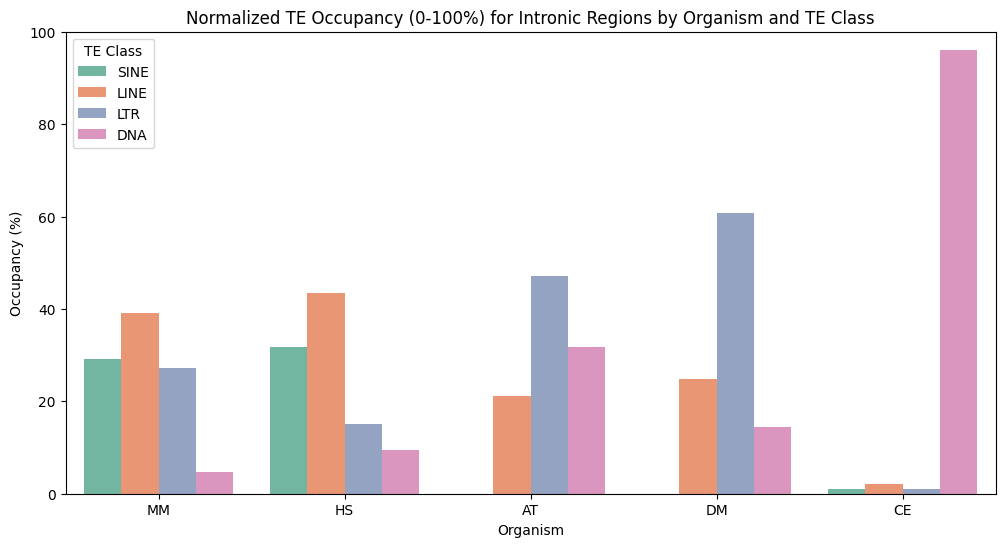

In [132]:
# Step 2: Select the columns related to occupancies for intronic regions
occ_columns_intronic = ['SINE_occ_intronic', 'LINE_occ_intronic', 'LTR_occ_intronic', 'DNA_occ_intronic']

# Step 3: Create a DataFrame for intronic regions
df_intronic = df[occ_columns_intronic].copy()
df_intronic['Region'] = 'Intronic'
df_intronic['Organism'] = organism_names  # Assuming organism names are the index of df

# Step 4: Rename columns to represent the TE classes
df_intronic.columns = ['SINE', 'LINE', 'LTR', 'DNA', 'Region', 'Organism']

# Step 5: Melt the DataFrame into long format
df_long_intronic = df_intronic.melt(id_vars=['Organism', 'Region'], var_name='TE_Class', value_name='Occupancy')

# Step 6: Normalize occupancies so that the total occupancy for each organism sums to 100%
df_long_intronic['Total_Occupancy'] = df_long_intronic.groupby('Organism')['Occupancy'].transform('sum')
df_long_intronic['Occupancy_pct'] = (df_long_intronic['Occupancy'] / df_long_intronic['Total_Occupancy']) * 100

# Step 7: Create the barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='Organism', y='Occupancy_pct', hue='TE_Class', data=df_long_intronic, palette='Set2', dodge=True)

# Step 8: Customize the plot
plt.title('Normalized TE Occupancy (0-100%) for Intronic Regions by Organism and TE Class')
plt.ylabel('Occupancy (%)')
plt.xlabel('Organism')
plt.ylim(0, 100)  # Adjust y-axis to represent percentages (0-100%)
plt.legend(title='TE Class')
plt.xticks(rotation=0)
plt.show()

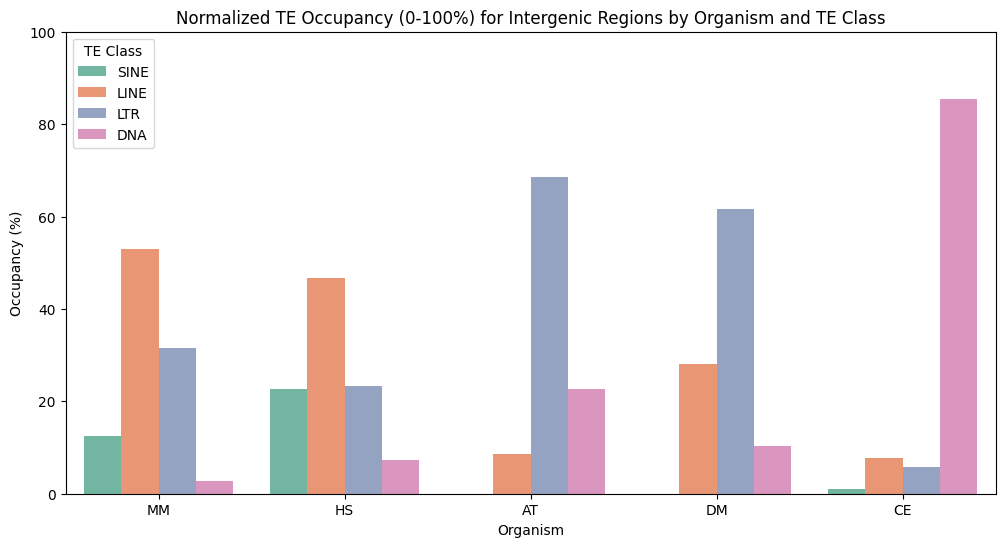

In [134]:
# Step 2: Select the columns related to occupancies for intergenic regions
occ_columns_intergenic = ['SINE_occ_intergenic', 'LINE_occ_intergenic', 'LTR_occ_intergenic', 'DNA_occ_intergenic']

# Step 3: Create a DataFrame for intergenic regions
df_intergenic = df[occ_columns_intergenic].copy()
df_intergenic['Region'] = 'Intergenic'
df_intergenic['Organism'] = organism_names  # Assuming organism names are the index of df

# Step 4: Rename columns to represent the TE classes
df_intergenic.columns = ['SINE', 'LINE', 'LTR', 'DNA', 'Region', 'Organism']

# Step 5: Melt the DataFrame into long format
df_long_intergenic = df_intergenic.melt(id_vars=['Organism', 'Region'], var_name='TE_Class', value_name='Occupancy')

# Step 6: Normalize occupancies so that the total occupancy for each organism sums to 100%
df_long_intergenic['Total_Occupancy'] = df_long_intergenic.groupby('Organism')['Occupancy'].transform('sum')
df_long_intergenic['Occupancy_pct'] = (df_long_intergenic['Occupancy'] / df_long_intergenic['Total_Occupancy']) * 100

# Step 7: Create the barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='Organism', y='Occupancy_pct', hue='TE_Class', data=df_long_intergenic, palette='Set2', dodge=True)

# Step 8: Customize the plot
plt.title('Normalized TE Occupancy (0-100%) for Intergenic Regions by Organism and TE Class')
plt.ylabel('Occupancy (%)')
plt.xlabel('Organism')
plt.ylim(0, 100)  # Adjust y-axis to represent percentages (0-100%)
plt.legend(title='TE Class')
plt.xticks(rotation=0)
plt.show()

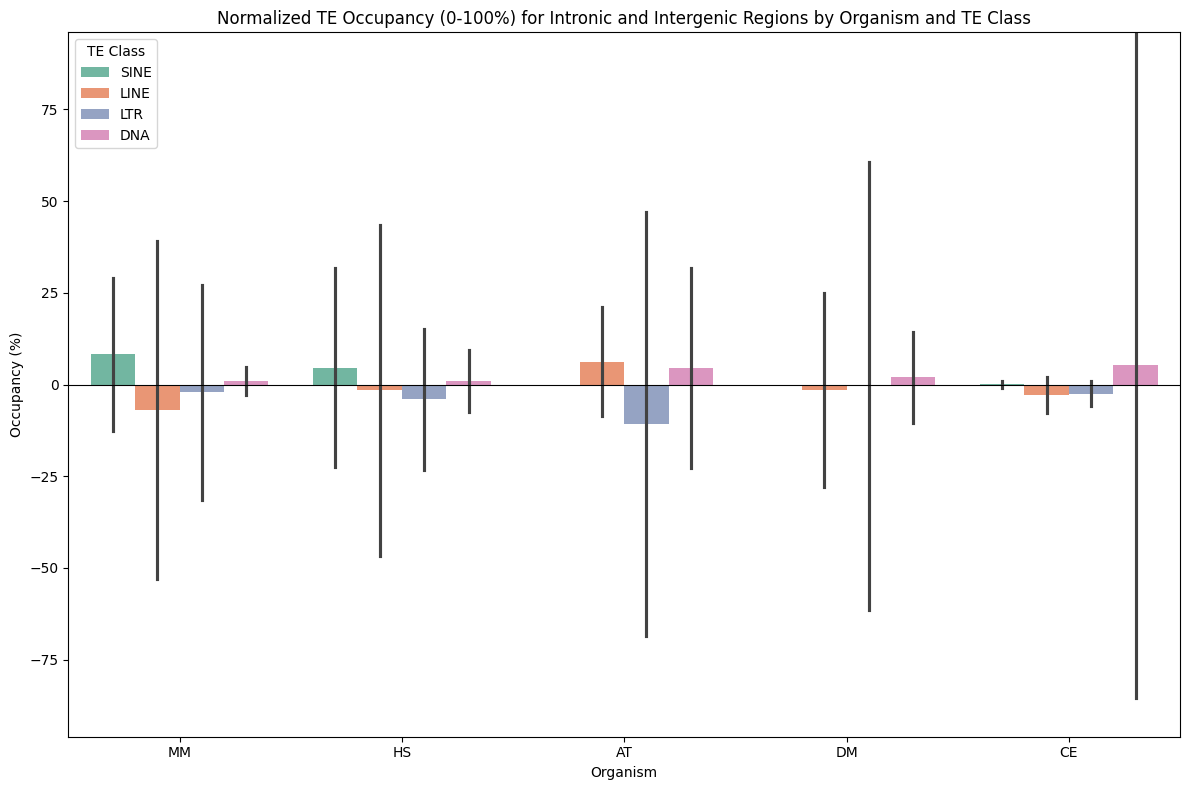

In [135]:
# Combine the intronic and intergenic data into one DataFrame

# Add a flag to differentiate between the two regions
df_long_intronic['Region_Type'] = 'Intronic'
df_long_intergenic['Region_Type'] = 'Intergenic'

# Combine both datasets into one
df_combined = pd.concat([df_long_intronic, df_long_intergenic])

# Make the 'Intergenic' occupancies negative to reflect them along the X-axis
df_combined.loc[df_combined['Region_Type'] == 'Intergenic', 'Occupancy_pct'] *= -1

# Plot the combined data
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Organism', 
    y='Occupancy_pct', 
    hue='TE_Class', 
    data=df_combined, 
    palette='Set2', 
    dodge=True
)

# Customize the plot
plt.title('Normalized TE Occupancy (0-100%) for Intronic and Intergenic Regions by Organism and TE Class')
plt.ylabel('Occupancy (%)')
plt.xlabel('Organism')

# Set the y-axis limits symmetrically around zero to give a mirror effect
max_y = df_combined['Occupancy_pct'].abs().max()
plt.ylim(-max_y, max_y)

# Add horizontal lines at y=0 for the X-axis
plt.axhline(0, color='black', linewidth=0.8)

# Customize legend and ticks
plt.legend(title='TE Class')
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()

Matriz de correlaciones, DATA NORMALIZADA! PERO POR COLUMNA EN VEZ DE POR FILA!
O sea, tomo la columna de los largos y la normalizo (por columna)
Por fila, es normalizar los largos de manera individual para cada organismo, y luego meterla al dataframe

In [137]:
df_corr_mat = all_df.copy()

df_corr_mat['SINE_intronic_length'] = (df_corr_mat['SINE_intronic_length'] - df_corr_mat['SINE_intronic_length'].min()) / (df_corr_mat['SINE_intronic_length'].max() - df_corr_mat['SINE_intronic_length'].min())
df_corr_mat['LINE_intronic_length'] = (df_corr_mat['LINE_intronic_length'] - df_corr_mat['LINE_intronic_length'].min()) / (df_corr_mat['LINE_intronic_length'].max() - df_corr_mat['LINE_intronic_length'].min())
df_corr_mat['LTR_intronic_length'] = (df_corr_mat['LTR_intronic_length'] - df_corr_mat['LTR_intronic_length'].min()) / (df_corr_mat['LTR_intronic_length'].max() - df_corr_mat['LTR_intronic_length'].min())
df_corr_mat['DNA_intronic_length'] = (df_corr_mat['DNA_intronic_length'] - df_corr_mat['DNA_intronic_length'].min()) / (df_corr_mat['DNA_intronic_length'].max() - df_corr_mat['DNA_intronic_length'].min())

df_corr_mat['SINE_intergenic_length'] = (df_corr_mat['SINE_intergenic_length'] - df_corr_mat['SINE_intergenic_length'].min()) / (df_corr_mat['SINE_intergenic_length'].max() - df_corr_mat['SINE_intergenic_length'].min())
df_corr_mat['LINE_intergenic_length'] = (df_corr_mat['LINE_intergenic_length'] - df_corr_mat['LINE_intergenic_length'].min()) / (df_corr_mat['LINE_intergenic_length'].max() - df_corr_mat['LINE_intergenic_length'].min())
df_corr_mat['LTR_intergenic_length'] = (df_corr_mat['LTR_intergenic_length'] - df_corr_mat['LTR_intergenic_length'].min()) / (df_corr_mat['LTR_intergenic_length'].max() - df_corr_mat['LTR_intergenic_length'].min())
df_corr_mat['DNA_intergenic_length'] = (df_corr_mat['DNA_intergenic_length'] - df_corr_mat['DNA_intergenic_length'].min()) / (df_corr_mat['DNA_intergenic_length'].max() - df_corr_mat['DNA_intergenic_length'].min())

corr_matrix = df_corr_mat.corr()

plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)

plt.show()

In [138]:
all_df.columns.tolist()

['SINE_intronic_length',
 'LINE_intronic_length',
 'LTR_intronic_length',
 'DNA_intronic_length',
 'SINE_intergenic_length',
 'LINE_intergenic_length',
 'LTR_intergenic_length',
 'DNA_intergenic_length',
 'SINE_intronic_freq',
 'LINE_intronic_freq',
 'LTR_intronic_freq',
 'DNA_intronic_freq',
 'SINE_intergenic_freq',
 'LINE_intergenic_freq',
 'LTR_intergenic_freq',
 'DNA_intergenic_freq',
 'SINE_occ_intronic',
 'LINE_occ_intronic',
 'LTR_occ_intronic',
 'DNA_occ_intronic',
 'SINE_occ_intergenic',
 'LINE_occ_intergenic',
 'LTR_occ_intergenic',
 'DNA_occ_intergenic']

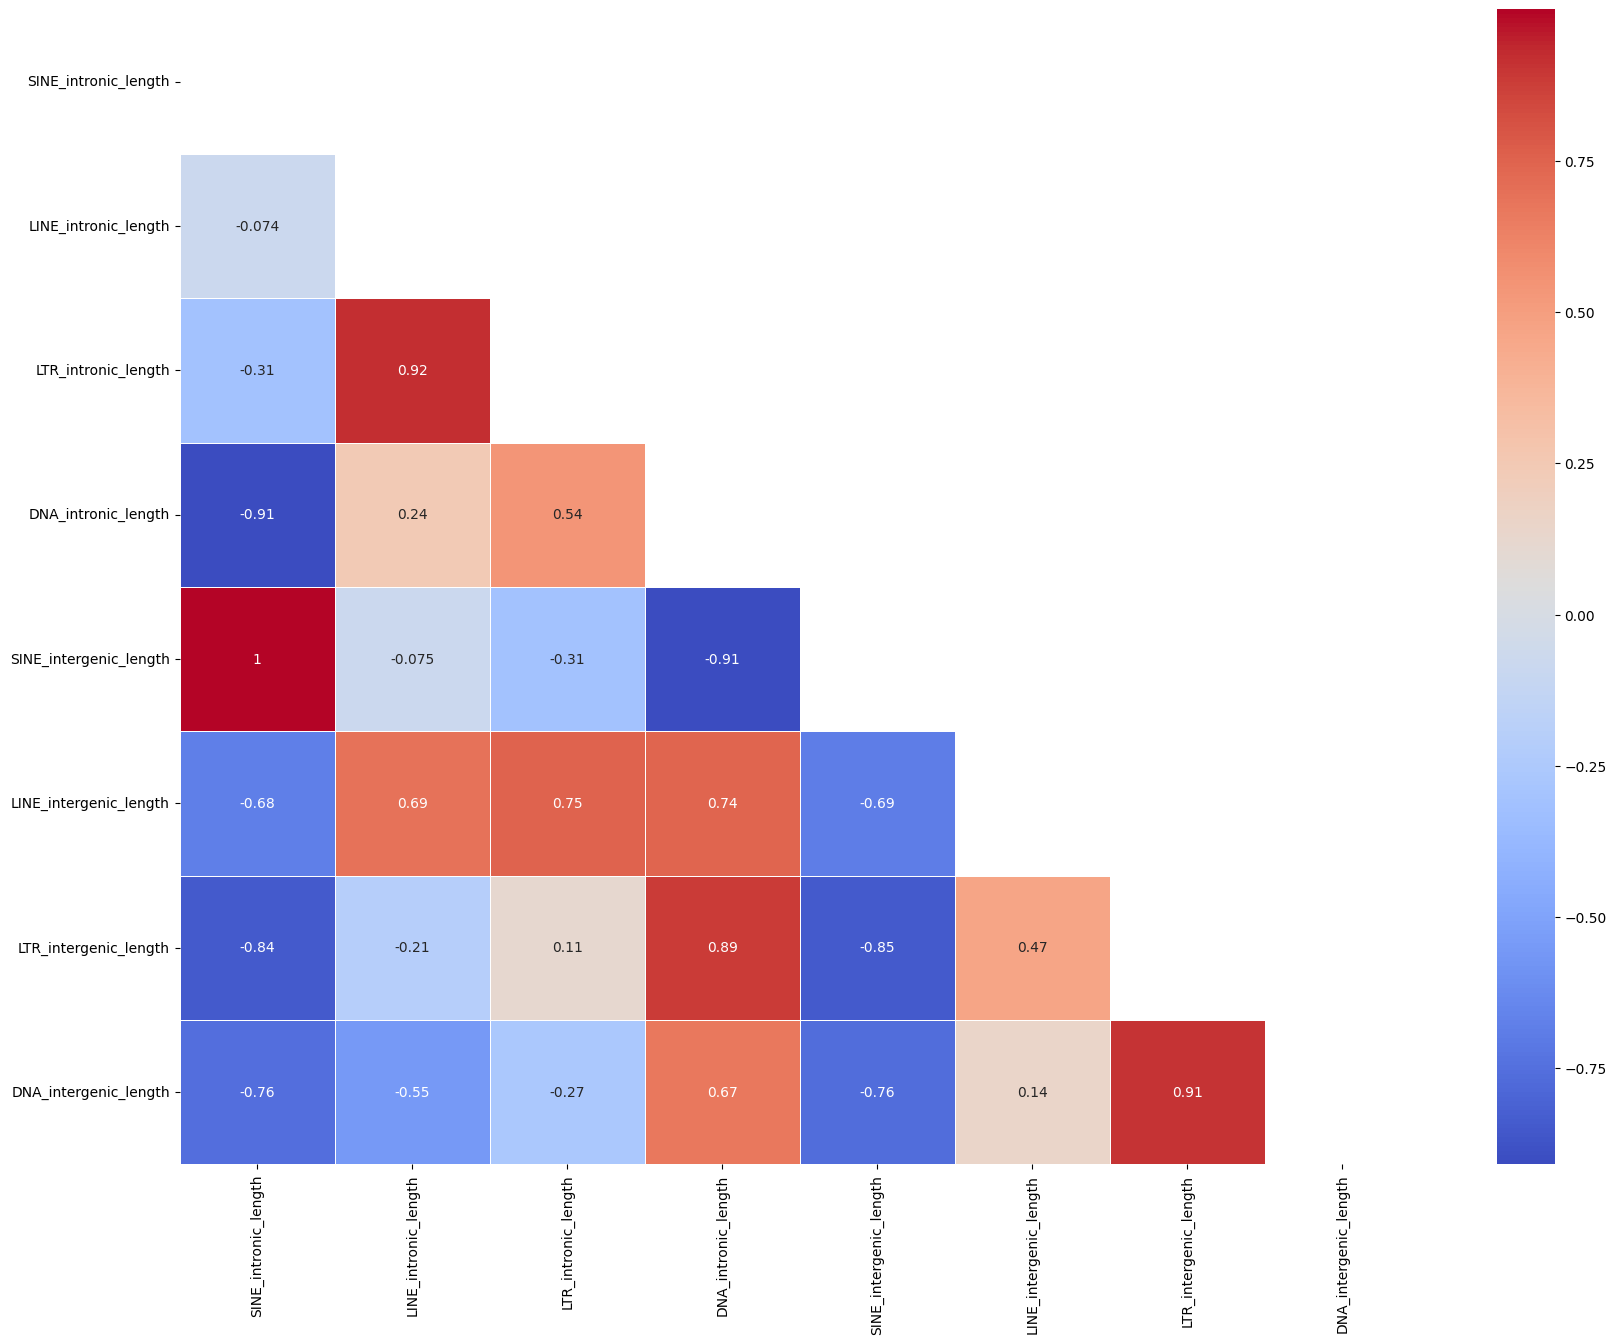

In [140]:
temp_df = df_corr_mat[['SINE_intronic_length',
 'LINE_intronic_length',
 'LTR_intronic_length',
 'DNA_intronic_length',
 'SINE_intergenic_length',
 'LINE_intergenic_length',
 'LTR_intergenic_length',
 'DNA_intergenic_length',]]

corr_matrix = temp_df.corr()

plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)

plt.show()

In [142]:
temp_df = df_corr_mat[[
 'SINE_intronic_freq',
 'LINE_intronic_freq',
 'LTR_intronic_freq',
 'DNA_intronic_freq',
 'SINE_occ_intronic',
 'LINE_occ_intronic',
 'LTR_occ_intronic',
 'DNA_occ_intronic',]]

corr_matrix = temp_df.corr()

plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)

plt.show()

In [144]:
temp_df = df_corr_mat[[
 'SINE_intergenic_freq',
 'LINE_intergenic_freq',
 'LTR_intergenic_freq',
 'DNA_intergenic_freq',
 'SINE_occ_intergenic',
 'LINE_occ_intergenic',
 'LTR_occ_intergenic',
 'DNA_occ_intergenic',]]

corr_matrix = temp_df.corr()

plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)

plt.show()

In [146]:
temp_df = df_corr_mat[[
 'SINE_intergenic_length',
 'LINE_intergenic_length',
 'LTR_intergenic_length',
 'DNA_intergenic_length',
 'SINE_occ_intergenic',
 'LINE_occ_intergenic',
 'LTR_occ_intergenic',
 'DNA_occ_intergenic',]]

corr_matrix = temp_df.corr()

plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)

plt.show()

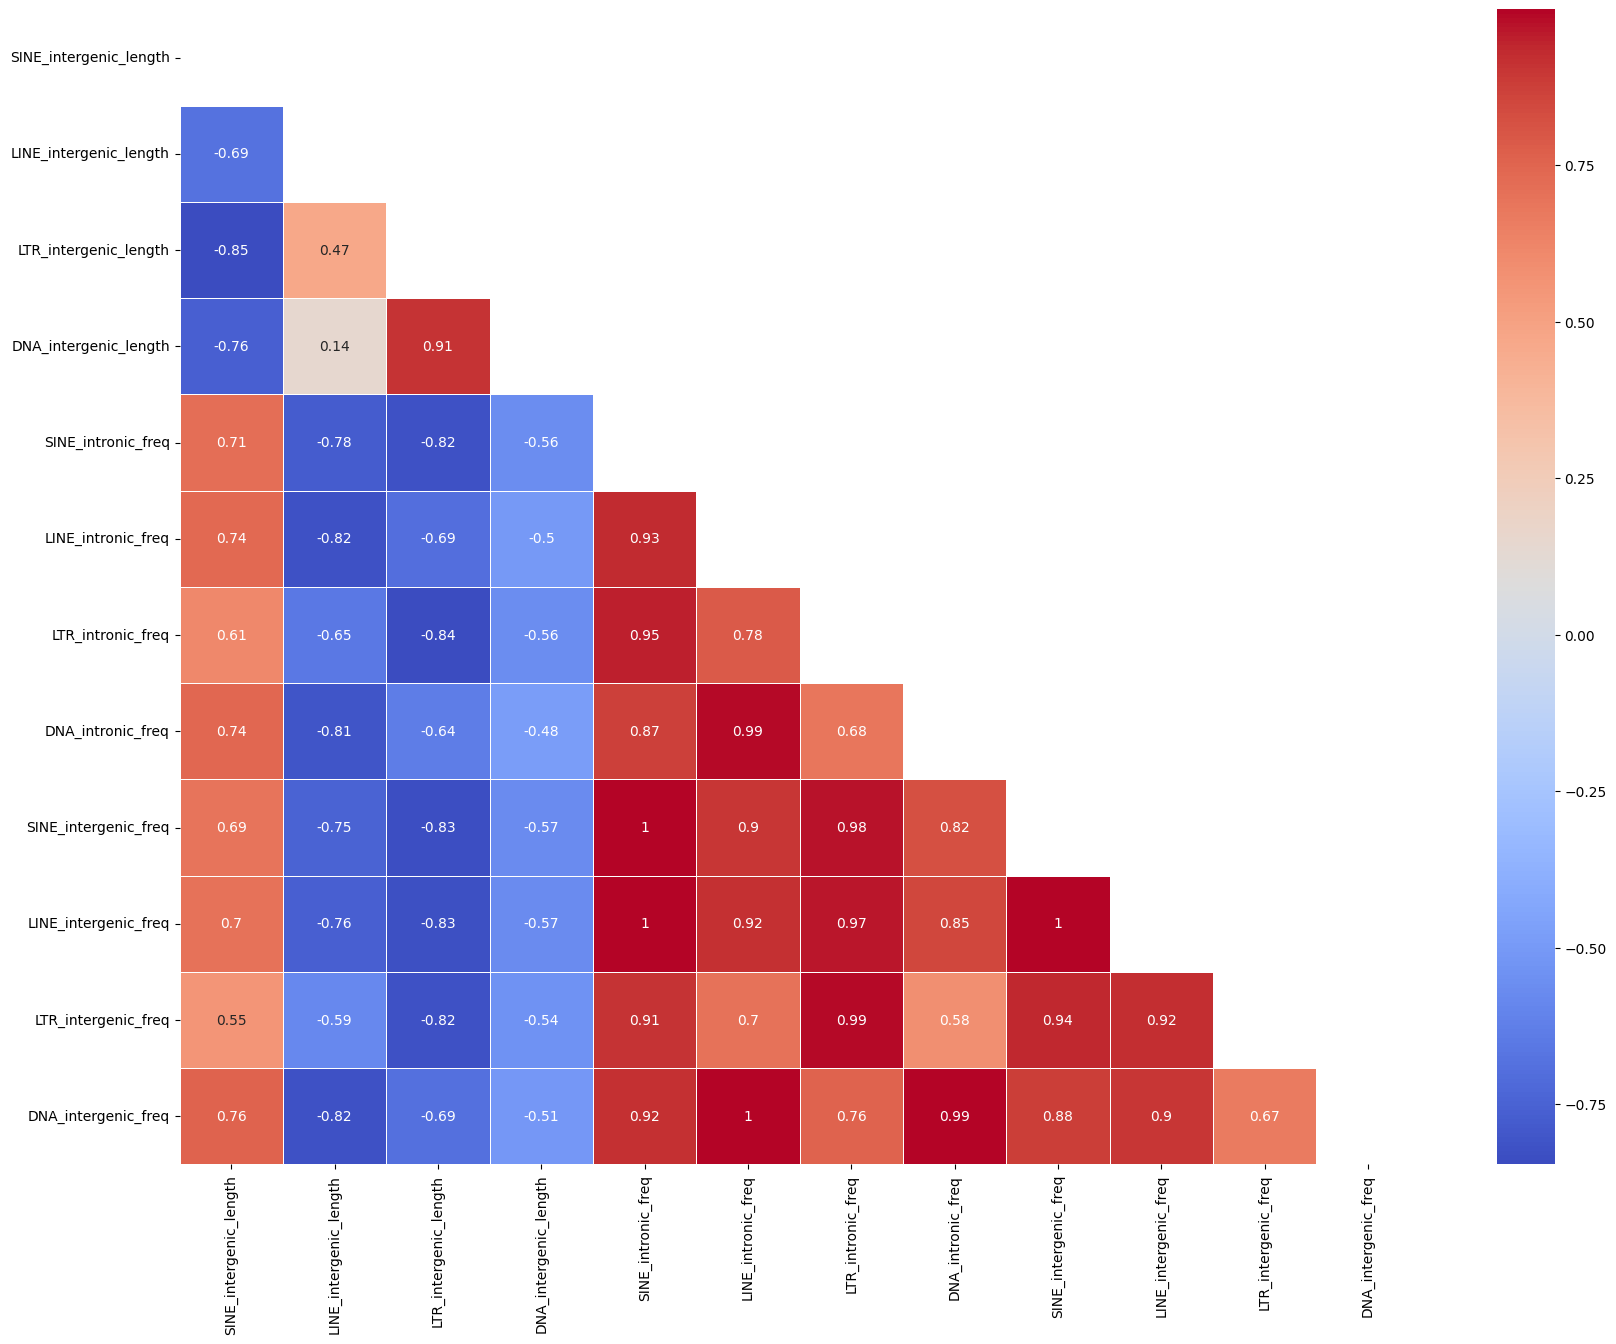

In [149]:
temp_df = df_corr_mat[[
 'SINE_intergenic_length',
 'LINE_intergenic_length',
 'LTR_intergenic_length',
 'DNA_intergenic_length',
 'SINE_intronic_freq',
 'LINE_intronic_freq',
 'LTR_intronic_freq',
 'DNA_intronic_freq',
 'SINE_intergenic_freq',
 'LINE_intergenic_freq',
 'LTR_intergenic_freq',
 'DNA_intergenic_freq',]]

corr_matrix = temp_df.corr()

plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)

plt.show()

### Preferencias intronicas cromosoma a cromosoma en cada organismo

Mus musculus

In [150]:
mm_intronic_chr = df_per_chr(mm_occs_per_chr_intronic)
print(mm_intronic_chr)

                 SINE      LINE       LTR       DNA
NC_000067.7  0.093199  0.147398  0.101184  0.016332
NC_000068.8  0.105913  0.127826  0.091422  0.016694
NC_000069.7  0.086403  0.166327  0.092795  0.015655
NC_000070.7  0.115413  0.139147  0.095822  0.015664
NC_000071.7  0.120604  0.115846  0.101594  0.014914
NC_000072.7  0.094732  0.134457  0.093741  0.017699
NC_000073.7  0.116366  0.142158  0.101490  0.015587
NC_000074.7  0.101998  0.126865  0.099961  0.015385
NC_000075.7  0.124371  0.114469  0.092556  0.017260
NC_000076.7  0.093797  0.140613  0.101471  0.016943
NC_000077.7  0.144120  0.092556  0.087629  0.017374
NC_000078.7  0.100963  0.128203  0.105701  0.018041
NC_000079.7  0.085937  0.142074  0.103173  0.017084
NC_000080.7  0.084822  0.142416  0.094332  0.016437
NC_000081.7  0.091669  0.136974  0.098223  0.015707
NC_000082.7  0.092201  0.131350  0.097782  0.016775
NC_000083.7  0.110080  0.114018  0.102626  0.015284
NC_000084.7  0.092068  0.162749  0.097672  0.016954
NC_000085.7 

In [151]:
mm_intergenic_chr = df_per_chr(mm_occs_per_chr_intergenic)
print(mm_intergenic_chr)

                 SINE      LINE       LTR       DNA
NC_000067.7  0.058945  0.255109  0.147293  0.013255
NC_000068.8  0.063658  0.222605  0.129090  0.013724
NC_000069.7  0.049700  0.272626  0.135275  0.013567
NC_000070.7  0.064654  0.244303  0.139650  0.013128
NC_000071.7  0.066422  0.216599  0.140776  0.012610
NC_000072.7  0.060124  0.255980  0.136881  0.013523
NC_000073.7  0.065835  0.249018  0.151906  0.011871
NC_000074.7  0.059535  0.207902  0.132383  0.012833
NC_000075.7  0.070327  0.209462  0.139177  0.014994
NC_000076.7  0.057363  0.225036  0.146403  0.014050
NC_000077.7  0.088176  0.163217  0.132877  0.014008
NC_000078.7  0.056797  0.228791  0.133338  0.014076
NC_000079.7  0.053757  0.220448  0.148037  0.013639
NC_000080.7  0.049230  0.255886  0.131779  0.013129
NC_000081.7  0.052122  0.223674  0.137520  0.012908
NC_000082.7  0.052068  0.227940  0.139352  0.013220
NC_000083.7  0.058569  0.227440  0.143209  0.011617
NC_000084.7  0.061416  0.251456  0.147845  0.014616
NC_000085.7 

In [152]:
mm_pref_chr = df_pref_per_chr(mm_occs_per_chr_intronic, mm_occs_per_chr_intergenic)
print(mm_pref_chr)

                 SINE      LINE       LTR       DNA
NC_000067.7  1.581124  0.577784  0.686960  1.232138
NC_000068.8  1.663766  0.574227  0.708199  1.216357
NC_000069.7  1.738489  0.610092  0.685968  1.153855
NC_000070.7  1.785082  0.569565  0.686156  1.193121
NC_000071.7  1.815727  0.534840  0.721671  1.182679
NC_000072.7  1.575608  0.525265  0.684837  1.308787
NC_000073.7  1.767555  0.570873  0.668112  1.313027
NC_000074.7  1.713237  0.610216  0.755086  1.198806
NC_000075.7  1.768453  0.546492  0.665024  1.151136
NC_000076.7  1.635162  0.624848  0.693096  1.205874
NC_000077.7  1.634455  0.567074  0.659477  1.240313
NC_000078.7  1.777622  0.560351  0.792727  1.281697
NC_000079.7  1.598610  0.644478  0.696940  1.252574
NC_000080.7  1.722954  0.556562  0.715837  1.251934
NC_000081.7  1.758749  0.612382  0.714241  1.216853
NC_000082.7  1.770770  0.576249  0.701690  1.268881
NC_000083.7  1.879491  0.501308  0.716614  1.315629
NC_000084.7  1.499090  0.647225  0.660640  1.159966
NC_000085.7 

In [153]:
plt.figure(figsize=(8,6))
sns.heatmap(mm_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Mus musculus")
plt.show()

Homo Sapiens

In [154]:
hs_intronic_chr = df_per_chr(hs_occs_per_chr_intronic)
print(hs_intronic_chr)

                  SINE      LINE       LTR       DNA
NC_000001.11  0.165671  0.207981  0.067150  0.043819
NC_000002.12  0.129041  0.211415  0.070931  0.046850
NC_000003.12  0.131435  0.216888  0.073767  0.048611
NC_000004.12  0.115466  0.227830  0.087524  0.044427
NC_000005.10  0.127956  0.221629  0.077667  0.047038
NC_000006.12  0.127423  0.211407  0.074394  0.047295
NC_000007.14  0.141508  0.203645  0.067749  0.044450
NC_000008.11  0.129046  0.216430  0.078526  0.043684
NC_000009.12  0.153868  0.208651  0.066585  0.045470
NC_000010.11  0.148794  0.196795  0.066485  0.045521
NC_000011.10  0.148719  0.216724  0.069049  0.042762
NC_000012.12  0.161764  0.203078  0.073665  0.046603
NC_000013.11  0.112652  0.207991  0.078314  0.043550
NC_000014.9   0.154333  0.212079  0.076134  0.045607
NC_000015.10  0.160337  0.214311  0.062961  0.046584
NC_000016.10  0.219049  0.153028  0.062157  0.044855
NC_000017.11  0.237161  0.150260  0.045102  0.043104
NC_000018.10  0.122173  0.202409  0.067050  0.

In [155]:
hs_intergenic_chr = df_per_chr(hs_occs_per_chr_intergenic)
print(hs_intergenic_chr)

                  SINE      LINE       LTR       DNA
NC_000001.11  0.111460  0.189490  0.096399  0.032627
NC_000002.12  0.101860  0.237842  0.115441  0.041294
NC_000003.12  0.102612  0.258052  0.129895  0.042389
NC_000004.12  0.085955  0.258051  0.140168  0.039250
NC_000005.10  0.098108  0.259641  0.124911  0.041390
NC_000006.12  0.101026  0.253935  0.119692  0.041067
NC_000007.14  0.128172  0.224876  0.110187  0.037190
NC_000008.11  0.105678  0.242171  0.124369  0.038228
NC_000009.12  0.089044  0.176733  0.084331  0.027292
NC_000010.11  0.120393  0.217824  0.104494  0.037698
NC_000011.10  0.109373  0.236694  0.111132  0.035042
NC_000012.12  0.126829  0.235512  0.120694  0.038984
NC_000013.11  0.065580  0.177017  0.094806  0.028766
NC_000014.9   0.076552  0.156923  0.083468  0.026312
NC_000015.10  0.087408  0.134981  0.059452  0.025101
NC_000016.10  0.134791  0.134105  0.078410  0.028615
NC_000017.11  0.171559  0.145180  0.081260  0.032528
NC_000018.10  0.083657  0.206804  0.105144  0.

In [156]:
hs_pref_chr = df_pref_per_chr(hs_occs_per_chr_intronic, hs_occs_per_chr_intergenic)
print(hs_pref_chr)

                  SINE      LINE       LTR       DNA
NC_000001.11  1.486366  1.097582  0.696584  1.343059
NC_000002.12  1.266842  0.888887  0.614438  1.134544
NC_000003.12  1.280883  0.840481  0.567900  1.146785
NC_000004.12  1.343332  0.882886  0.624423  1.131884
NC_000005.10  1.304236  0.853600  0.621775  1.136457
NC_000006.12  1.261292  0.832526  0.621542  1.151670
NC_000007.14  1.104046  0.905589  0.614856  1.195231
NC_000008.11  1.221125  0.893705  0.631394  1.142742
NC_000009.12  1.727992  1.180595  0.789576  1.666063
NC_000010.11  1.235909  0.903458  0.636256  1.207515
NC_000011.10  1.359741  0.915631  0.621318  1.220290
NC_000012.12  1.275451  0.862285  0.610345  1.195430
NC_000013.11  1.717788  1.174975  0.826048  1.513931
NC_000014.9   2.016057  1.351482  0.912138  1.733283
NC_000015.10  1.834340  1.587714  1.059036  1.855895
NC_000016.10  1.625101  1.141113  0.792720  1.567561
NC_000017.11  1.382390  1.034989  0.555029  1.325153
NC_000018.10  1.460410  0.978748  0.637695  1.

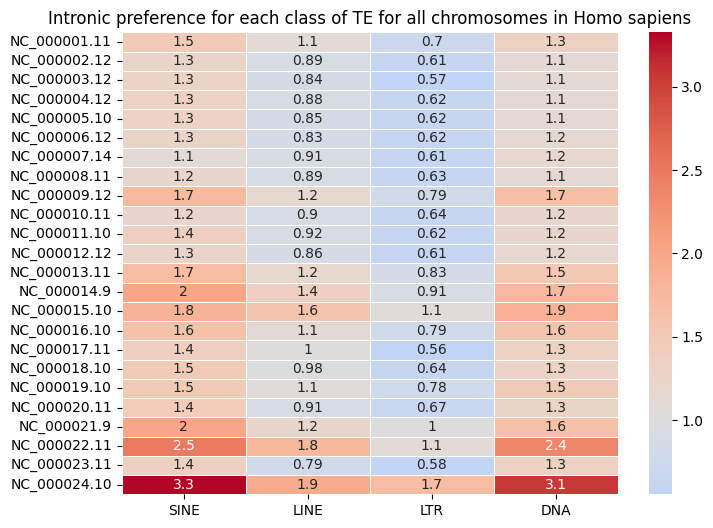

In [157]:
plt.figure(figsize=(8,6))
sns.heatmap(hs_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Homo sapiens")
plt.show()

Arabidopsis Thaliana

In [158]:
at_intronic_chr = df_per_chr(at_occs_per_chr_intronic)
print(at_intronic_chr)

             SINE      LINE       LTR       DNA
NC_003070.9   0.0  0.000609  0.001449  0.001053
NC_003071.7   0.0  0.000672  0.001614  0.001039
NC_003074.8   0.0  0.000362  0.000840  0.000774
NC_003075.7   0.0  0.000604  0.001072  0.000735
NC_003076.8   0.0  0.000337  0.000576  0.000249
NC_037304.1   0.0  0.000000  0.021678  0.000000
NC_000932.1   0.0  0.000000  0.000000  0.000000


In [159]:
at_intergenic_chr = df_per_chr(at_occs_per_chr_intergenic)
print(at_intergenic_chr)

             SINE      LINE       LTR       DNA
NC_003070.9   0.0  0.006317  0.052362  0.017415
NC_003071.7   0.0  0.014678  0.076641  0.032312
NC_003074.8   0.0  0.009427  0.077431  0.027245
NC_003075.7   0.0  0.006874  0.093661  0.024197
NC_003076.8   0.0  0.008917  0.066461  0.020098
NC_037304.1   0.0  0.003265  0.032617  0.000000
NC_000932.1   0.0  0.000000  0.000000  0.000000


In [160]:
at_pref_chr = df_pref_per_chr(at_occs_per_chr_intronic, at_occs_per_chr_intergenic)
at_pref_chr.fillna(value=np.nan, inplace=True)
print(at_pref_chr)

             SINE      LINE       LTR       DNA
NC_003070.9   NaN  0.096476  0.027664  0.060441
NC_003071.7   NaN  0.045807  0.021060  0.032156
NC_003074.8   NaN  0.038422  0.010847  0.028401
NC_003075.7   NaN  0.087893  0.011445  0.030376
NC_003076.8   NaN  0.037823  0.008666  0.012407
NC_037304.1   NaN  0.000000  0.664631       NaN
NC_000932.1   NaN       NaN       NaN       NaN


In [161]:
plt.figure(figsize=(8,6))
sns.heatmap(at_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Arabidopsis thaliana")
plt.show()

Drosophila Melanogaster

In [162]:
dm_intronic_chr = df_per_chr(dm_occs_per_chr_intronic)
print(dm_intronic_chr)

             SINE      LINE       LTR       DNA
NC_004354.4   0.0  0.007229  0.050042  0.010473
NT_033779.5   0.0  0.017060  0.044236  0.013142
NT_033778.4   0.0  0.048598  0.097616  0.027454
NT_037436.4   0.0  0.038670  0.085609  0.021337
NT_033777.3   0.0  0.051128  0.111245  0.018957
NC_004353.4   0.0  0.041460  0.062325  0.208124
NC_024512.1   0.0  0.143116  0.489276  0.038074


In [163]:
dm_intergenic_chr = df_per_chr(dm_occs_per_chr_intergenic)
print(dm_intergenic_chr)

             SINE      LINE       LTR       DNA
NC_004354.4   0.0  0.045231  0.061309  0.011329
NT_033779.5   0.0  0.016977  0.054860  0.013631
NT_033778.4   0.0  0.055246  0.122288  0.029482
NT_037436.4   0.0  0.048718  0.103749  0.017433
NT_033777.3   0.0  0.017676  0.048692  0.007154
NC_004353.4   0.0  0.127567  0.017240  0.065916
NC_024512.1   0.0  0.164367  0.472523  0.057094


In [164]:
dm_pref_chr = df_pref_per_chr(dm_occs_per_chr_intronic, dm_occs_per_chr_intergenic)
dm_pref_chr.fillna(value=np.nan, inplace=True)
print(dm_pref_chr)

             SINE      LINE       LTR       DNA
NC_004354.4   NaN  0.159820  0.816222  0.924411
NT_033779.5   NaN  1.004898  0.806341  0.964147
NT_033778.4   NaN  0.879652  0.798247  0.931218
NT_037436.4   NaN  0.793757  0.825161  1.223894
NT_033777.3   NaN  2.892457  2.284695  2.649856
NC_004353.4   NaN  0.325007  3.615057  3.157422
NC_024512.1   NaN  0.870715  1.035453  0.666872


In [165]:
plt.figure(figsize=(8,6))
sns.heatmap(dm_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Drosophila melanogaster")
plt.show()

Caenorhabditis elegans

In [166]:
ce_intronic_chr = df_per_chr(ce_occs_per_chr_intronic)
print(ce_intronic_chr)

                  SINE      LINE       LTR       DNA
NC_003279.8   0.000806  0.004072  0.000690  0.127066
NC_003280.10  0.000629  0.000944  0.000318  0.102533
NC_003281.10  0.000319  0.002469  0.000360  0.126652
NC_003282.8   0.000546  0.002757  0.003067  0.100001
NC_003283.11  0.000901  0.001709  0.001421  0.131303
NC_003284.9   0.003810  0.001874  0.000428  0.068544


In [167]:
ce_intergenic_chr = df_per_chr(ce_occs_per_chr_intergenic)
print(ce_intergenic_chr)

                  SINE      LINE       LTR       DNA
NC_003279.8   0.000347  0.003079  0.001791  0.045940
NC_003280.10  0.000255  0.003594  0.002215  0.049070
NC_003281.10  0.000258  0.002595  0.002352  0.041984
NC_003282.8   0.000296  0.004568  0.001054  0.047324
NC_003283.11  0.000505  0.004718  0.005049  0.050544
NC_003284.9   0.001300  0.005099  0.004938  0.035854


In [168]:
ce_pref_chr = df_pref_per_chr(ce_occs_per_chr_intronic, ce_occs_per_chr_intergenic)
ce_pref_chr.fillna(value=np.nan, inplace=True)
print(ce_pref_chr)

                  SINE      LINE       LTR       DNA
NC_003279.8   2.322227  1.322285  0.385079  2.765913
NC_003280.10  2.466564  0.262755  0.143349  2.089523
NC_003281.10  1.238742  0.951279  0.153179  3.016659
NC_003282.8   1.844085  0.603490  2.909806  2.113099
NC_003283.11  1.781763  0.362265  0.281519  2.597787
NC_003284.9   2.930635  0.367503  0.086587  1.911761


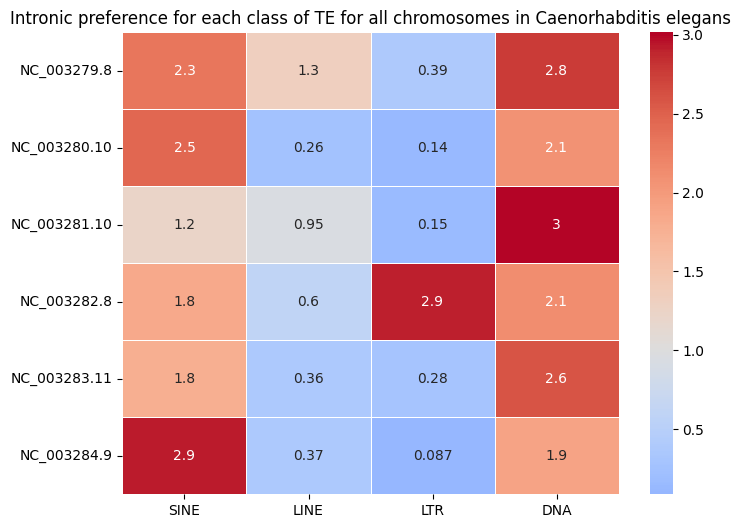

In [169]:
plt.figure(figsize=(8,6))
sns.heatmap(ce_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Caenorhabditis elegans")
plt.show()

### Preferencias cromosoma a cromosoma, por frecuencia

Mus musculus

In [170]:
values_intronic = mm_freqs_per_chr_intronic.values()
keys = mm_freqs_per_chr_intronic.keys()

mm_freqs_intronic_chr = pd.DataFrame(data=values_intronic, index=keys, columns=titles)
print(mm_freqs_intronic_chr)

              SINE   LINE    LTR   DNA
NC_000067.7  58139  26736  32304  7367
NC_000068.8  69880  26121  31870  7853
NC_000069.7  39389  20717  21495  4937
NC_000070.7  59696  21843  25656  5630
NC_000071.7  63059  19110  28791  5707
NC_000072.7  47448  21005  24512  6235
NC_000073.7  55350  20555  24951  5336
NC_000074.7  44080  16689  22861  4647
NC_000075.7  54626  16596  22355  5487
NC_000076.7  41795  18659  23611  5342
NC_000077.7  64965  15195  22377  5786
NC_000078.7  37700  15242  19476  4861
NC_000079.7  31837  15681  18734  4377
NC_000080.7  34461  16664  19290  4735
NC_000081.7  30939  13899  17118  3695
NC_000082.7  29029  13288  16019  3784
NC_000083.7  33385  10523  16410  3397
NC_000084.7  30657  15153  16306  3882
NC_000085.7  24672   8835  10579  2894
NC_000086.8  34121  24916  15283  4851
NC_000087.8   1655   1039    778    16


In [171]:
values_intergenic = mm_freqs_per_chr_intergenic.values()
keys = mm_freqs_per_chr_intergenic.keys()

mm_freqs_intergenic_chr = pd.DataFrame(data=values_intergenic, index=keys, columns=titles)
print(mm_freqs_intergenic_chr)

              SINE   LINE    LTR   DNA
NC_000067.7  45760  46168  51377  6902
NC_000068.8  43732  35946  39883  6075
NC_000069.7  35347  42998  41890  5801
NC_000070.7  42403  35351  39203  5279
NC_000071.7  39631  30564  38173  4825
NC_000072.7  35886  34523  35998  5079
NC_000073.7  39979  31309  37937  4461
NC_000074.7  31314  26086  32106  4471
NC_000075.7  33004  23525  29162  4470
NC_000076.7  29469  27037  32850  4673
NC_000077.7  40802  19362  28755  4306
NC_000078.7  28542  27962  30363  4627
NC_000079.7  27647  26353  32666  4608
NC_000080.7  25455  31531  29708  4162
NC_000081.7  22654  23567  26445  3572
NC_000082.7  20899  22633  24881  3363
NC_000083.7  23467  20509  24447  3042
NC_000084.7  20601  19907  22071  3187
NC_000085.7  15006  11303  13334  2151
NC_000086.8  43799  70281  52093  7174
NC_000087.8  19339  32790  48454  3302


In [172]:
mm_freqs_pref_chr = mm_freqs_intronic_chr / mm_freqs_intergenic_chr
print(mm_freqs_pref_chr)

                 SINE      LINE       LTR       DNA
NC_000067.7  1.270520  0.579102  0.628764  1.067372
NC_000068.8  1.597915  0.726673  0.799087  1.292675
NC_000069.7  1.114352  0.481813  0.513130  0.851060
NC_000070.7  1.407825  0.617889  0.654440  1.066490
NC_000071.7  1.591153  0.625245  0.754224  1.182798
NC_000072.7  1.322187  0.608435  0.680927  1.227604
NC_000073.7  1.384477  0.656520  0.657696  1.196144
NC_000074.7  1.407677  0.639768  0.712048  1.039365
NC_000075.7  1.655133  0.705462  0.766580  1.227517
NC_000076.7  1.418270  0.690128  0.718752  1.143163
NC_000077.7  1.592201  0.784785  0.778195  1.343706
NC_000078.7  1.320860  0.545097  0.641439  1.050573
NC_000079.7  1.151554  0.595037  0.573502  0.949870
NC_000080.7  1.353801  0.528496  0.649320  1.137674
NC_000081.7  1.365719  0.589765  0.647306  1.034434
NC_000082.7  1.389014  0.587107  0.643825  1.125186
NC_000083.7  1.422636  0.513092  0.671248  1.116700
NC_000084.7  1.488132  0.761190  0.738798  1.218073
NC_000085.7 

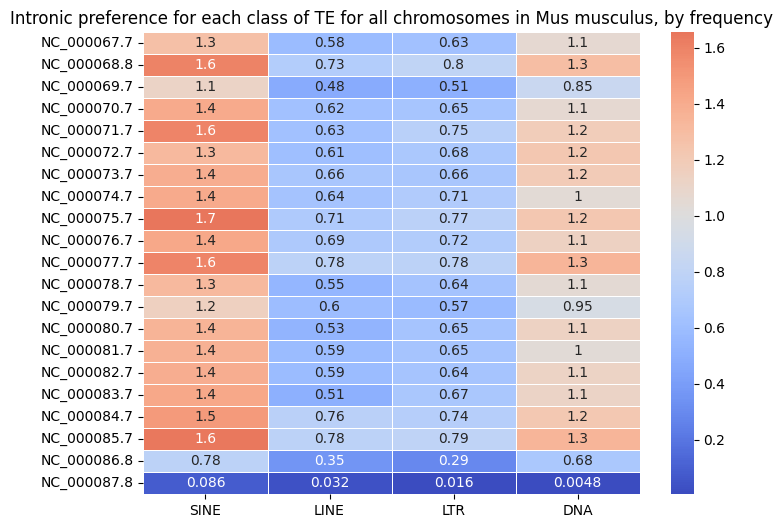

In [173]:
plt.figure(figsize=(8,6))
sns.heatmap(mm_freqs_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Mus musculus, by frequency")
plt.show()

Homo sapiens

In [174]:
values_intronic = hs_freqs_per_chr_intronic.values()
keys = hs_freqs_per_chr_intronic.keys()

hs_freqs_intronic_chr = pd.DataFrame(data=values_intronic, index=keys, columns=titles)
print(hs_freqs_intronic_chr)

               SINE   LINE    LTR    DNA
NC_000001.11  99861  78312  24801  30661
NC_000002.12  78239  74110  27434  31949
NC_000003.12  71304  65165  23995  29291
NC_000004.12  50896  52283  23044  20309
NC_000005.10  56943  54205  21301  22865
NC_000006.12  52856  50353  18812  22063
NC_000007.14  54961  47789  17381  20391
NC_000008.11  46823  43682  17522  17275
NC_000009.12  45906  37615  12660  15542
NC_000010.11  50270  40432  14533  18088
NC_000011.10  52449  43768  14356  16475
NC_000012.12  56262  44445  16452  19620
NC_000013.11  23431  25497  10221   9847
NC_000014.9   33899  27848  10720  11829
NC_000015.10  36478  29942   9386  12878
NC_000016.10  42939  23669   9202  12214
NC_000017.11  47997  25501   7042  12457
NC_000018.10  20798  20628   7266   8608
NC_000019.10  40900  15797   6863   7379
NC_000020.11  26775  18893   7035   9398
NC_000021.9   10097   8748   5193   3661
NC_000022.11  22478  12155   3678   4714
NC_000023.11  32074  36995  11748  13822
NC_000024.10   2

In [175]:
values_intergenic = hs_freqs_per_chr_intergenic.values()
keys = hs_freqs_per_chr_intergenic.keys()

hs_freqs_intergenic_chr = pd.DataFrame(data=values_intergenic, index=keys, columns=titles)
print(hs_freqs_intergenic_chr)

               SINE   LINE    LTR    DNA
NC_000001.11  58449  53658  30111  18409
NC_000002.12  48415  55780  33316  20898
NC_000003.12  37344  44183  26906  16222
NC_000004.12  35904  47605  32702  15713
NC_000005.10  36865  44410  27528  15917
NC_000006.12  34272  40948  23941  14574
NC_000007.14  38278  35459  21529  12656
NC_000008.11  31446  35263  21545  11602
NC_000009.12  28897  29562  17056   9918
NC_000010.11  30560  29109  16437  10858
NC_000011.10  30428  31676  17275  10098
NC_000012.12  30999  29493  18092  10819
NC_000013.11  19403  26578  16664   8525
NC_000014.9   19554  20270  12903   7244
NC_000015.10  19430  17301   8457   6699
NC_000016.10  27508  17838  11488   7800
NC_000017.11  26015  16160   8967   6615
NC_000018.10  15715  20004  11937   6770
NC_000019.10  23133  10394   7257   3780
NC_000020.11  18396  16194   9866   7240
NC_000021.9    7824   9007   7476   3081
NC_000022.11  12195   7502   4265   2580
NC_000023.11  37704  59736  30328  15274
NC_000024.10   7

In [176]:
hs_freqs_pref_chr = hs_freqs_intronic_chr / hs_freqs_intergenic_chr
print(hs_freqs_pref_chr)

                  SINE      LINE       LTR       DNA
NC_000001.11  1.708515  1.459466  0.823652  1.665544
NC_000002.12  1.616007  1.328612  0.823448  1.528807
NC_000003.12  1.909383  1.474889  0.891809  1.805634
NC_000004.12  1.417558  1.098267  0.704666  1.292497
NC_000005.10  1.544636  1.220558  0.773794  1.436514
NC_000006.12  1.542250  1.229682  0.785765  1.513860
NC_000007.14  1.435838  1.347726  0.807330  1.611173
NC_000008.11  1.488997  1.238749  0.813275  1.488967
NC_000009.12  1.588608  1.272411  0.742261  1.567050
NC_000010.11  1.644961  1.388986  0.884164  1.665868
NC_000011.10  1.723708  1.381740  0.831027  1.631511
NC_000012.12  1.814962  1.506968  0.909352  1.813476
NC_000013.11  1.207597  0.959327  0.613358  1.155073
NC_000014.9   1.733609  1.373853  0.830815  1.632938
NC_000015.10  1.877406  1.730651  1.109850  1.922376
NC_000016.10  1.560964  1.326886  0.801010  1.565897
NC_000017.11  1.844974  1.578032  0.785324  1.883144
NC_000018.10  1.323449  1.031194  0.608696  1.

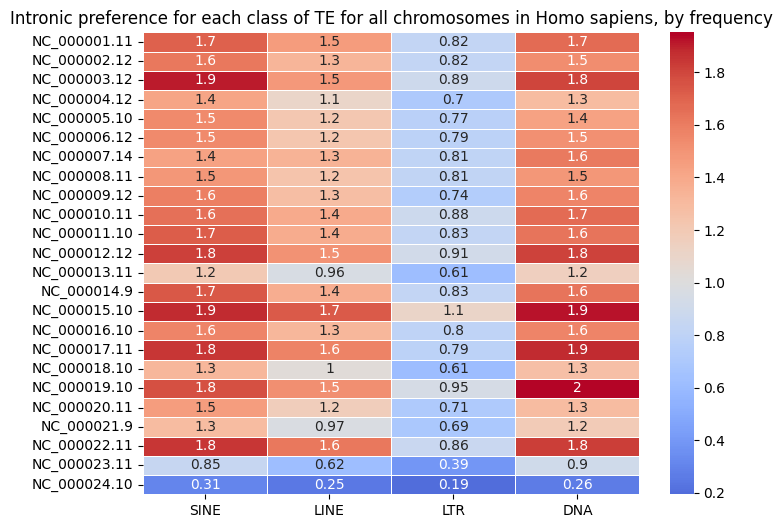

In [177]:
plt.figure(figsize=(8,6))
sns.heatmap(hs_freqs_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Homo sapiens, by frequency")
plt.show()

Arabidopsis thaliana

In [178]:
values_intronic = at_freqs_per_chr_intronic.values()
keys = at_freqs_per_chr_intronic.keys()

at_freqs_intronic_chr = pd.DataFrame(data=values_intronic, index=keys, columns=titles)
print(at_freqs_intronic_chr)

             SINE  LINE  LTR  DNA
NC_003070.9     0    17   36   17
NC_003071.7     0    16   25    7
NC_003074.8     0     9   15   13
NC_003075.7     0    16   21    8
NC_003076.8     0    15   17    7
NC_037304.1     0     0    9    0
NC_000932.1     0     0    0    0


In [179]:
values_intergenic = at_freqs_per_chr_intergenic.values()
keys = at_freqs_per_chr_intergenic.keys()

at_freqs_intergenic_chr = pd.DataFrame(data=values_intergenic, index=keys, columns=titles)
print(at_freqs_intergenic_chr)

             SINE  LINE   LTR  DNA
NC_003070.9     0   277  1291  664
NC_003071.7     0   380  1356  824
NC_003074.8     0   296  1572  794
NC_003075.7     0   206  1332  625
NC_003076.8     0   325  1442  675
NC_037304.1     0     2    48    0
NC_000932.1     0     0     0    0


In [180]:
at_freqs_pref_chr = at_freqs_intronic_chr / at_freqs_intergenic_chr
at_freqs_pref_chr.replace([np.inf, -np.inf], 100, inplace=True)
print(at_freqs_pref_chr)

             SINE      LINE       LTR       DNA
NC_003070.9   NaN  0.061372  0.027885  0.025602
NC_003071.7   NaN  0.042105  0.018437  0.008495
NC_003074.8   NaN  0.030405  0.009542  0.016373
NC_003075.7   NaN  0.077670  0.015766  0.012800
NC_003076.8   NaN  0.046154  0.011789  0.010370
NC_037304.1   NaN  0.000000  0.187500       NaN
NC_000932.1   NaN       NaN       NaN       NaN


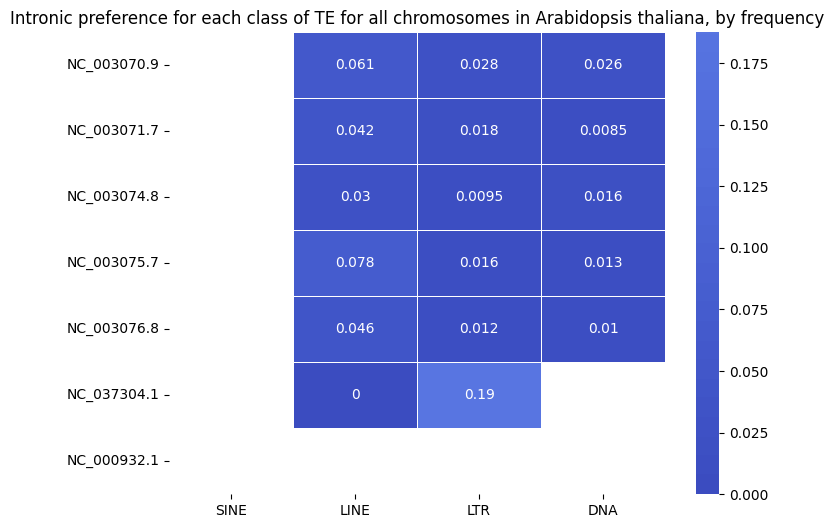

In [181]:
plt.figure(figsize=(8,6))
sns.heatmap(at_freqs_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Arabidopsis thaliana, by frequency")
plt.show()

Drosophila melanogaster

In [182]:
values_intronic = dm_freqs_per_chr_intronic.values()
keys = dm_freqs_per_chr_intronic.keys()

dm_freqs_intronic_chr = pd.DataFrame(data=values_intronic, index=keys, columns=titles)
print(dm_freqs_intronic_chr)

             SINE  LINE   LTR   DNA
NC_004354.4     0    82   411   472
NT_033779.5     0   165   321   513
NT_033778.4     0   696  1265  1045
NT_037436.4     0   578  1105   846
NT_033777.3     0   937  2020   837
NC_004353.4     0    51    39   520
NC_024512.1     0   225   695   133


In [183]:
values_intergenic = dm_freqs_per_chr_intergenic.values()
keys = dm_freqs_per_chr_intergenic.keys()

dm_freqs_intergenic_chr = pd.DataFrame(data=values_intergenic, index=keys, columns=titles)
print(dm_freqs_intergenic_chr)

             SINE  LINE   LTR   DNA
NC_004354.4     0   494   784   492
NT_033779.5     0   286   979   656
NT_033778.4     0   994  2134  1150
NT_037436.4     0   948  2124   942
NT_033777.3     0   278   881   428
NC_004353.4     0    76    15   186
NC_024512.1     0   594  1486   333


In [184]:
dm_freqs_pref_chr = dm_freqs_intronic_chr / dm_freqs_intergenic_chr
print(dm_freqs_pref_chr)

             SINE      LINE       LTR       DNA
NC_004354.4   NaN  0.165992  0.524235  0.959350
NT_033779.5   NaN  0.576923  0.327886  0.782012
NT_033778.4   NaN  0.700201  0.592784  0.908696
NT_037436.4   NaN  0.609705  0.520245  0.898089
NT_033777.3   NaN  3.370504  2.292849  1.955607
NC_004353.4   NaN  0.671053  2.600000  2.795699
NC_024512.1   NaN  0.378788  0.467699  0.399399


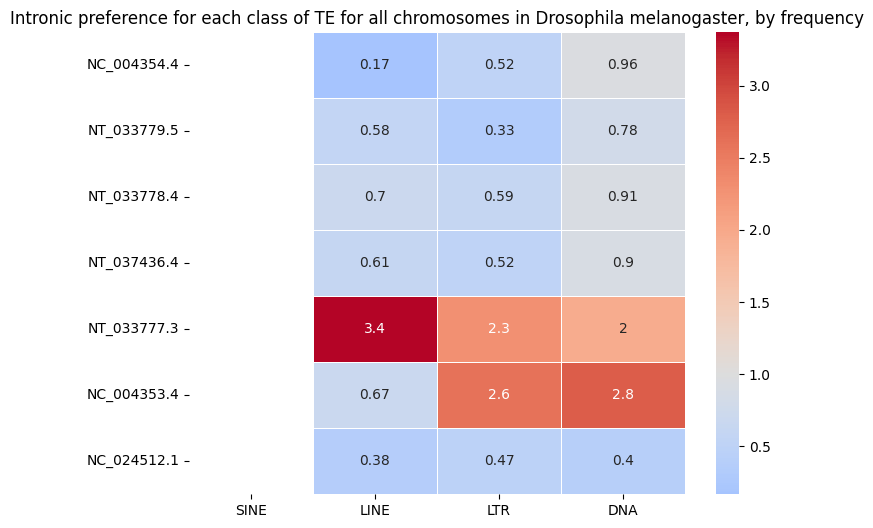

In [185]:
plt.figure(figsize=(8,6))
sns.heatmap(dm_freqs_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Drosophila melanogaster, by frequency")
plt.show()

Caenorhabditis elegans

In [186]:
values_intronic = ce_freqs_per_chr_intronic.values()
keys = ce_freqs_per_chr_intronic.keys()

ce_freqs_intronic_chr = pd.DataFrame(data=values_intronic, index=keys, columns=titles)
print(ce_freqs_intronic_chr)

              SINE  LINE  LTR   DNA
NC_003279.8     30    33   17  3615
NC_003280.10    15    11    7  2346
NC_003281.10    10    22    9  3072
NC_003282.8     21    24   21  2436
NC_003283.11    41    29   15  3351
NC_003284.9    109    30   11  1735


In [187]:
values_intergenic = ce_freqs_per_chr_intergenic.values()
keys = ce_freqs_per_chr_intergenic.keys()

ce_freqs_intergenic_chr = pd.DataFrame(data=values_intergenic, index=keys, columns=titles)
print(ce_freqs_intergenic_chr)

              SINE  LINE  LTR   DNA
NC_003279.8     18    47   37  2020
NC_003280.10    18    56   43  2043
NC_003281.10    13    33   25  1743
NC_003282.8     23    76   41  2143
NC_003283.11    48   112   99  3080
NC_003284.9     90    82  117  1959


In [188]:
ce_freqs_pref_chr = ce_freqs_intronic_chr / ce_freqs_intergenic_chr
print(ce_freqs_pref_chr)

                  SINE      LINE       LTR       DNA
NC_003279.8   1.666667  0.702128  0.459459  1.789604
NC_003280.10  0.833333  0.196429  0.162791  1.148311
NC_003281.10  0.769231  0.666667  0.360000  1.762478
NC_003282.8   0.913043  0.315789  0.512195  1.136724
NC_003283.11  0.854167  0.258929  0.151515  1.087987
NC_003284.9   1.211111  0.365854  0.094017  0.885656


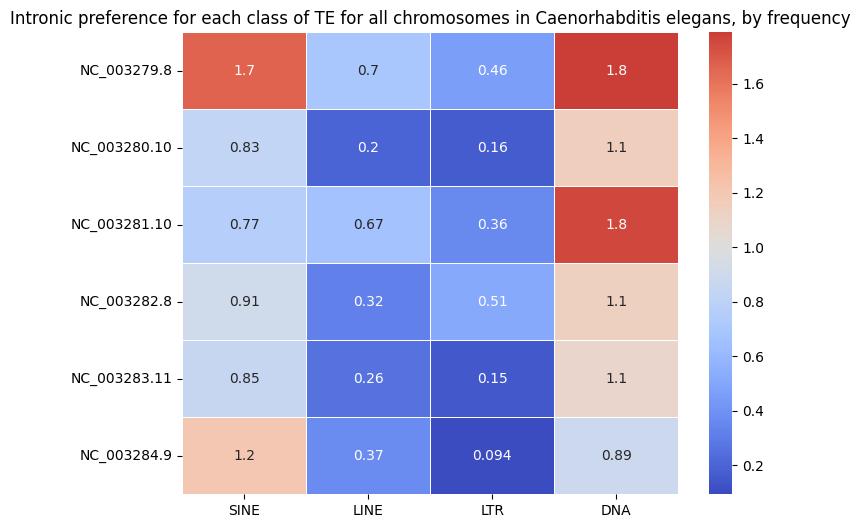

In [189]:
plt.figure(figsize=(8,6))
sns.heatmap(ce_freqs_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Caenorhabditis elegans, by frequency")
plt.show()

In [190]:
all_df

SINE_intronic_length  LINE_intronic_length  LTR_intronic_length  \
MM            134.478780            446.044470           259.270603   
HS            225.107262            373.819889           353.571689   
AT              0.000000            127.232877           167.601626   
DM              0.000000            796.979592           906.991996   
CE            168.327434            520.691275           445.862500   

    DNA_intronic_length  SINE_intergenic_length  LINE_intergenic_length  \
MM           188.891410              136.490211              600.288530   
HS           192.158959              225.896991              452.041437   
AT           267.365385                0.000000              611.880888   
DM           288.522176                0.000000              824.126984   
CE           218.935065              168.000000              679.926108   

    LTR_intergenic_length  DNA_intergenic_length  SINE_intronic_freq  \
MM             320.913527             214.409769              887568   
HS             375.818228             205.828035             1126218   
AT            1018.746201             662.192630                   0   
DM             774.636489             331.319635                   0   
CE             577.660221             235.194641                 226   

    LINE_intronic_freq  ...  LTR_intergenic_freq  DNA_intergenic_freq  \
MM              359029  ...               713492                95610   
HS              927050  ...               455401               262996   
AT                  73  ...                 7041                 3582   
DM                2744  ...                11642                 4599   
CE                 149  ...                  362                12988   

    SINE_occ_intronic  LINE_occ_intronic  LTR_occ_intronic  DNA_occ_intronic  \
MM           0.103383           0.138708          0.096852          0.016498   
HS           0.150688           0.205983          0.071625          0.044661   
AT           0.000000           0.000506          0.001123          0.000758   
DM           0.000000           0.035581          0.086652          0.020533   
CE           0.001157           0.002359          0.001085          0.110203   

    SINE_occ_intergenic  LINE_occ_intergenic  LTR_occ_intergenic  \
MM             0.057938             0.245342            0.145943   
HS             0.053795             0.111304            0.055418   
AT             0.000000             0.007598            0.059940   
DM             0.000000             0.029816            0.065556   
CE             0.000352             0.002753            0.002085   

    DNA_occ_intergenic  
MM            0.013066  
HS            0.017528  
AT            0.019821  
DM            0.011076  
CE            0.030460  

[5 rows x 24 columns]

In [191]:
mm_ilen_normalized = min_max_normalize(mm_intronic_lengths)
mm_igeniclen_normalized = min_max_normalize(mm_intergenic_lengths)
mm_ifreqs = min_max_normalize(mm_intronic_freqs)
mm_igenicfreqs = min_max_normalize(mm_intergenic_freqs)

In [192]:
hs_ilen_normalized = min_max_normalize(hs_intronic_lengths)
hs_igeniclen_normalized = min_max_normalize(hs_intergenic_lengths)
hs_ifreqs = min_max_normalize(hs_intronic_freqs)
hs_igenicfreqs = min_max_normalize(hs_intergenic_freqs)

In [193]:
at_ilen_normalized = min_max_normalize(at_intronic_lengths)
at_igeniclen_normalized = min_max_normalize(at_intergenic_lengths)
at_ifreqs = min_max_normalize(at_intronic_freqs)
at_igenicfreqs = min_max_normalize(at_intergenic_freqs)

In [194]:
dm_ilen_normalized = min_max_normalize(dm_intronic_lengths)
dm_igeniclen_normalized = min_max_normalize(dm_intergenic_lengths)
dm_ifreqs = min_max_normalize(dm_intronic_freqs)
dm_igenicfreqs = min_max_normalize(dm_intergenic_freqs)

In [195]:
ce_ilen_normalized = min_max_normalize(ce_intronic_lengths)
ce_igeniclen_normalized = min_max_normalize(ce_intergenic_lengths)
ce_ifreqs = min_max_normalize(ce_intronic_freqs)
ce_igenicfreqs = min_max_normalize(ce_intergenic_freqs)

In [197]:
for_mm = mm_ilen_normalized + mm_igeniclen_normalized + mm_ifreqs + mm_igenicfreqs + mm_occs_intronic + mm_occs_intergenic
for_hs = hs_ilen_normalized + hs_igeniclen_normalized + hs_ifreqs + mm_igenicfreqs + hs_occs_intronic + hs_occs_intergenic
for_at = at_ilen_normalized + at_igeniclen_normalized + at_ifreqs + at_igenicfreqs + at_occs_intronic + at_occs_intergenic
for_dm = dm_ilen_normalized + dm_igeniclen_normalized + dm_ifreqs + dm_igenicfreqs + dm_occs_intronic + dm_occs_intergenic
for_ce = ce_ilen_normalized + ce_igeniclen_normalized + ce_ifreqs + ce_igenicfreqs + ce_occs_intronic + ce_occs_intergenic

columns = ['SINE_intronic_length', 'LINE_intronic_length', 'LTR_intronic_length', 'DNA_intronic_length',
            'SINE_intergenic_length', 'LINE_intergenic_length', 'LTR_intergenic_length', 'DNA_intergenic_length',
            'SINE_intronic_freq', 'LINE_intronic_freq', 'LTR_intronic_freq', 'DNA_intronic_freq',
            'SINE_intergenic_freq', 'LINE_intergenic_freq', 'LTR_intergenic_freq', 'DNA_intergenic_freq',
            'SINE_occ_intronic', 'LINE_occ_intronic', 'LTR_occ_intronic', 'DNA_occ_intronic',
            'SINE_occ_intergenic', 'LINE_occ_intergenic', 'LTR_occ_intergenic', 'DNA_occ_intergenic',]

data = [for_mm, for_hs, for_at, for_dm, for_ce]
organism_names = ["MM", "HS", "AT", "DM", "CE"]
all_normalized_df = pd.DataFrame(data=data, columns=columns, index=organism_names)

print(all_normalized_df)

    SINE_intronic_length  LINE_intronic_length  LTR_intronic_length  \
MM              0.000000              1.000000             0.400531   
HS              0.181373              1.000000             0.888539   
AT              0.000000              0.475876             0.626864   
DM              0.000000              0.878706             1.000000   
CE              0.000000              1.000000             0.787638   

    DNA_intronic_length  SINE_intergenic_length  LINE_intergenic_length  \
MM             0.174643                 0.00000                1.000000   
HS             0.000000                 0.08151                1.000000   
AT             1.000000                 0.00000                0.600622   
DM             0.318109                 0.00000                1.000000   
CE             0.143623                 0.00000                1.000000   

    LTR_intergenic_length  DNA_intergenic_length  SINE_intronic_freq  \
MM               0.397637               0.168003  

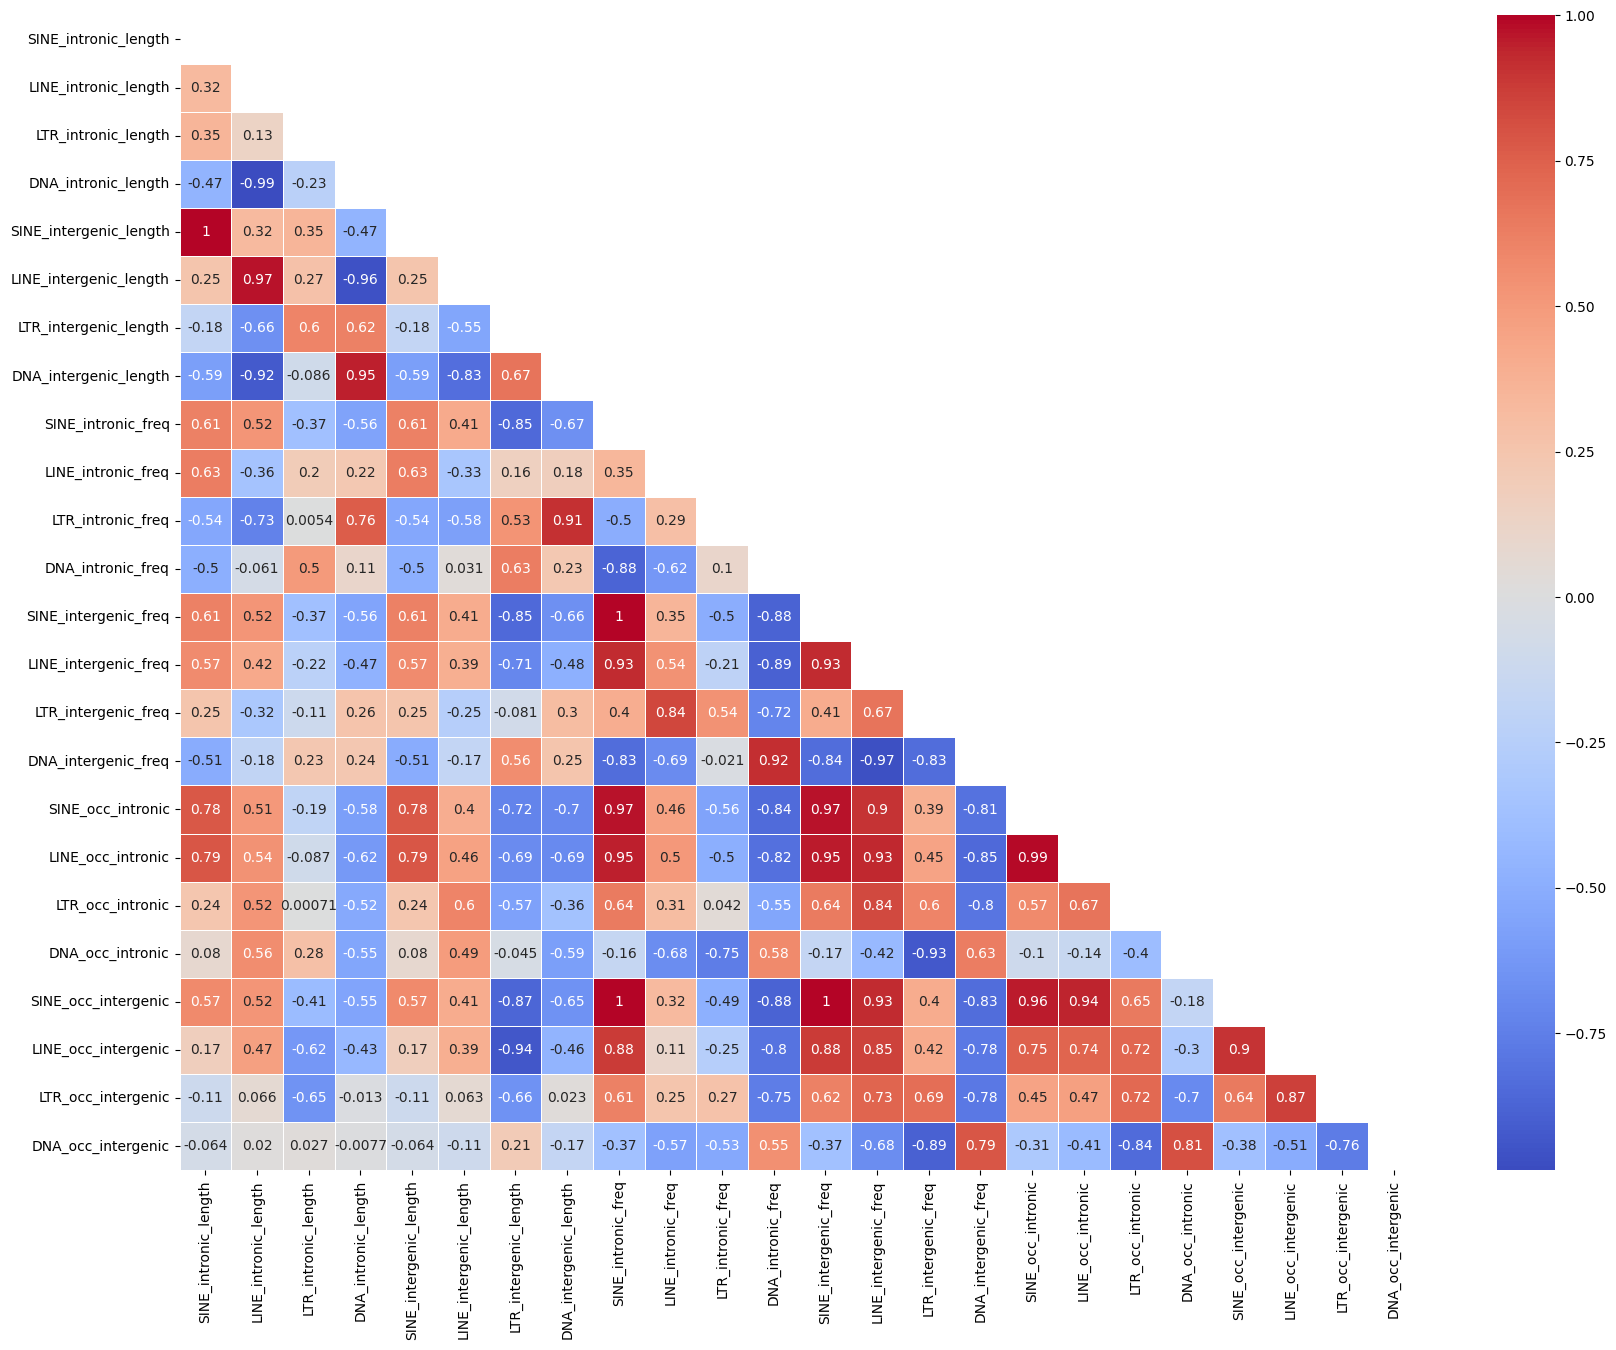

In [198]:
corr_matrix = all_normalized_df.corr()

plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)

plt.show()

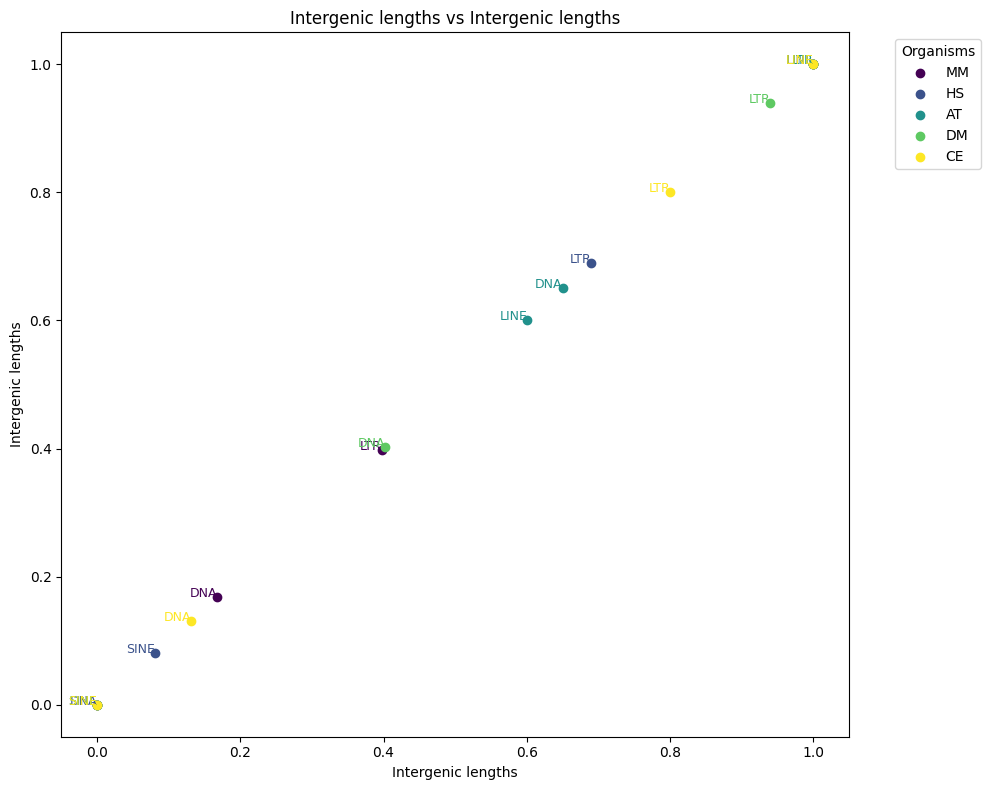

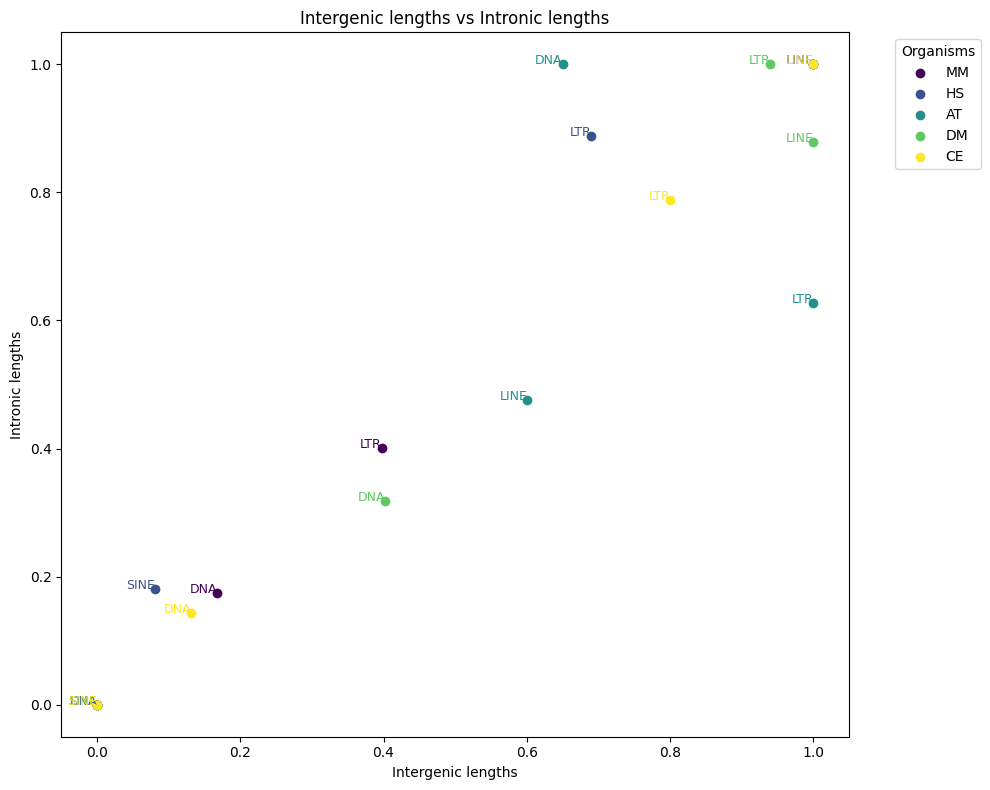

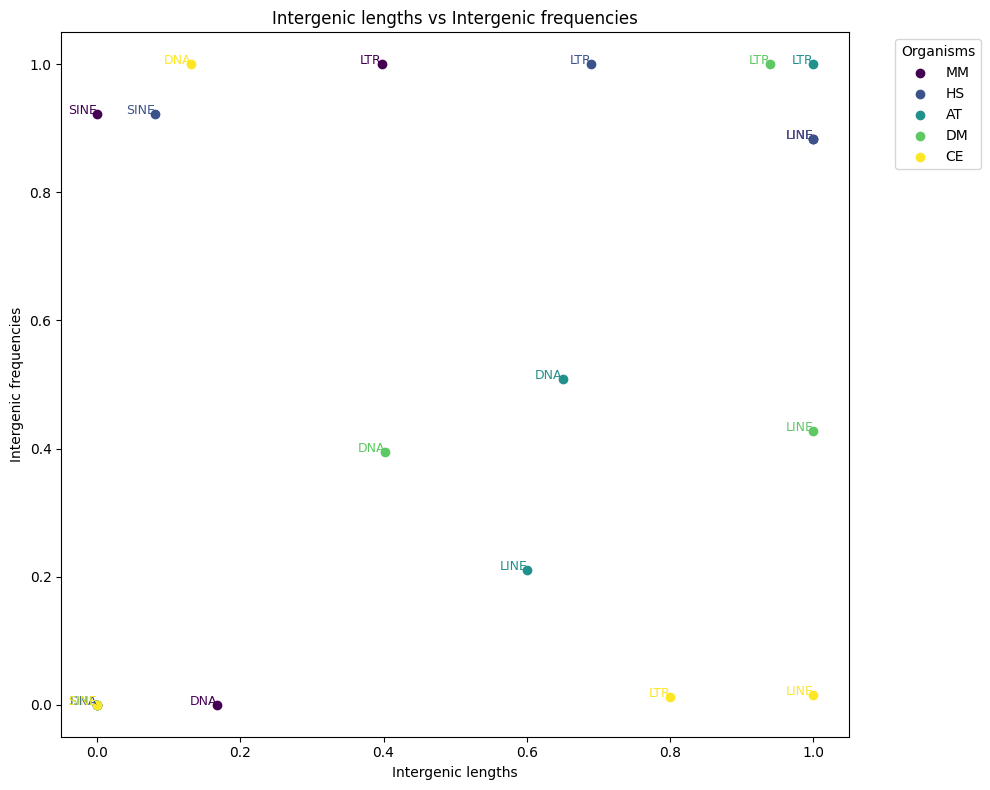

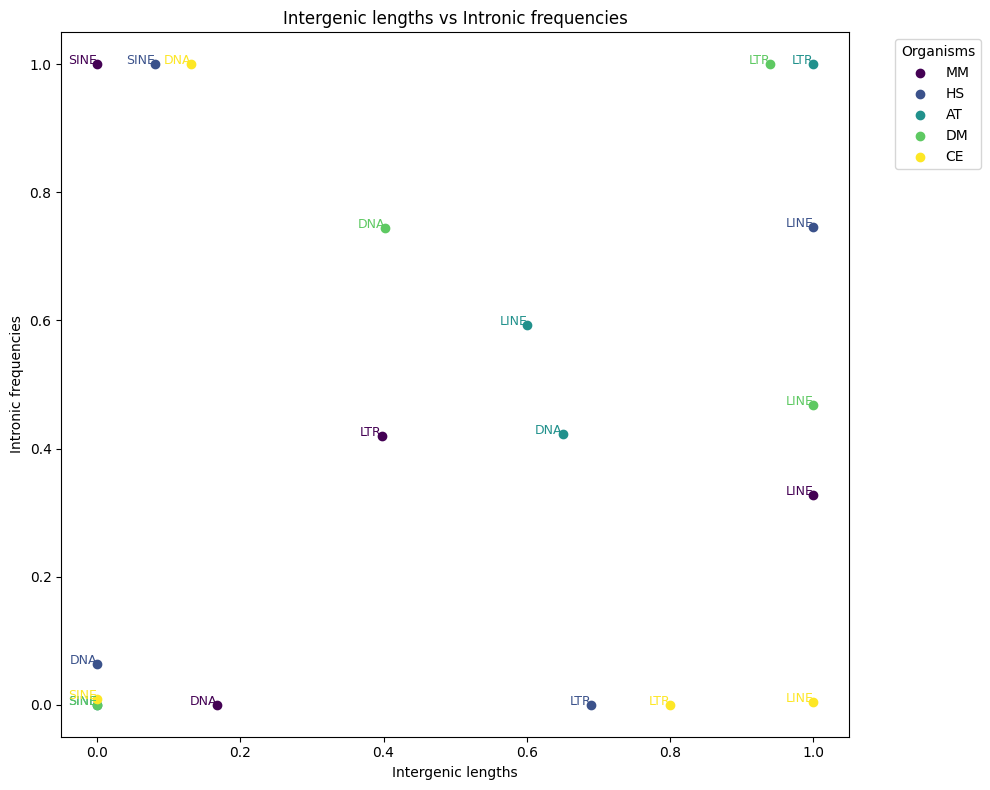

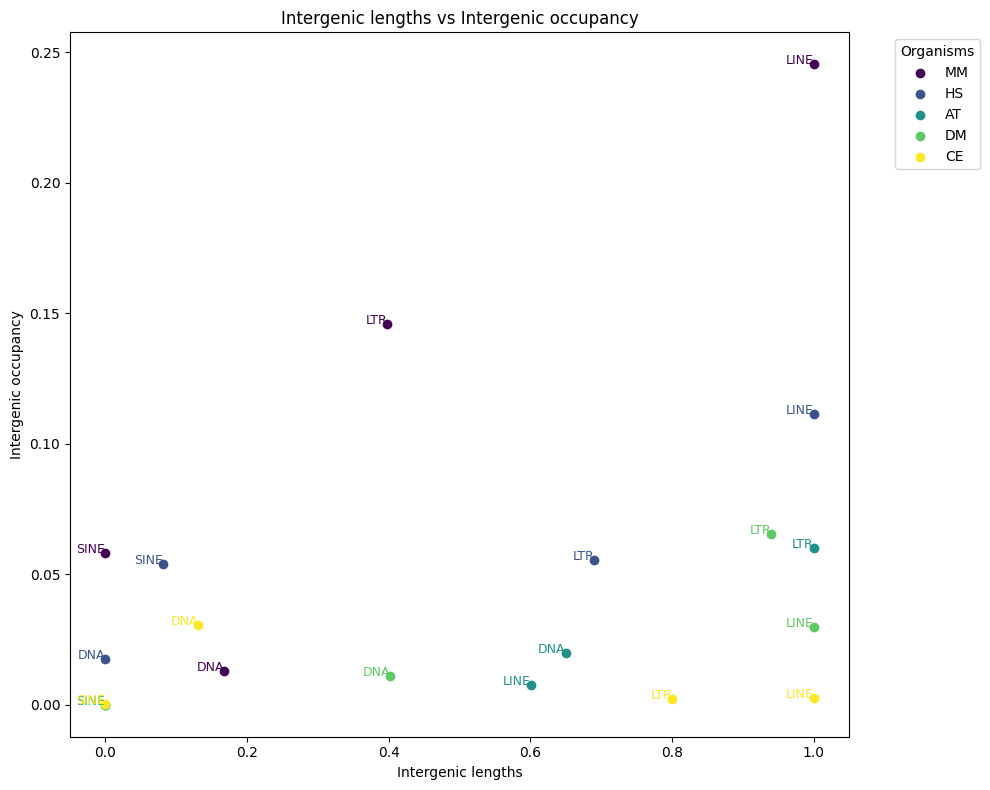

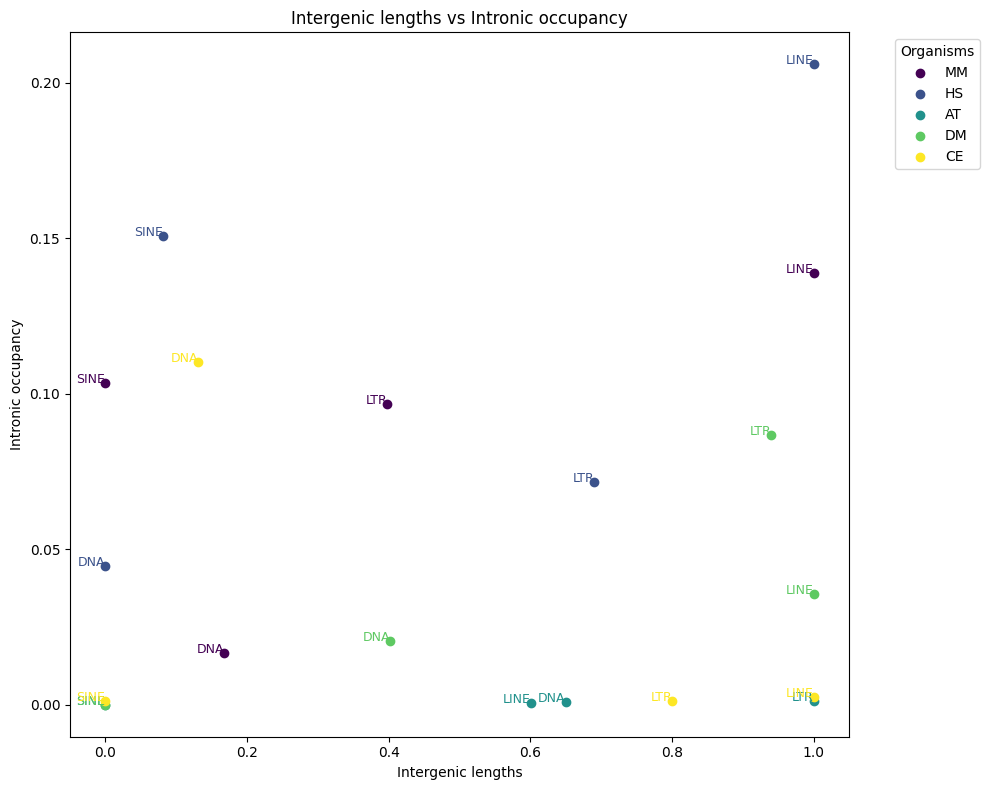

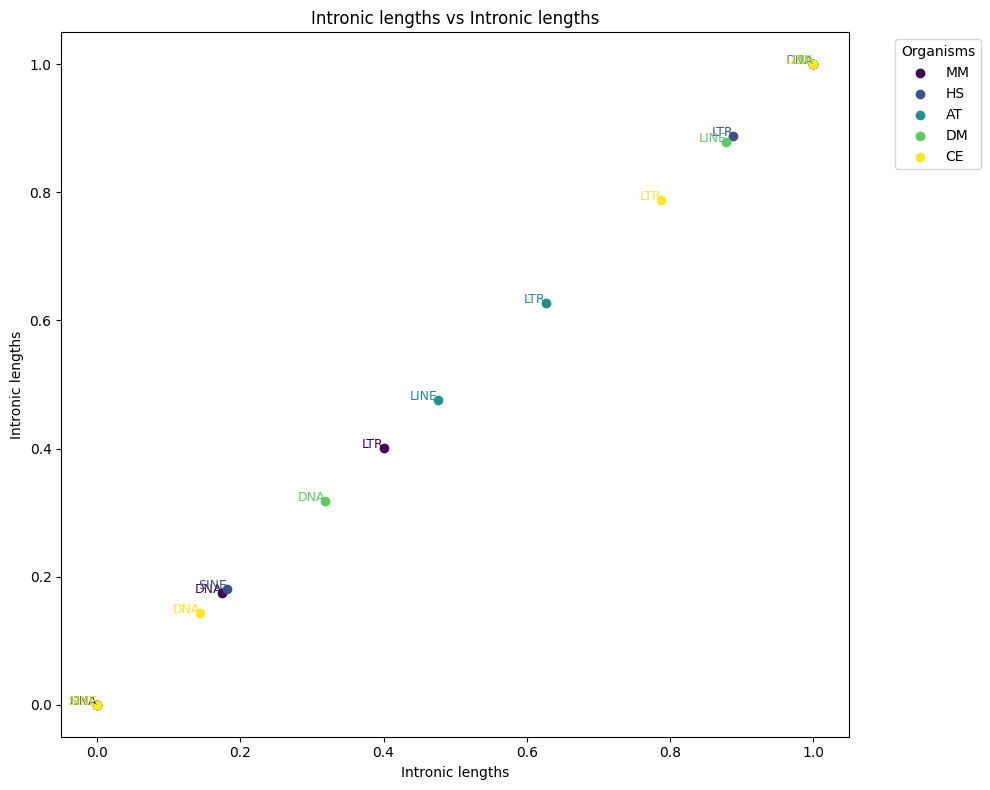

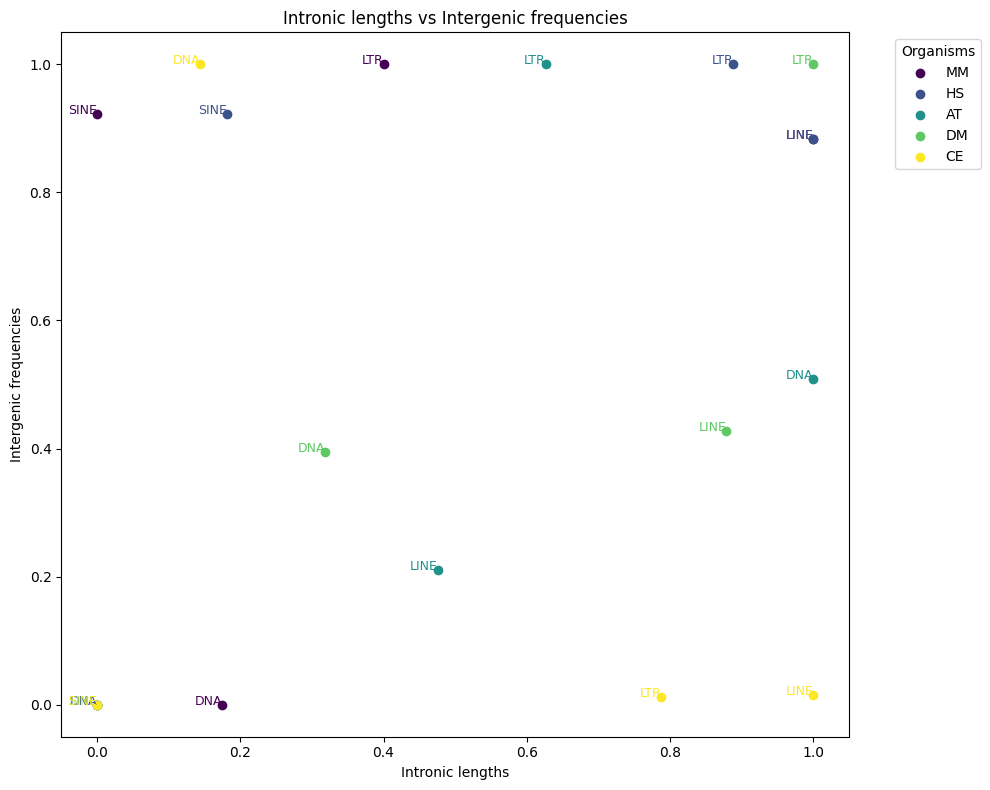

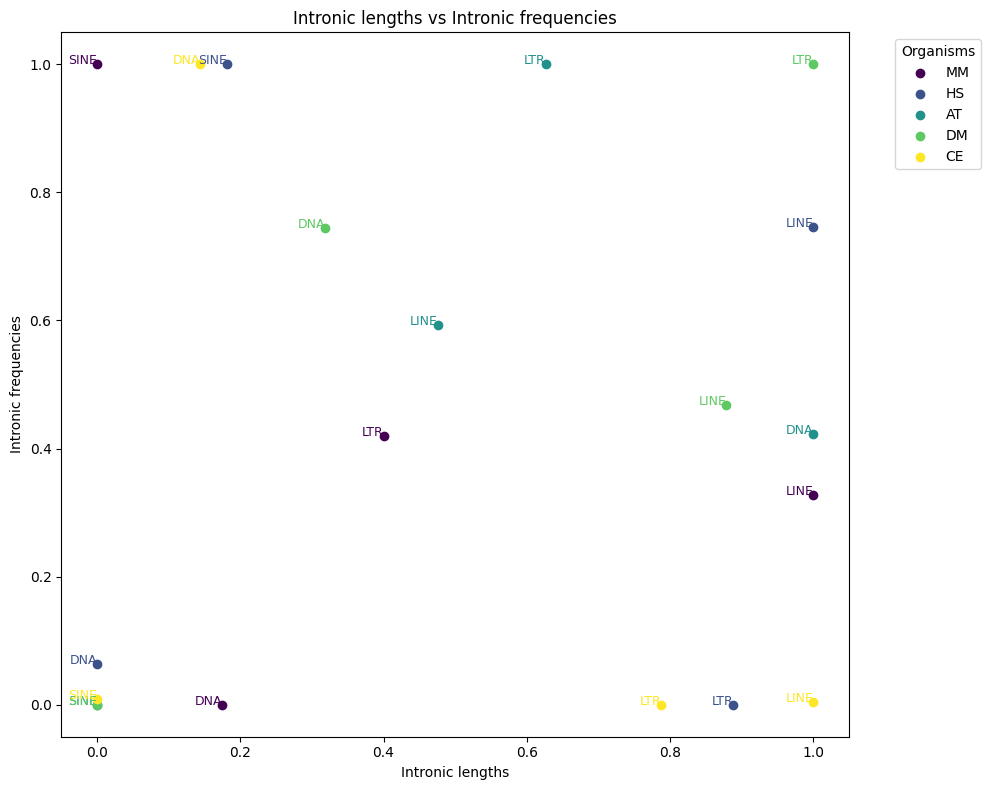

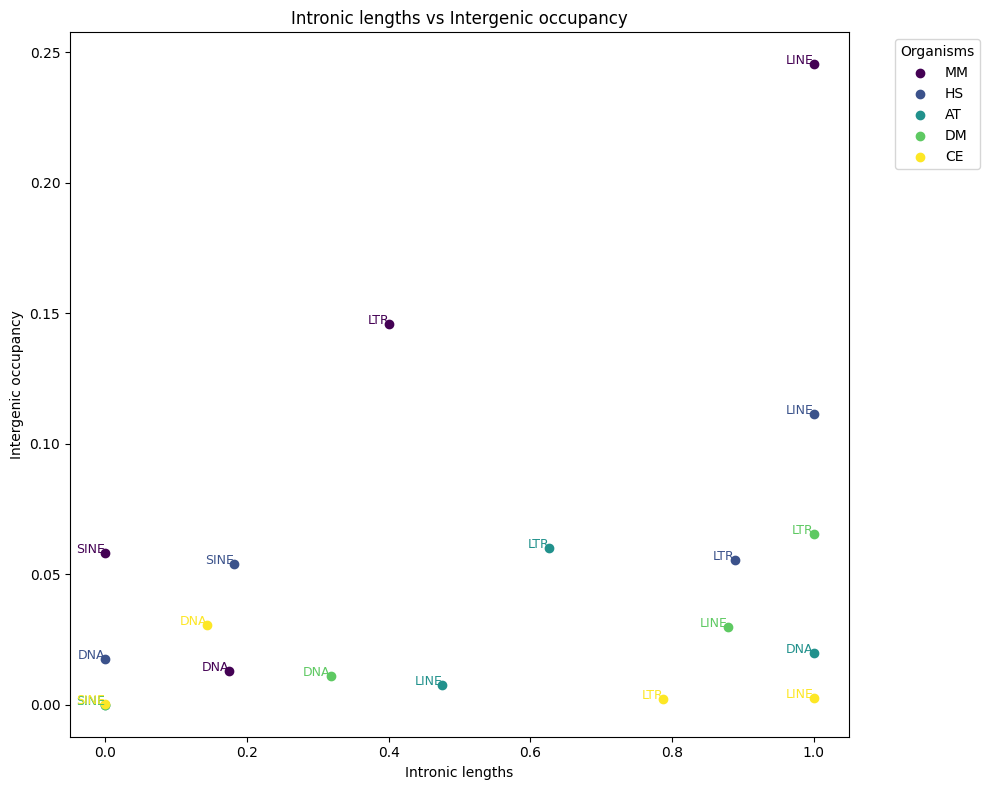

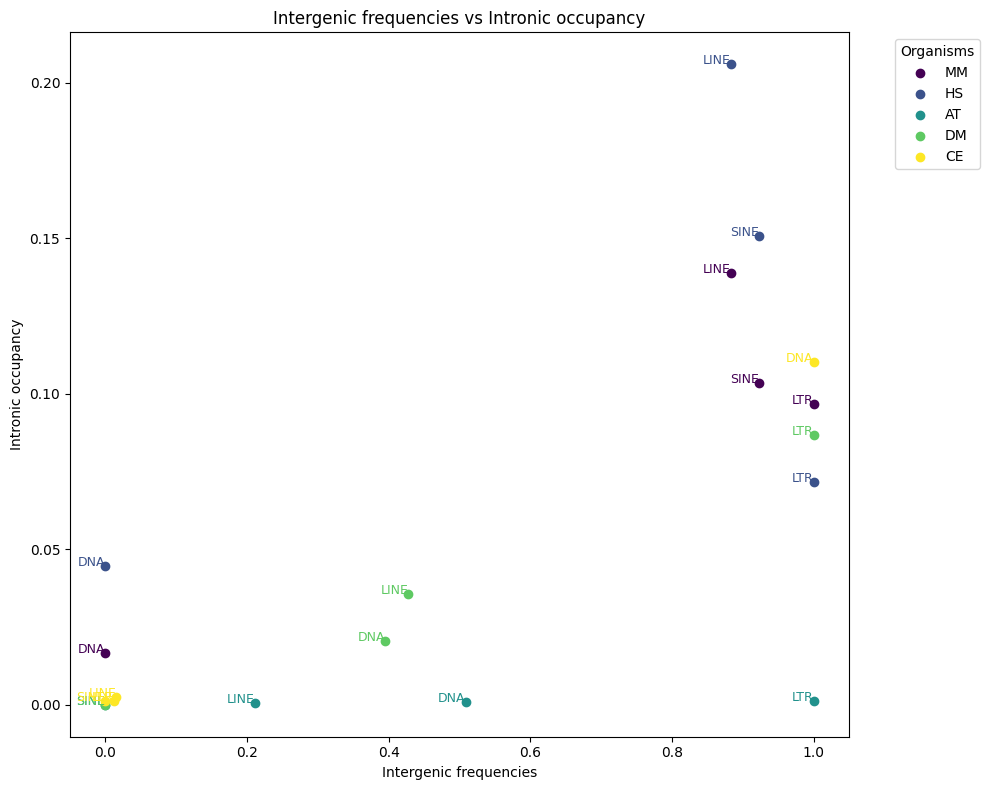

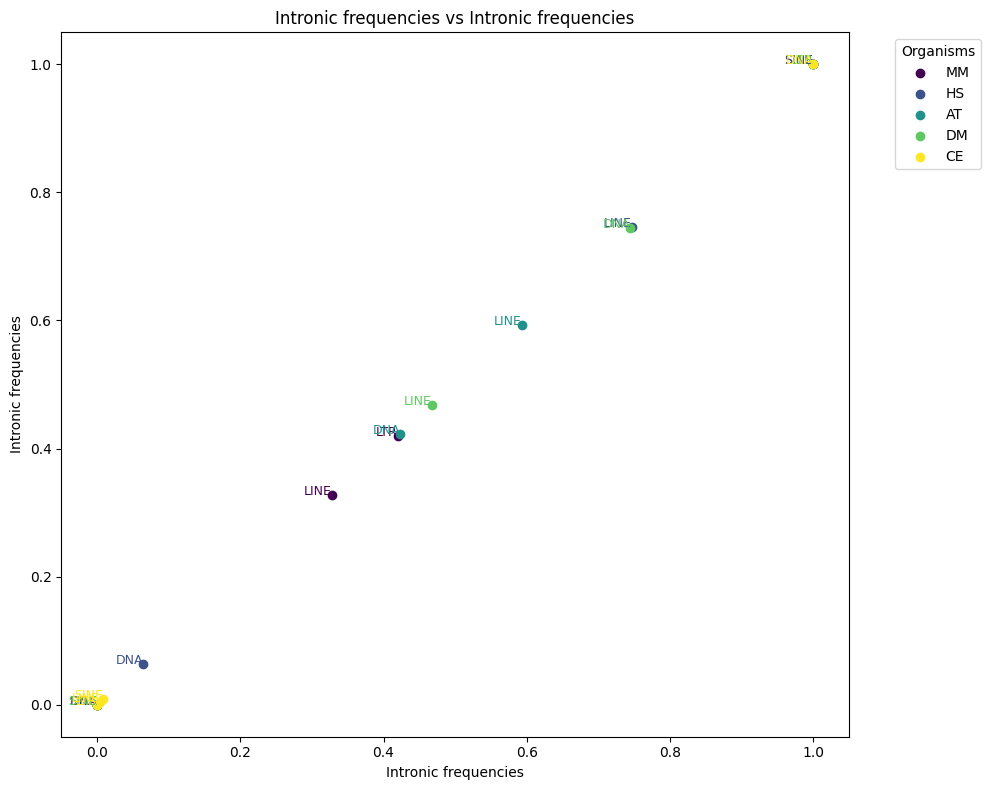

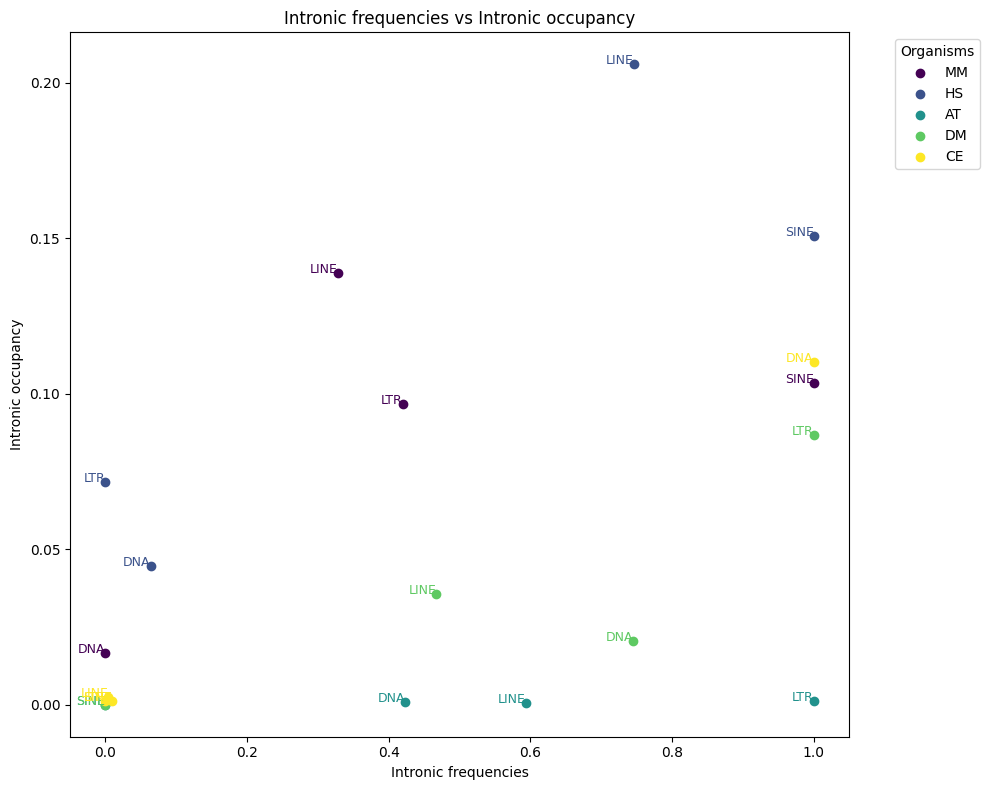

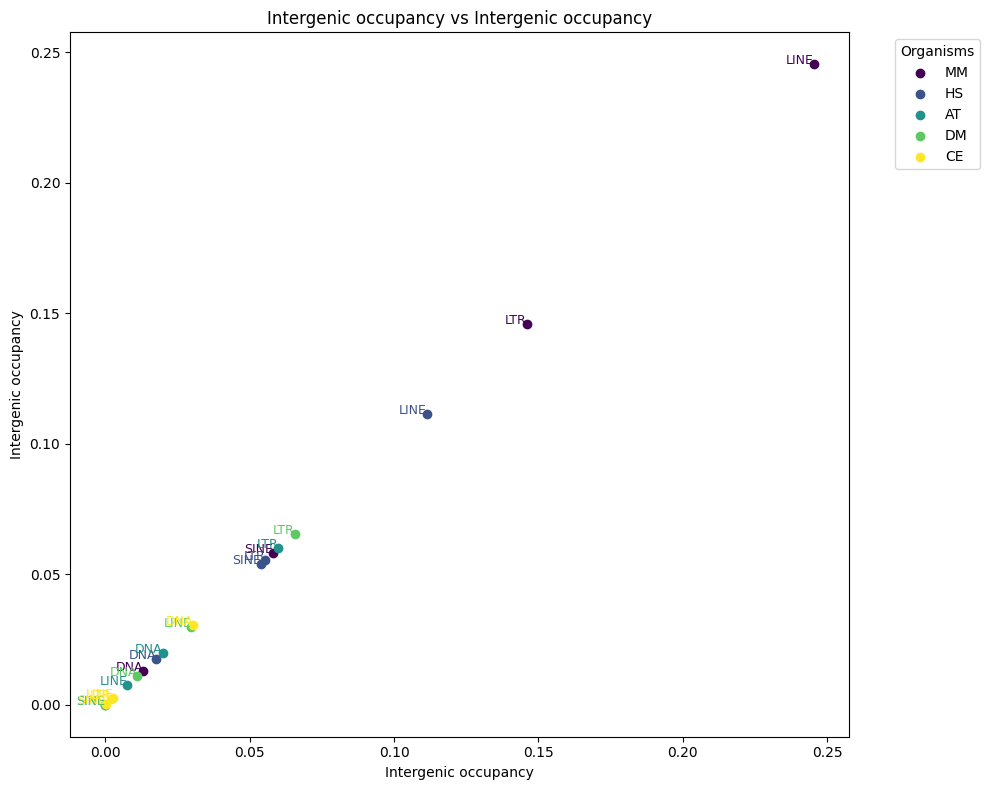

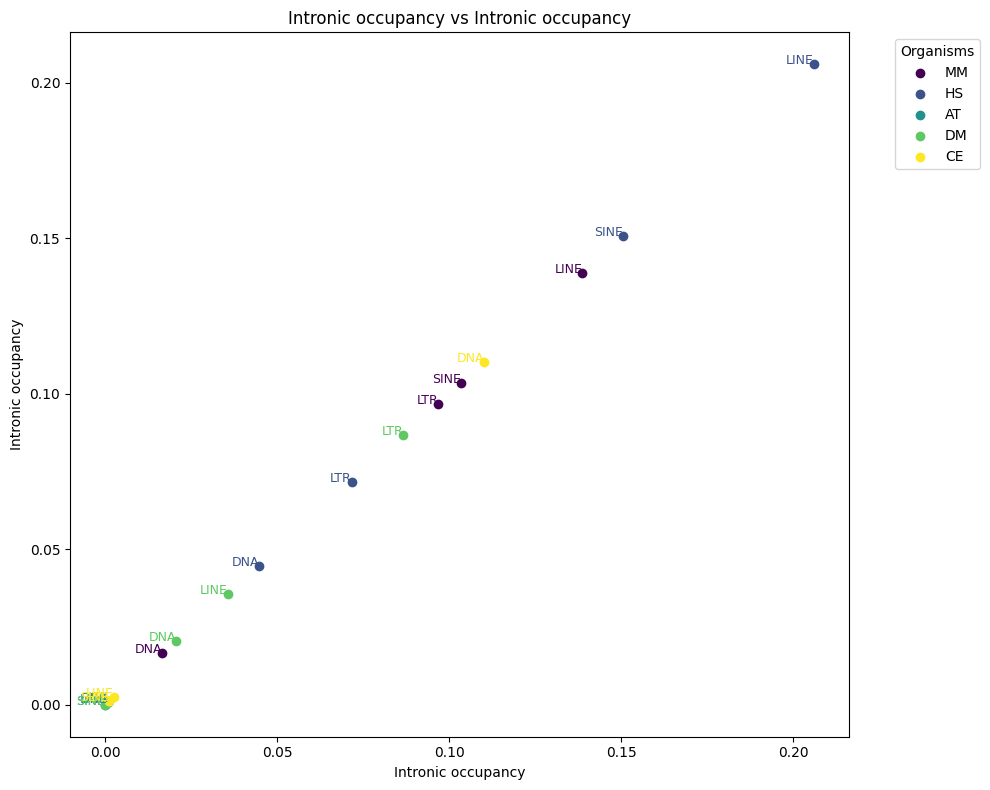

In [200]:
# Groups of columns
groups = {
    'Intergenic lengths': [
        'SINE_intergenic_length', 'LINE_intergenic_length', 'LTR_intergenic_length', 
        'DNA_intergenic_length',
    ],
    'Intronic lengths': [
        'SINE_intronic_length', 'LINE_intronic_length', 'LTR_intronic_length', 
        'DNA_intronic_length',
    ],
    'Intergenic frequencies': [
        'SINE_intergenic_freq', 'LINE_intergenic_freq', 'LTR_intergenic_freq', 
        'DNA_intergenic_freq',
    ],
    'Intronic frequencies': [
        'SINE_intronic_freq', 'LINE_intronic_freq', 'LTR_intronic_freq', 
        'DNA_intronic_freq',
    ],
    'Intergenic occupancy': [
        'SINE_occ_intergenic', 'LINE_occ_intergenic', 'LTR_occ_intergenic', 
        'DNA_occ_intergenic',
    ],
    'Intronic occupancy': [
        'SINE_occ_intronic', 'LINE_occ_intronic', 'LTR_occ_intronic', 
        'DNA_occ_intronic',
    ]
}

# Organism names and colors
organisms = all_normalized_df.index
colors = plt.cm.viridis(np.linspace(0, 1, len(organisms)))

# Plot combinations of the groups
group_names = list(groups.keys())
plot_count = 0
for i, group_x in enumerate(group_names):
    for j, group_y in enumerate(group_names):
        if i <= j:  # Avoid plotting the same pair twice or diagonal plots
            plot_count += 1
            plt.figure(figsize=(10, 8))
            
            for org, color in zip(organisms, colors):
                X = all_normalized_df.loc[org, groups[group_x]]
                Y = all_normalized_df.loc[org, groups[group_y]]
                
                # Label points with the element type (SINE, LINE, etc.)
                labels = ["SINE", "LINE", "LTR", "DNA",]
                for x, y, label in zip(X, Y, labels):
                    plt.scatter(x, y, color=color)
                    plt.text(x, y, label, fontsize=9, ha='right', color=color)

            # Create a legend
            for org, color in zip(organisms, colors):
                plt.scatter([], [], color=color, label=org)  # Empty scatter just to show legend

            plt.legend(title='Organisms', bbox_to_anchor=(1.05, 1), loc='upper left')

            plt.title(f'{group_x} vs {group_y}')
            plt.xlabel(group_x)
            plt.ylabel(group_y)
            plt.tight_layout()
            plt.show()